In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from nba_api.stats.endpoints.playerdashboardbyshootingsplits import PlayerDashboardByShootingSplits
from nba_api.stats.static.players import find_players_by_full_name

In [2]:
from nba_api.stats.endpoints.synergyplaytypes import SynergyPlayTypes
from nba_api.stats.endpoints.leaguedashptstats import LeagueDashPtStats
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.patches import Rectangle
from matplotlib.ticker import FormatStrFormatter


import matplotlib.ticker as mtick

In [3]:
play_types = [
    "PRBallHandler",
    "Isolation",
    "Transition",
    "Spotup",
    "Handoff",
    "OffScreen",
    "Cut",
    "OffRebound",
    "Postup",
    "PRRollman",
]

play_types_seasons = {}


    
def download_play_type_data(season='2023-24'):
    
    play_type_dict = {}
    if season not in play_types_seasons:
        print("Retrieving play types...")
        for play in play_types:
            synergy = SynergyPlayTypes(player_or_team_abbreviation='P', play_type_nullable=play, type_grouping_nullable="offensive", per_mode_simple="PerGame", season=season)
            synergy_df = synergy.get_data_frames()[0]
            play_type_dict[play] = synergy_df
            time.sleep(1)
        play_types_seasons[season] = play_type_dict
    else:
        play_type_dict = play_types_seasons[season]

    
    return play_type_dict




In [4]:
def get_interesting_data(df, target_column):
    final_df = None
    for index, play in enumerate(play_types):
        columns = ["PLAYER_NAME", target_column]
        result = df[play]
        #result = df[play].loc[:, columns]
        result.loc[:, f'TOTAL_{target_column}'] = result[target_column] * result['GP']
        result = result.groupby('PLAYER_NAME').agg({f'TOTAL_{target_column}': 'sum', 'GP': 'sum'}).reset_index()
        result.loc[:, target_column] = result[f'TOTAL_{target_column}'] / result.GP
        result = result.loc[:, columns]
        result = result.rename(columns={target_column: f'{target_column}_{play}'})
        if index == 0:
            final_df = result
        else:
            final_df = pd.merge(left=final_df, right=result, on='PLAYER_NAME', how='outer')
    final_df = final_df.fillna(0.0)
    return final_df


In [8]:
plt.style.use('fivethirtyeight')

In [9]:
def get_data_for_player(player_name, seasons):
    play_type_seasons = {}
    target_seasons = []
    for season in seasons:
        data = download_play_type_data(season=season)
        int_data = get_interesting_data(data, target_column='POSS_PCT')
        target_columns = int_data.columns[1:]
        player_data = int_data.loc[int_data.PLAYER_NAME == player_name]
        total_poss = player_data.loc[:, target_columns].sum(axis=1).iloc[0]
        #for play in play_types:
            #player_data.loc[:, f'POSS_{play}'] = player_data[f'POSS_{play}'] / total_poss * 100
        for play in play_types:
            #player_data.loc[:, f'POSS_{play}'] = player_data[f'POSS_{play}'] / total_poss * 100
            player_data.loc[:, f'POSS_PCT_{play}'] = player_data[f"POSS_PCT_{play}"] * 100
        if len(player_data) == 0:
            continue
        target_seasons.append(season)
        player_data.loc[: ,'SEASON'] = season
        play_type_seasons[season] = player_data.iloc[0]
    return play_type_seasons

def get_data_for_players(player_names, season):
    play_type_players = {}
    for player_name in player_names:
        data = download_play_type_data(season=season)
        int_data = get_interesting_data(data, target_column='POSS_PCT')
        target_columns = int_data.columns[1:]
        player_data = int_data.loc[int_data.PLAYER_NAME == player_name]
        total_poss = player_data.loc[:, target_columns].sum(axis=1).iloc[0]
        for play in play_types:
            #player_data.loc[:, f'POSS_{play}'] = player_data[f'POSS_{play}'] / total_poss * 100
            player_data.loc[:, f'POSS_PCT_{play}'] = player_data[f"POSS_PCT_{play}"] * 100
        if len(player_data) == 0:
            continue
        play_type_players[player_name] = player_data.iloc[0]
    return play_type_players

In [10]:
def plot_line_chart(play_type_season, player_name):
    fig, ax = plt.subplots(figsize=(20, 16))
    
    values = [play_type_seasons[key].iloc[1:-1].tolist() for key in play_type_seasons]
    labels = play_type_seasons['2023-24'].keys()[1:-1]
        
    for index, item in enumerate(values):
        #player_name = player_names[index]
        item = pd.Series(item)
        ax.plot(item, alpha=0.9, lw=6, label=list(play_type_seasons.keys())[index])
        #x = np.arange(len(play_types))
        #y = np.array([it for it in item])
        #ax.fill_between(x, y, alpha=0.1)
        
    ax.set_xticklabels([''] + [item.split("POSS_PCT_")[1] for item in list(labels)], size=18)
    #ax.set_yticklabels(labels=range(-1, 7), size=18)
    ax.set_xticks(range(-1, len(labels)))
    ax.legend(fontsize=18)
    ax.set_xlabel("Play Type", size=32)
    ax.set_ylabel("% of All Possessions", size=32)
    ax.set_title(f"Distribution of possesions for {player_name} depending on play type", size=40)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    for dir in ['left', 'right', 'top', 'bottom']:
        ax.spines[dir].set_visible(False)
    ax.set_facecolor('#FFFFFF')
    fig.set_facecolor('#FFFFFF')

In [11]:
def plot_bar_chart(play_type_season, player_name):    
    fig, ax = plt.subplots(figsize=(20, 16))
    
    bar_width = 1 / (len(play_type_season.keys())+1)
    for index, key in enumerate(play_type_season):
        
        #item = pd.Series(item)
        #ax.plot(item, alpha=0.9, lw=6, label=list(play_type_seasons.keys())[index])
        values = play_type_season[key].tolist()[1:-1]
        labels = play_type_season[key].keys()[1:-1]
        ticks = [i+index * bar_width for i in range(len(labels))]
        ax.bar(x=ticks, height=values, width=bar_width, label=key)
        
    ax.set_xticklabels([''] + [item.split("POSS_PCT_")[1] for item in list(labels)], size=18)
    #ax.set_yticklabels(labels=range(-1, 7), size=18)
    ax.set_xticks([i+bar_width for i in range(-1, len(labels))])
    ax.legend(fontsize=18)
    ax.set_xlabel("Play Type", size=32)
    ax.set_ylabel("% of All Possessions", size=32)
    ax.set_title(f"Distribution of possesions for {player_name} depending on play type", size=40)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax.set_facecolor('#FFFFFF')
    for dir in ['left', 'right', 'top', 'bottom']:
        ax.spines[dir].set_visible(False)
    fig.set_facecolor('#FFFFFF')

In [28]:
def plot_bar_chart_non_white(dict_data_values, title):    
    fig, ax = plt.subplots(figsize=(32, 18))

    num_labels = len(dict_data_values.keys())
    bar_width = 1 / (num_labels+1)
    for index, key in enumerate(dict_data_values):
        
        values = dict_data_values[key].tolist()[1:-1]
        labels = dict_data_values[key].keys()[1:-1]
        ticks = [i+index * bar_width for i in range(len(labels))]
        ax.bar(x=ticks, height=values, width=bar_width, label=key)
        
    ax.set_xticklabels([''] + [item.split("POSS_PCT_")[1] for item in list(labels)], size=18)
    #ax.set_yticklabels(labels=range(-1, 7), size=18)
    if num_labels % 2 == 0:
        modifier = bar_width * num_labels/2 - bar_width/2
    else:
        modifier = bar_width * (num_labels-2)
    ax.set_xticks([i+modifier for i in range(-1, len(labels))])
    ax.legend(fontsize=18)
    ax.set_xlabel("Play Type", size=32)
    ax.set_ylabel("% of All Possessions", size=32)
    ax.set_title(title, size=40)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax.grid(False, axis='x')

def plot_bar_chart_non_white_hr(dict_data_values, title):    
    fig, ax = plt.subplots(figsize=(32, 18))

    num_labels = len(dict_data_values.keys())
    bar_width = 1 / (num_labels+1)
    for index, key in enumerate(dict_data_values):
        
        values = dict_data_values[key].tolist()[1:-1]
        labels = dict_data_values[key].keys()[1:-1]
        ticks = [i+index * bar_width for i in range(len(labels))]
        ax.bar(x=ticks, height=values, width=bar_width, label=key)
        
    ax.set_xticklabels([''] + [item.split("POSS_PCT_")[1] for item in list(labels)], size=18)
    #ax.set_yticklabels(labels=range(-1, 7), size=18)
    if num_labels % 2 == 0:
        modifier = bar_width * num_labels/2 - bar_width/2
    else:
        modifier = bar_width * (num_labels-2)
    ax.set_xticks([i+modifier for i in range(-1, len(labels))])
    ax.legend(fontsize=18)
    ax.set_xlabel("Vrsta akcije", size=32)
    ax.set_ylabel("% svih posjeda", size=32)
    ax.set_title(title, size=40)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax.text(x=len(labels)-0.5, y=-2.25, s='twitter: @daniel_bratulic', ha='right', va='center', size=20)
    ax.text(x=0.25, y=-2.25, s='data: nba.com', ha='left', va='center', size=20)
    ax.grid(False, axis='x')

## Franz Wagner

In [21]:
play_type_seasons = get_data_for_player('Franz Wagner', seasons=seasons)

C:\Users\danie\AppData\Local\Temp\ipykernel_2168\2347612155.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data.loc[: ,'SEASON'] = season


Retrieving play types...


C:\Users\danie\AppData\Local\Temp\ipykernel_2168\2347612155.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data.loc[: ,'SEASON'] = season


Retrieving play types...


C:\Users\danie\AppData\Local\Temp\ipykernel_2168\2347612155.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data.loc[: ,'SEASON'] = season


In [58]:
play_type_seasons = get_data_for_player('Franz Wagner', seasons=seasons)

C:\Users\danie\AppData\Local\Temp\ipykernel_5988\365737317.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data.loc[: ,'SEASON'] = season
C:\Users\danie\AppData\Local\Temp\ipykernel_5988\365737317.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data.loc[: ,'SEASON'] = season
C:\Users\danie\AppData\Local\Temp\ipykernel_5988\365737317.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

C:\Users\danie\AppData\Local\Temp\ipykernel_5988\365737317.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data.loc[: ,'SEASON'] = season
C:\Users\danie\AppData\Local\Temp\ipykernel_5988\365737317.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data.loc[: ,'SEASON'] = season
C:\Users\danie\AppData\Local\Temp\ipykernel_5988\365737317.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

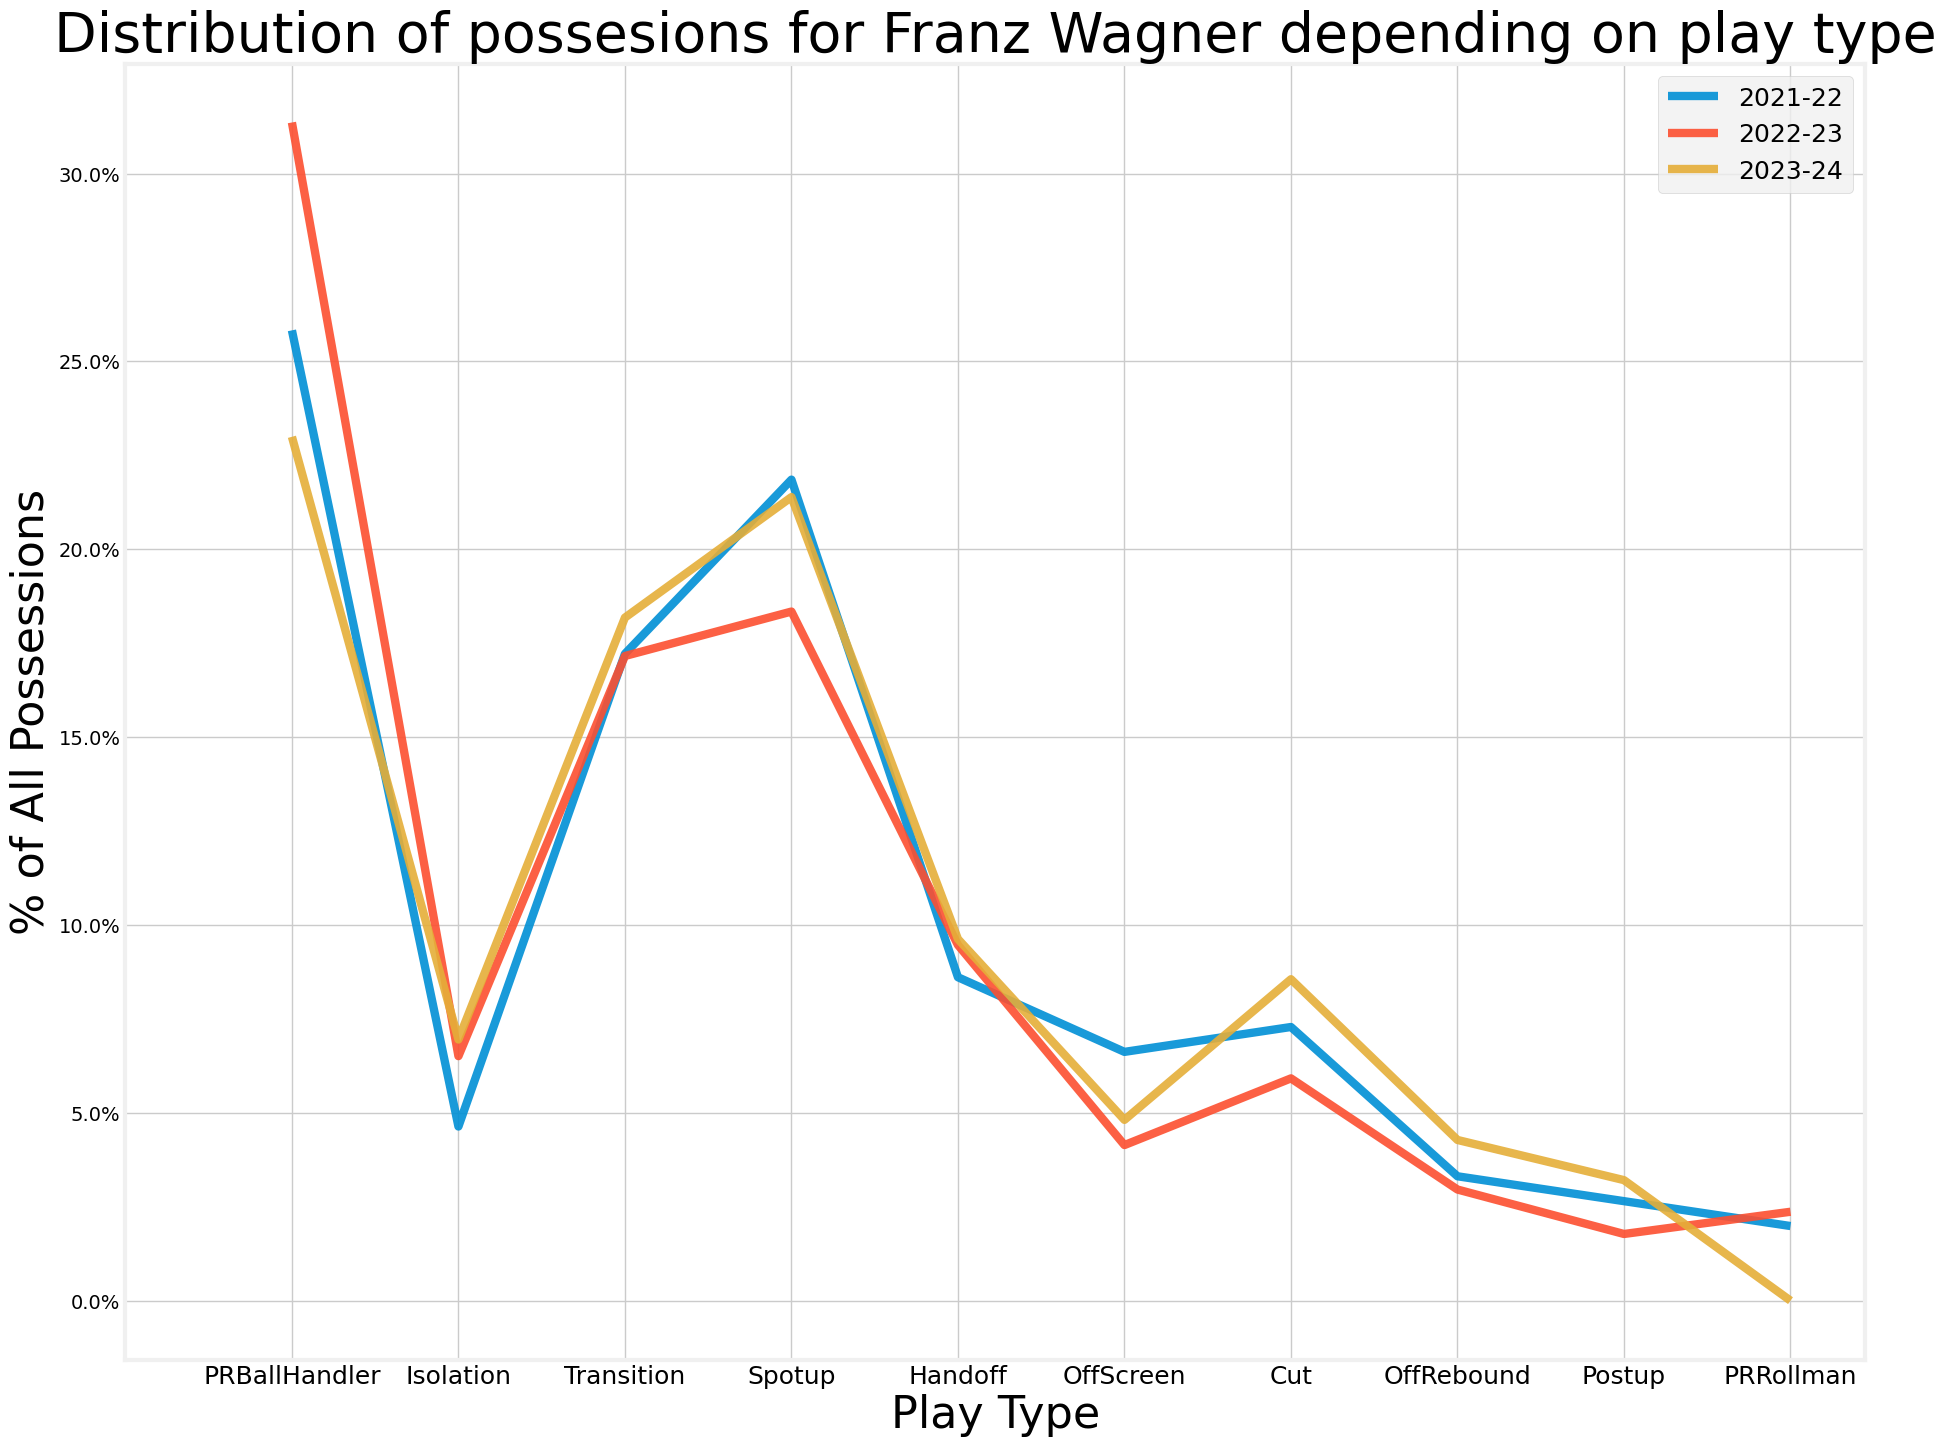

In [62]:
play_type_seasons = get_data_for_player('Franz Wagner', seasons=seasons)
plot_line_chart(play_type_seasons, 'Franz Wagner')

In [49]:
player_name = "Franz Wagner"
play_type_seasons = {}
target_seasons = []
for season in seasons:
    data = download_play_type_data(season=season)
    int_data = get_interesting_data(data, target_column='POSS')
    player_data = int_data.loc[int_data.PLAYER_NAME == player_name]
    total_poss = player_data.loc[:, target_columns].sum(axis=1).iloc[0]
    for play in play_types:
        player_data.loc[:, f'POSS_{play}'] = player_data[f'POSS_{play}'] / total_poss * 100
    if len(player_data) == 0:
        continue
    target_seasons.append(season)
    player_data.loc[: ,'SEASON'] = season
    play_type_seasons[season] = player_data.iloc[0]

C:\Users\danie\AppData\Local\Temp\ipykernel_5988\1420153270.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data.loc[: ,'SEASON'] = season
C:\Users\danie\AppData\Local\Temp\ipykernel_5988\1420153270.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data.loc[: ,'SEASON'] = season
C:\Users\danie\AppData\Local\Temp\ipykernel_5988\1420153270.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

C:\Users\danie\AppData\Local\Temp\ipykernel_5988\1328825434.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + [item.split("_")[1] for item in list(labels)], size=18)


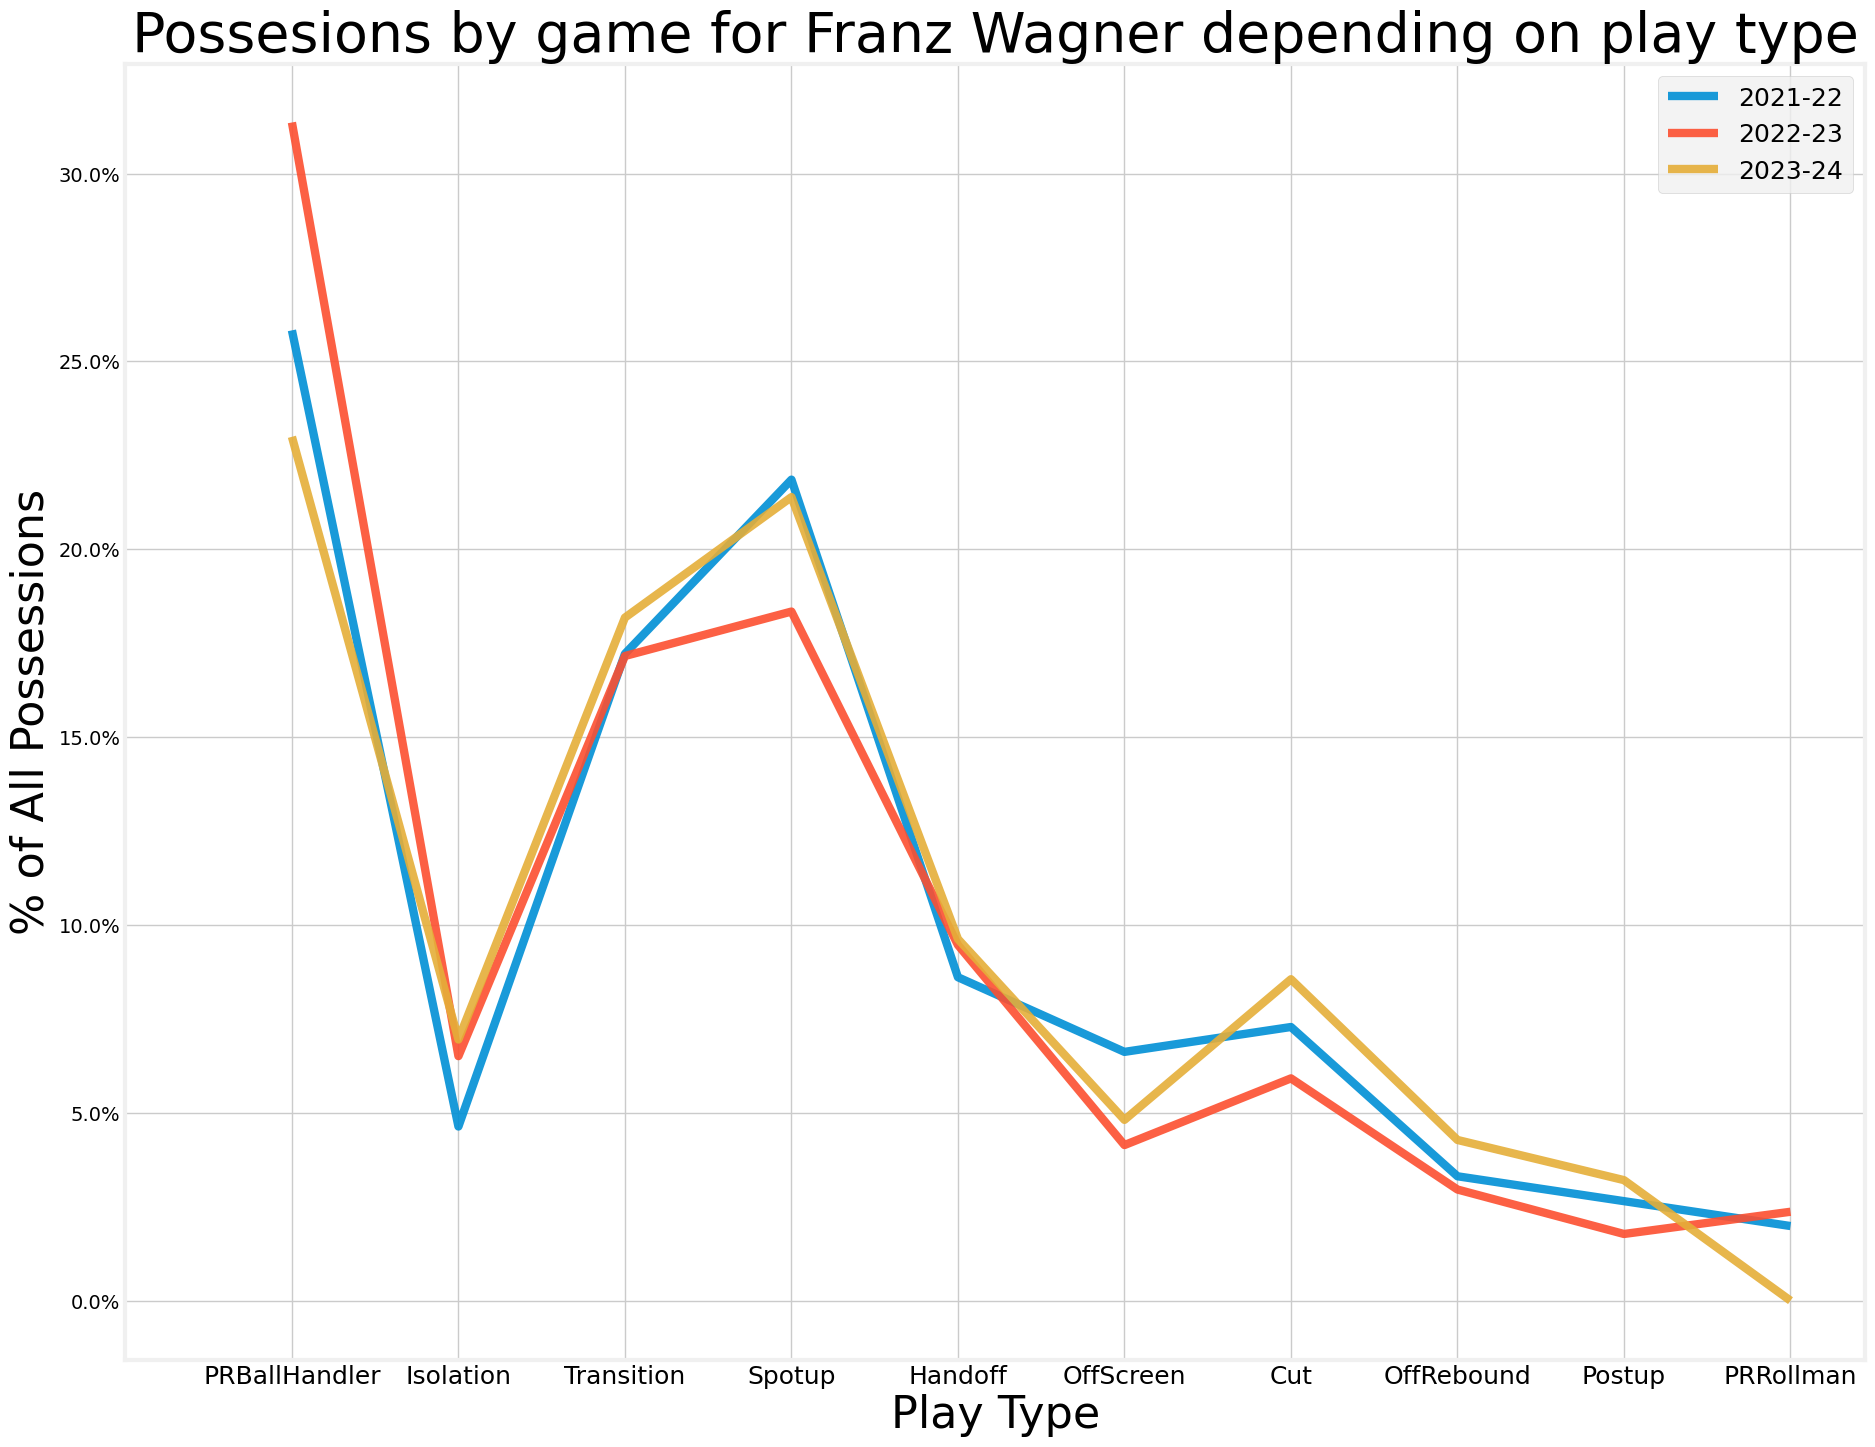

## Locations

In [27]:
def get_labels_lists(player_name, seasons):
    player_id = find_players_by_full_name(player_name)[0]['id']
    area_dfs = {}
    for season in seasons:
        if season in areas_dfs:
            area_df = areas_dfs[season]
        else:
            res = PlayerDashboardByShootingSplits(player_id=player_id, season=season)
            area_df = res.get_data_frames()[3]
            area_df = area_df.loc[area_df.GROUP_VALUE != "Backcourt"]
            total_sum = area_df.FGA.sum()
            area_df.loc[:, "FGA_PCT"] = area_df.FGA / total_sum
            areas_dfs[season] = area_df
        time.sleep(0.3)

    area_values = {}

    for season in seasons:
        area_df = areas_dfs[season]
        for area in area_df.GROUP_VALUE.unique().tolist():
            if area not in area_values:
                area_values[area] = []
            area_values[area].append(area_df.loc[area_df.GROUP_VALUE == area].FGA_PCT.iloc[0])

    lists = []
    labels = []
    for key in area_values:
        labels.append(key)
        lists.append(area_values[key])
    return labels, lists

In [12]:
seasons = [f"{item}-{str(item+1)[-2:]}" for item in range(2003, 2024)]

In [13]:
player_name = "LeBron James"

In [14]:
player_id = find_players_by_full_name(player_name)[0]['id']

In [23]:
areas_dfs = {}


In [16]:
for season in seasons:
    if season in areas_dfs:
        area_df = areas_dfs[season]
    else:
        res = PlayerDashboardByShootingSplits(player_id=player_id, season=season)
        area_df = res.get_data_frames()[3]
        area_df = area_df.loc[area_df.GROUP_VALUE != "Backcourt"]
        total_sum = area_df.FGA.sum()
        area_df.loc[:, "FGA_PCT"] = area_df.FGA / total_sum
        areas_dfs[season] = area_df
    time.sleep(0.3)

In [17]:
area_values = {}

for season in seasons:
    area_df = areas_dfs[season]
    for area in area_df.GROUP_VALUE.unique().tolist():
        if area not in area_values:
            area_values[area] = []
        area_values[area].append(area_df.loc[area_df.GROUP_VALUE == area].FGA_PCT.iloc[0])

In [18]:
lists = []
labels = []
for key in area_values:
    labels.append(key)
    lists.append(area_values[key])

In [19]:
labels, lists = get_labels_lists(player_name, seasons)

C:\Users\danie\AppData\Local\Temp\ipykernel_22884\565883777.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{item}%" for item in range(0, 120, 20)], size=18)
C:\Users\danie\AppData\Local\Temp\ipykernel_22884\565883777.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(seasons, size=18)


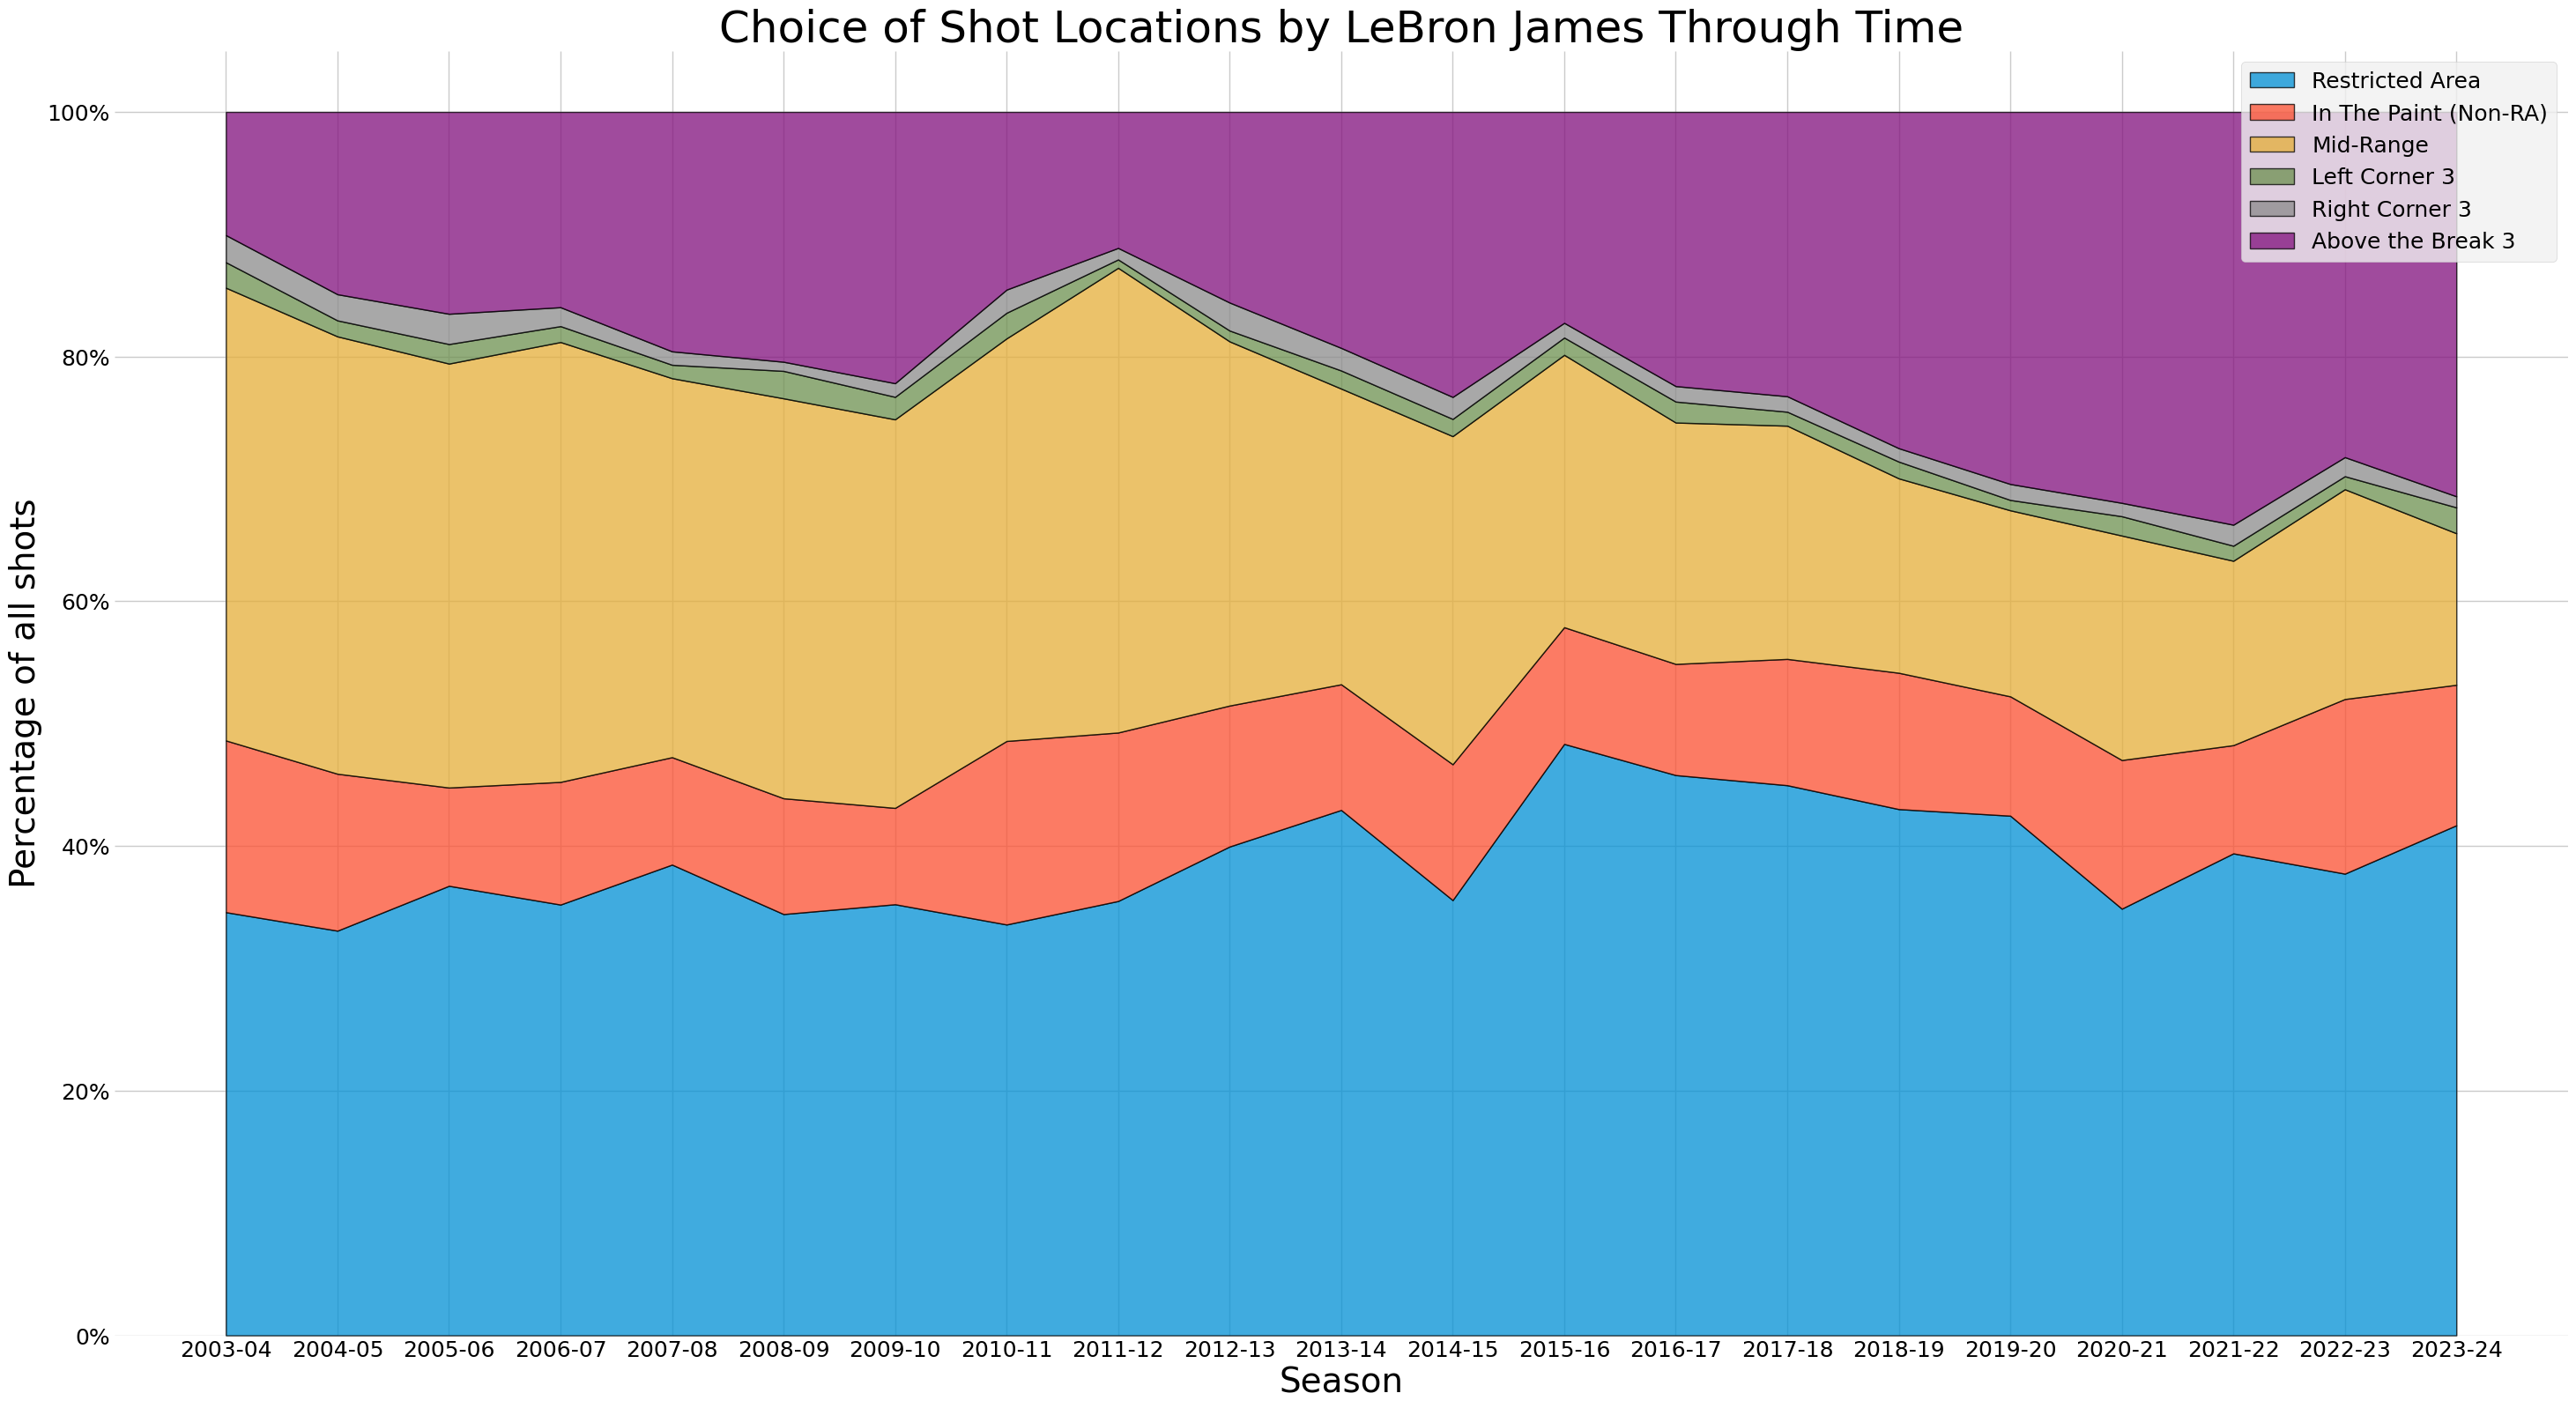

In [21]:
fig, ax = plt.subplots(figsize=(32, 18))

ax.stackplot(seasons, lists, labels=labels, alpha=0.75, lw=1, edgecolors='black')
ax.set_yticklabels([f"{item}%" for item in range(0, 120, 20)], size=18)
ax.set_xticklabels(seasons, size=18)
ax.set_ylabel("Percentage of all shots", size=28)
ax.set_xlabel("Season", size=28)

ax.set_title(f"Choice of Shot Locations by {player_name} Through Time", size=36)
ax.legend(fontsize=18)
ax.set_facecolor('#FFFFFF')
for dir in ['left', 'right', 'top', 'bottom']:
    ax.spines[dir].set_visible(False)
fig.set_facecolor('#FFFFFF')


## James Harden

In [28]:
seasons = [f"{season}-{str(season+1)[-2:]}" for season in range(2012, 2024)]
player_name = "James Harden"

In [29]:
labels, lists = get_labels_lists(player_name, seasons)


C:\Users\danie\AppData\Local\Temp\ipykernel_6756\277336997.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{item}%" for item in range(0, 120, 20)], size=18)
C:\Users\danie\AppData\Local\Temp\ipykernel_6756\277336997.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(seasons, size=18)


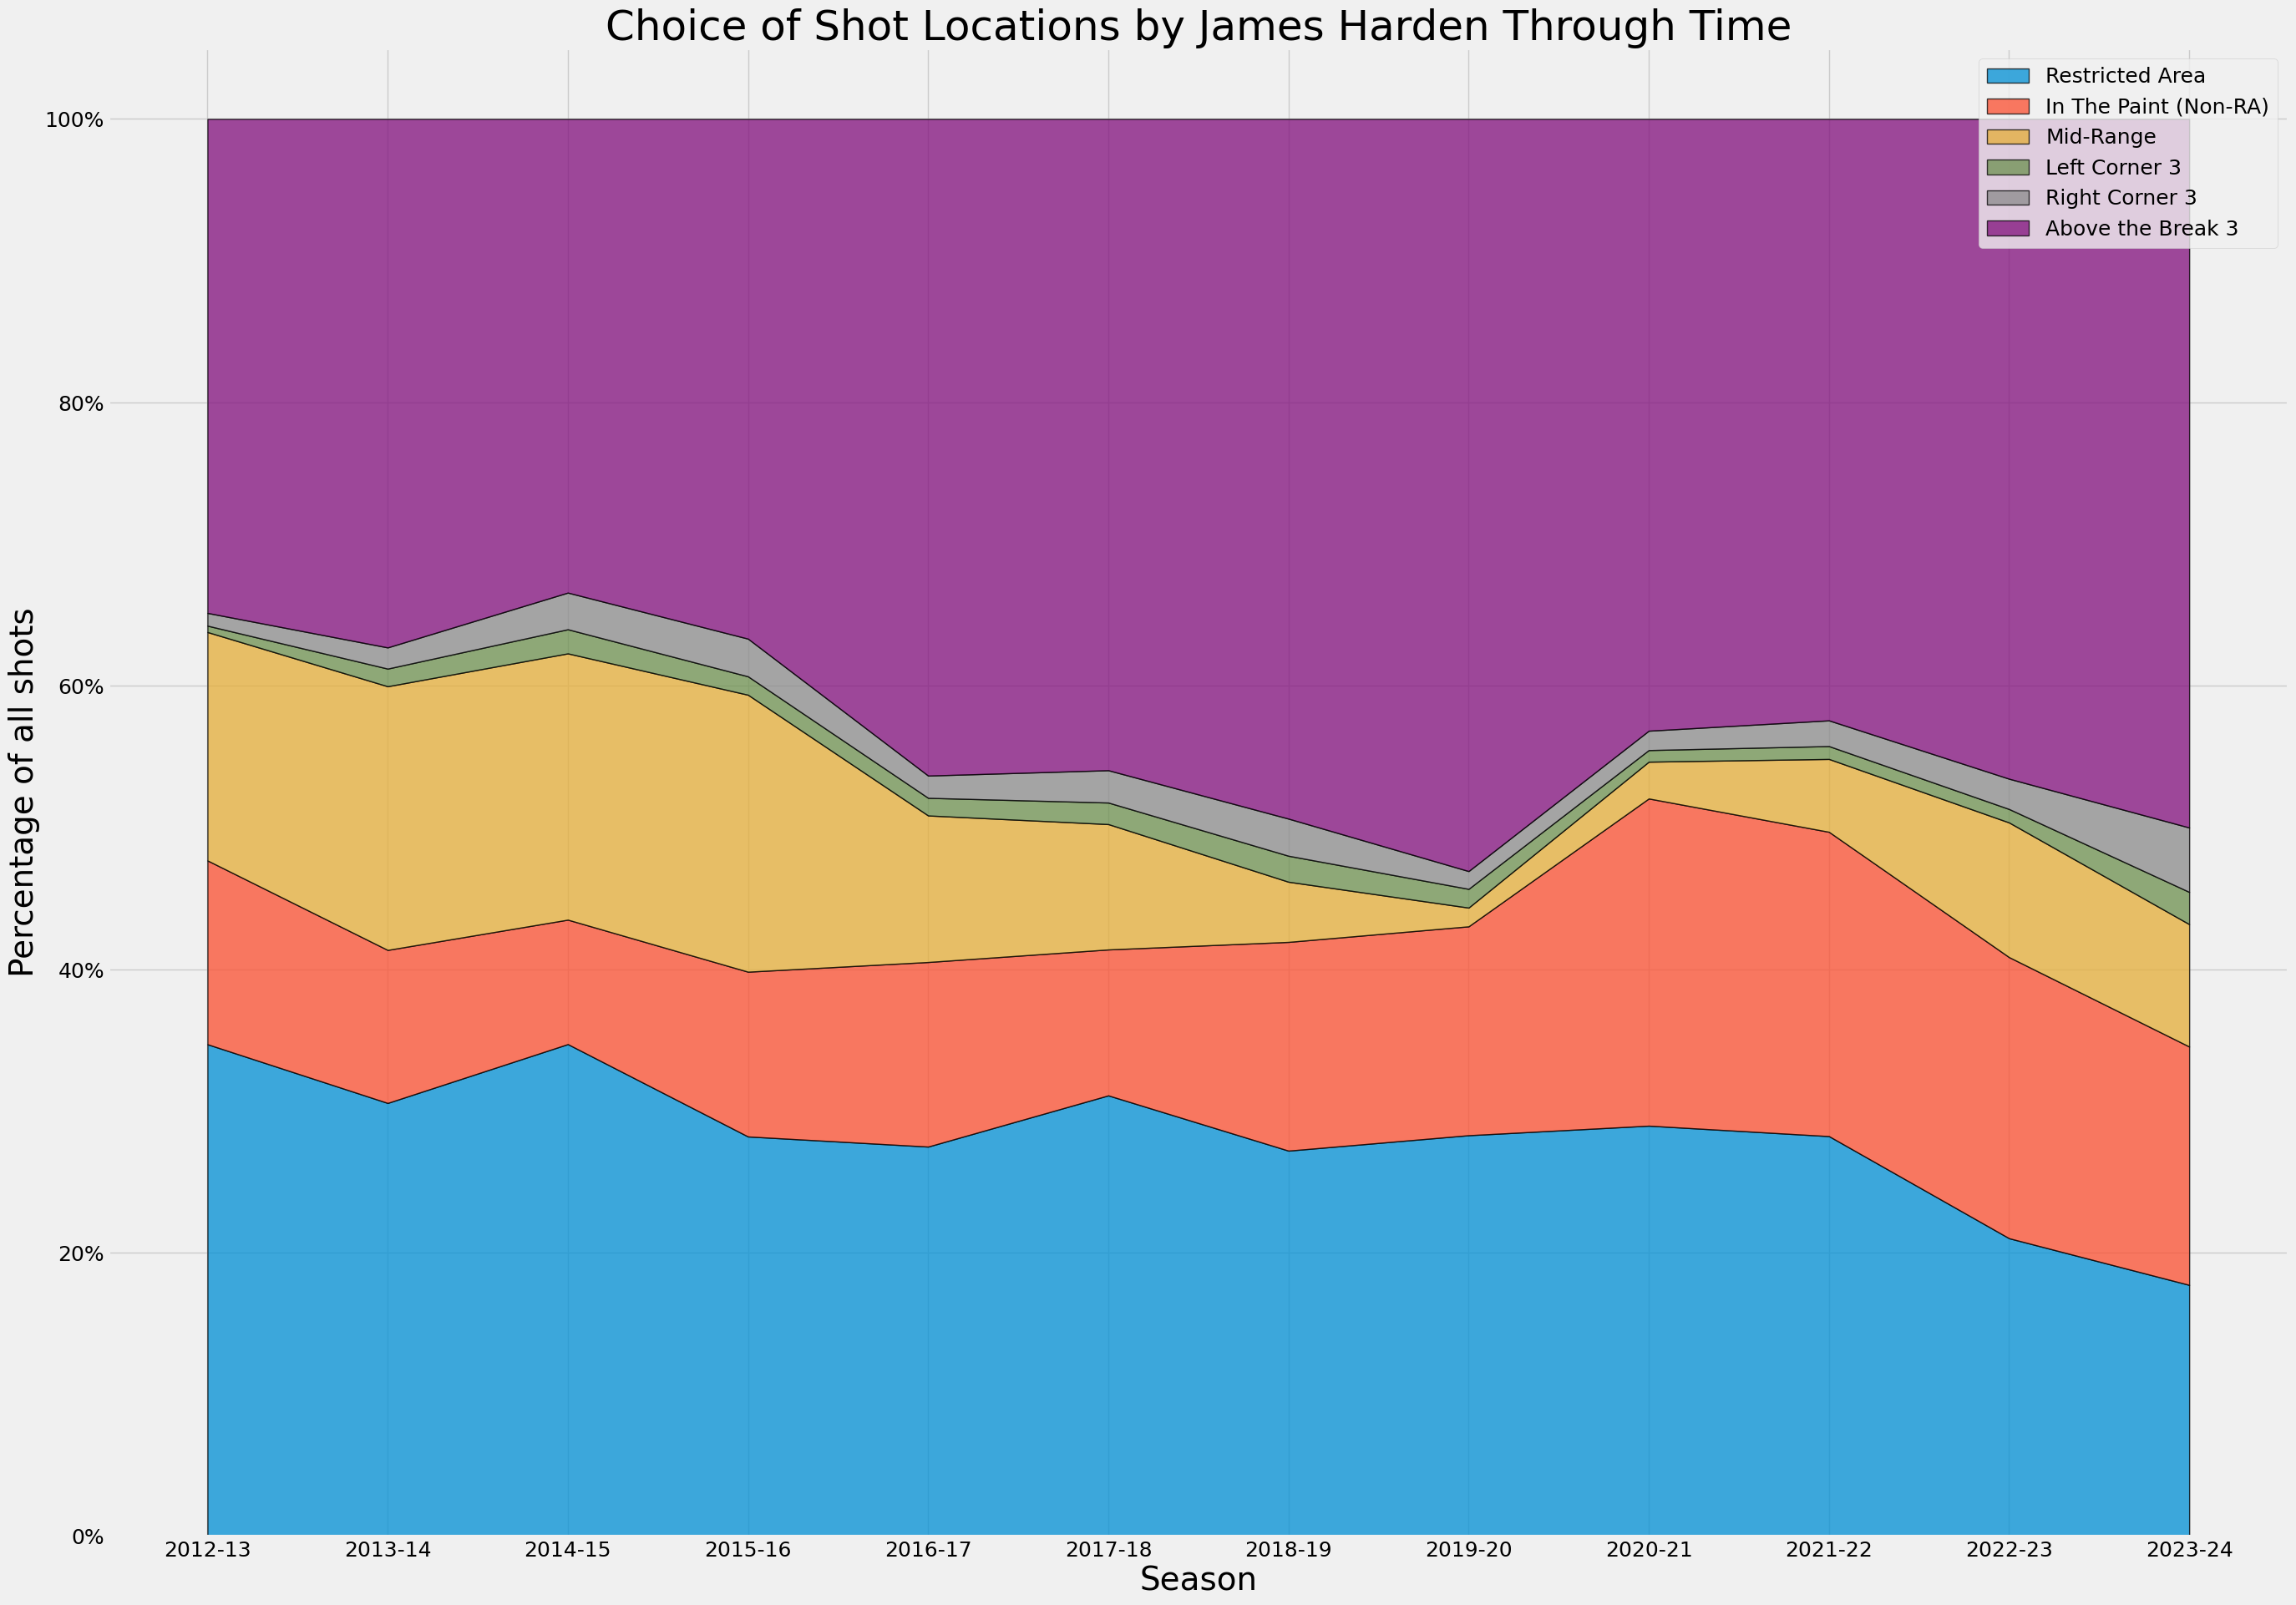

In [30]:

fig, ax = plt.subplots(figsize=(30, 22))

ax.stackplot(seasons, lists, labels=labels, alpha=0.75, lw=1, edgecolors='black')
ax.set_yticklabels([f"{item}%" for item in range(0, 120, 20)], size=18)
ax.set_xticklabels(seasons, size=18)
ax.set_ylabel("Percentage of all shots", size=28)
ax.set_xlabel("Season", size=28)

ax.set_title(f"Choice of Shot Locations by {player_name} Through Time", size=36)
ax.legend(fontsize=18)

## Carmelo Anthony

In [34]:
seasons = [f"{item}-{str(item+1)[-2:]}" for item in range(2003, 2022)]

player_name = "Carmelo Anthony"

In [37]:
labels, lists = get_labels_lists(player_name, seasons)


c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  after removing the cwd from sys.path.
c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  """


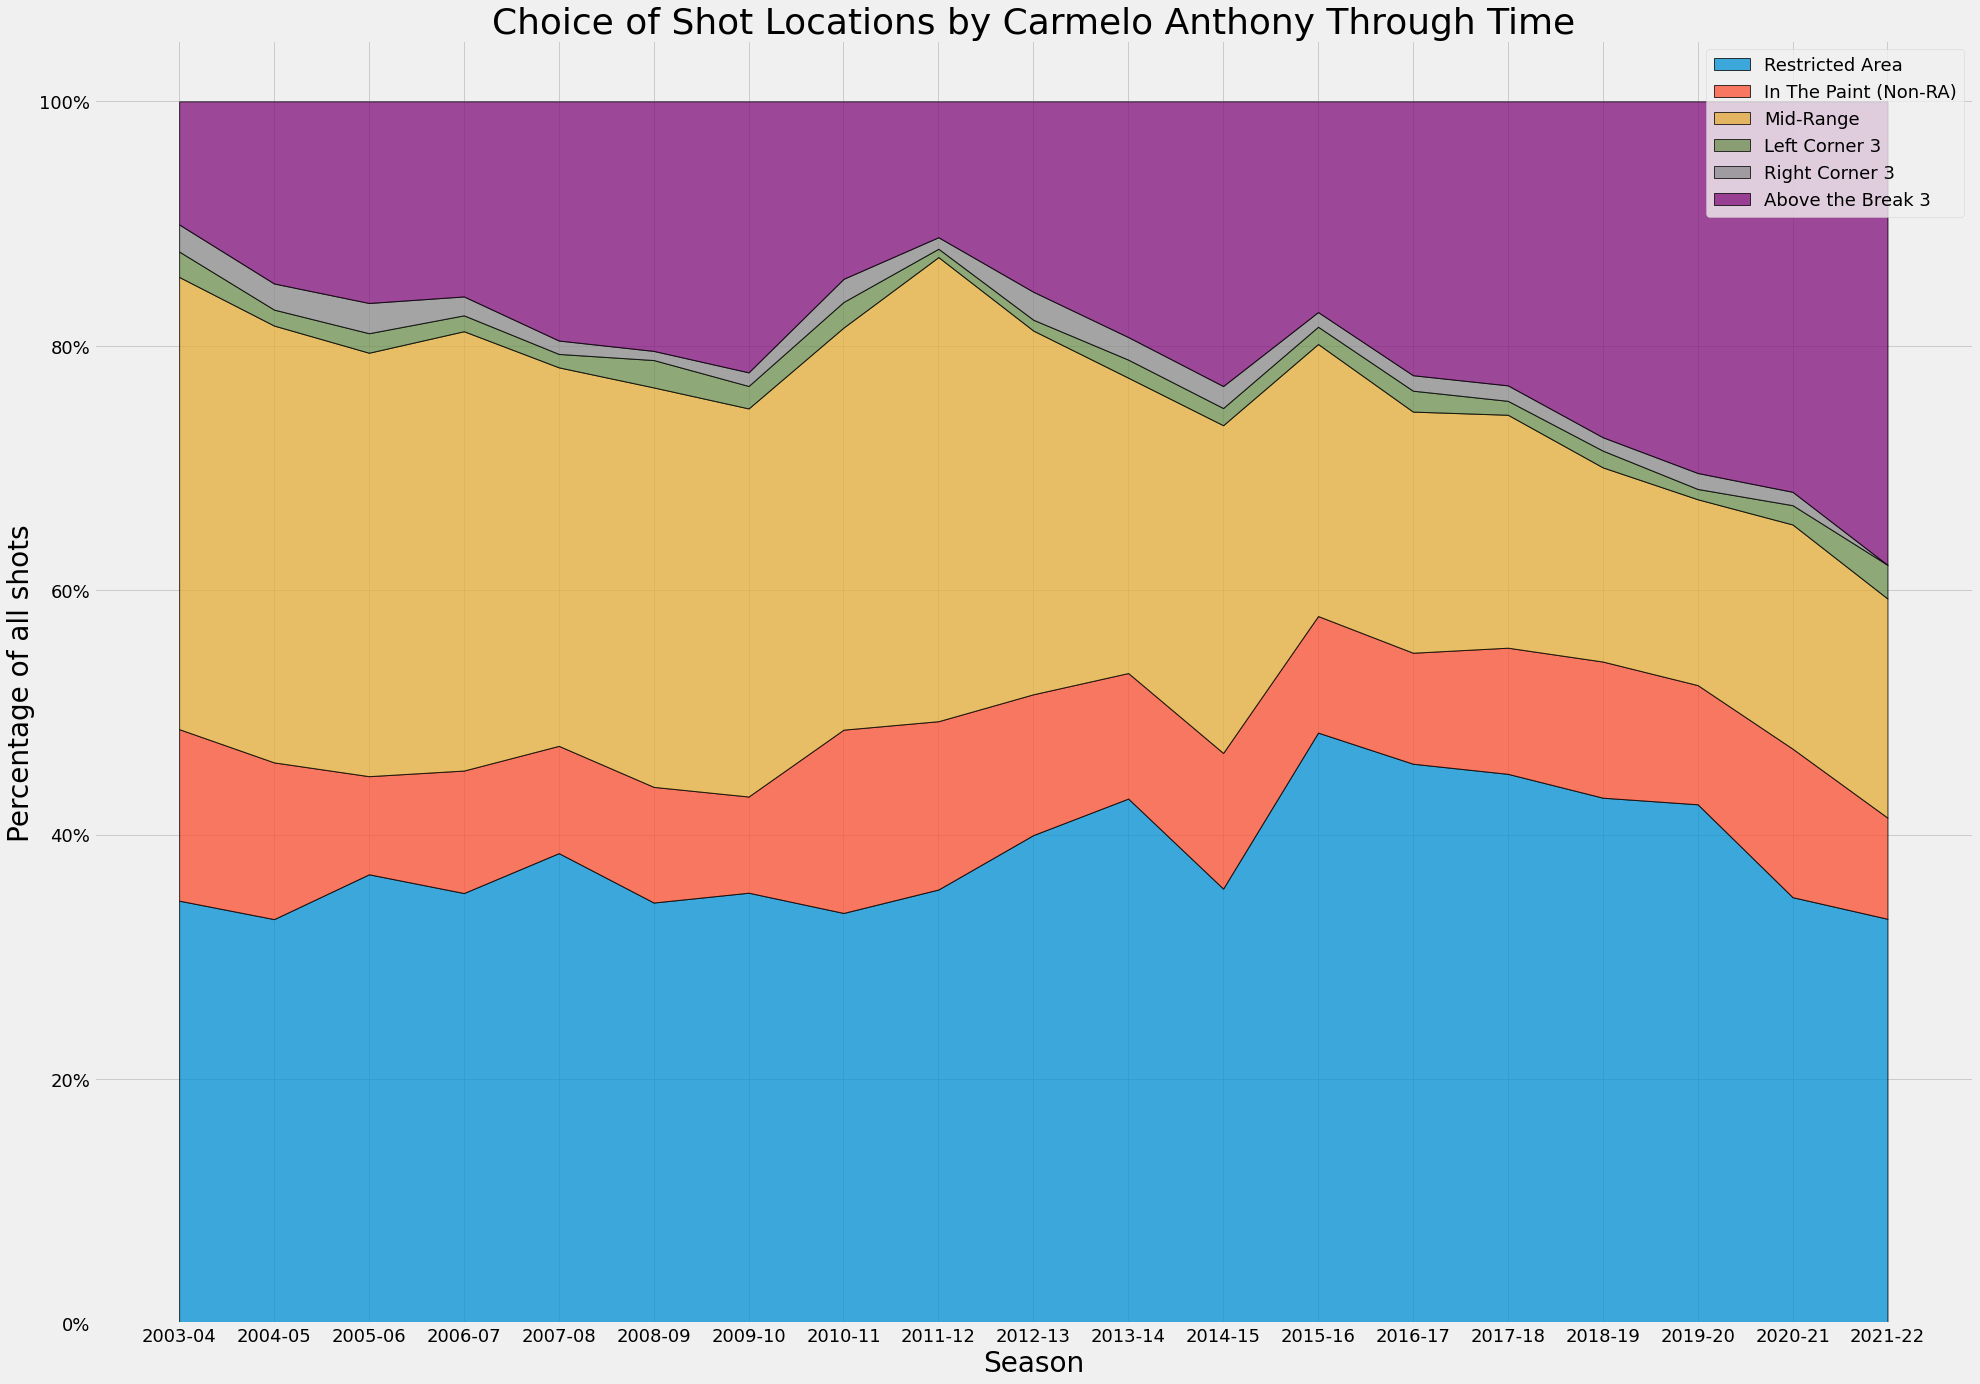

In [38]:

fig, ax = plt.subplots(figsize=(30, 22))

ax.stackplot(seasons, lists, labels=labels, alpha=0.75, lw=1, edgecolors='black')
ax.set_yticklabels([f"{item}%" for item in range(0, 120, 20)], size=18)
ax.set_xticklabels(seasons, size=18)
ax.set_ylabel("Percentage of all shots", size=28)
ax.set_xlabel("Season", size=28)

ax.set_title(f"Choice of Shot Locations by {player_name} Through Time", size=36)
ax.legend(fontsize=18)

## Alperen Sengun

C:\Users\danie\AppData\Local\Temp\ipykernel_11848\2079668285.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data.loc[: ,'SEASON'] = season
C:\Users\danie\AppData\Local\Temp\ipykernel_11848\2079668285.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data.loc[: ,'SEASON'] = season
C:\Users\danie\AppData\Local\Temp\ipykernel_11848\2079668285.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

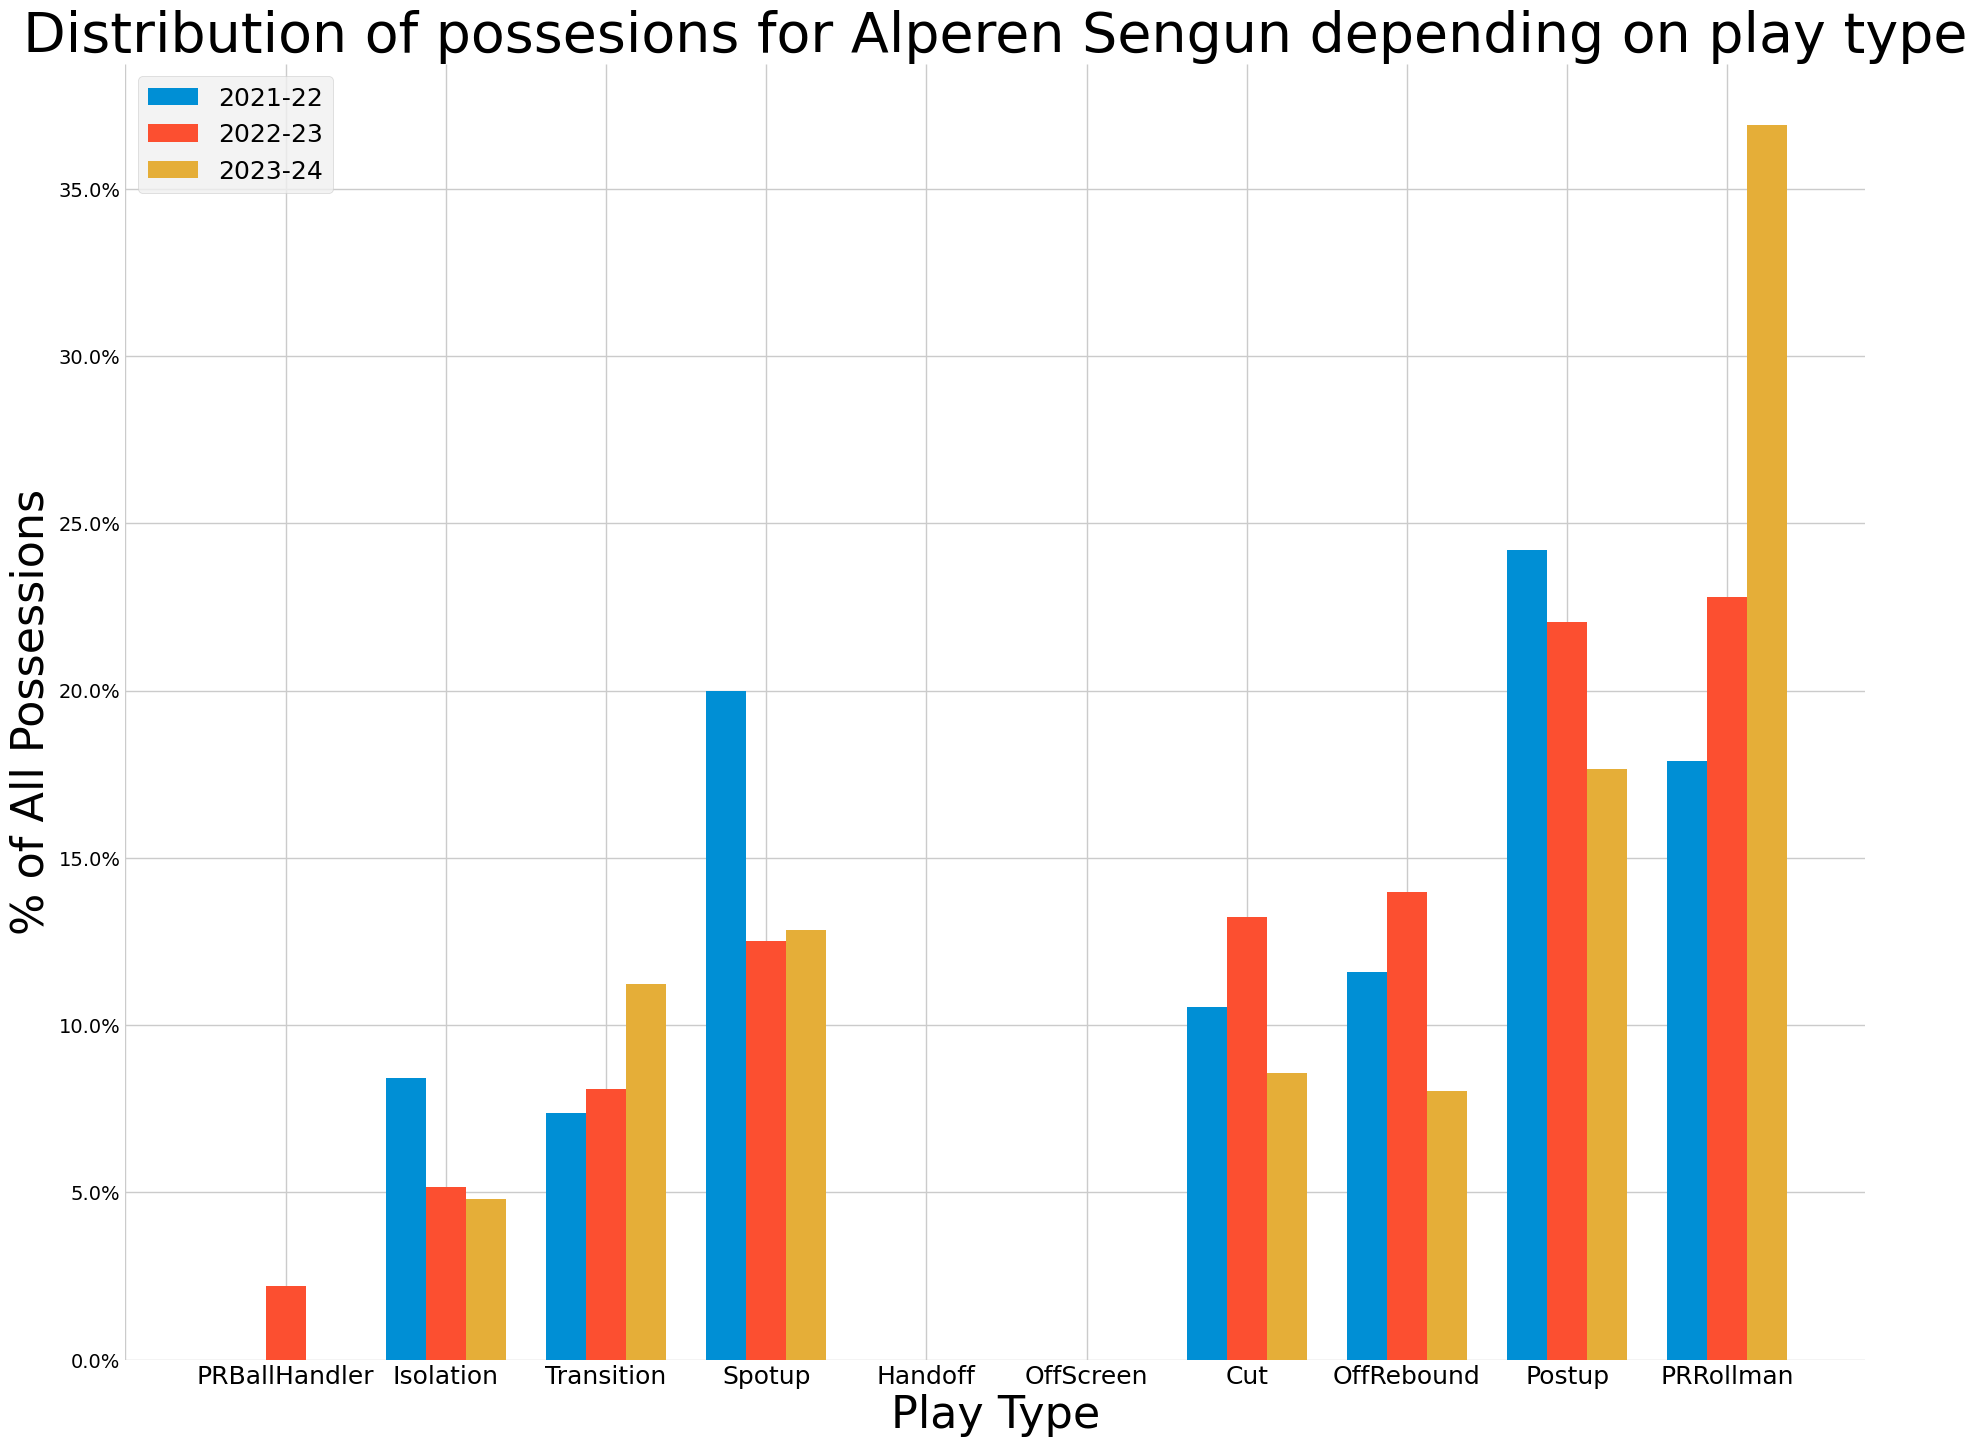

In [24]:
player_name = 'Alperen Sengun'

play_type_seasons = get_data_for_player(player_name, seasons=seasons)
plot_bar_chart(play_type_seasons, player_name)


## Scottie Barnes

C:\Users\danie\AppData\Local\Temp\ipykernel_2168\2347612155.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data.loc[: ,'SEASON'] = season
C:\Users\danie\AppData\Local\Temp\ipykernel_2168\2347612155.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data.loc[: ,'SEASON'] = season
C:\Users\danie\AppData\Local\Temp\ipykernel_2168\2347612155.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

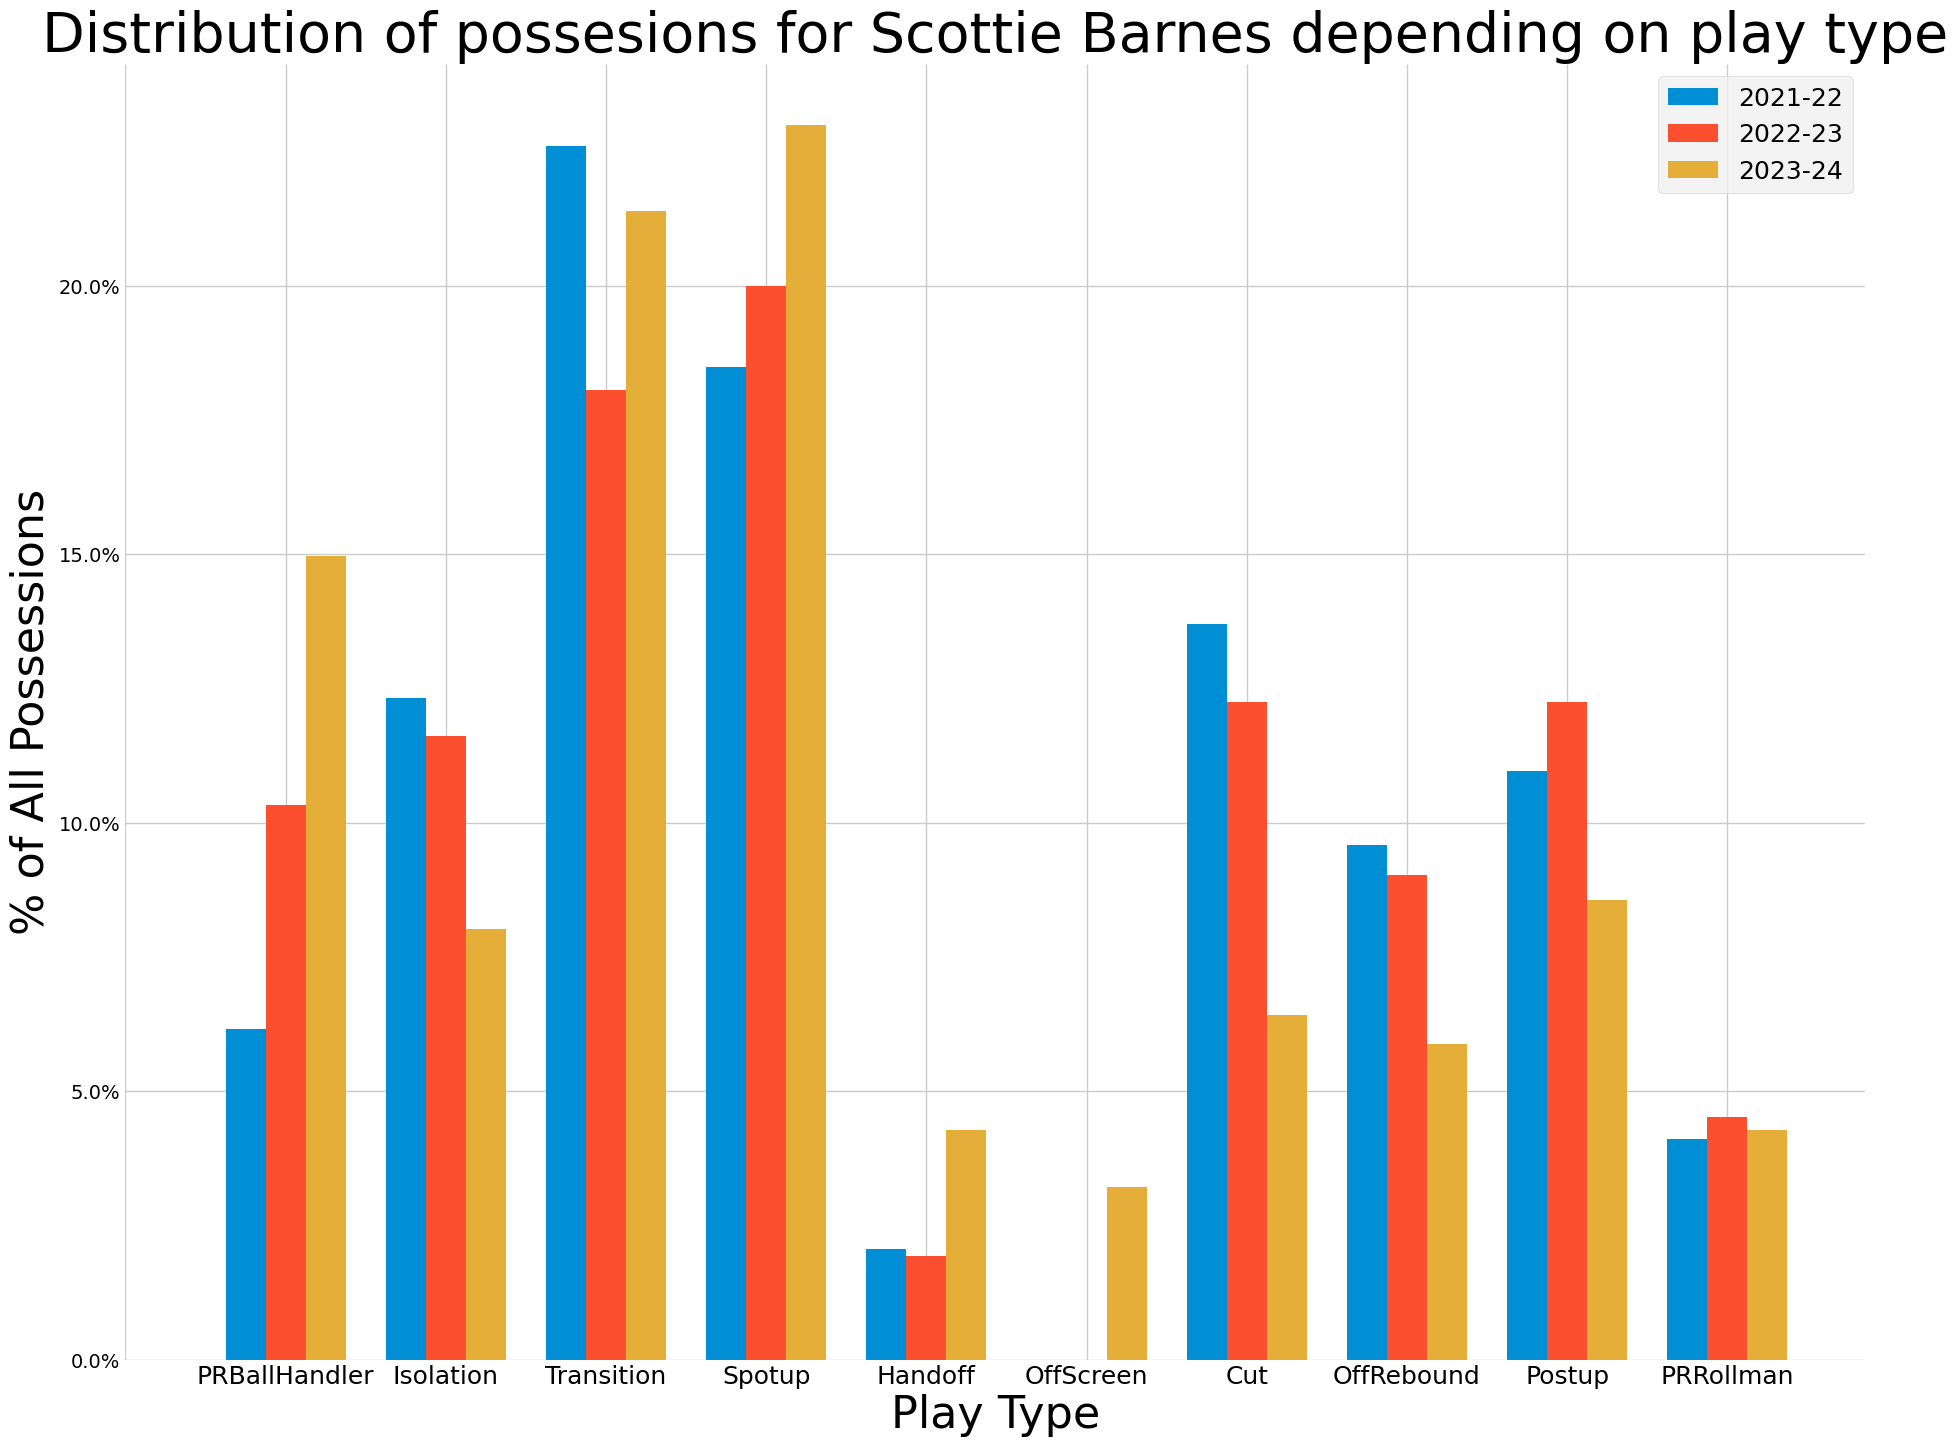

In [59]:
player_name = 'Scottie Barnes'
play_type_seasons = get_data_for_player(player_name, seasons=seasons)
plot_bar_chart(play_type_seasons, player_name)

C:\Users\danie\AppData\Local\Temp\ipykernel_2168\2347612155.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data.loc[: ,'SEASON'] = season
C:\Users\danie\AppData\Local\Temp\ipykernel_2168\2347612155.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data.loc[: ,'SEASON'] = season
C:\Users\danie\AppData\Local\Temp\ipykernel_2168\2347612155.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

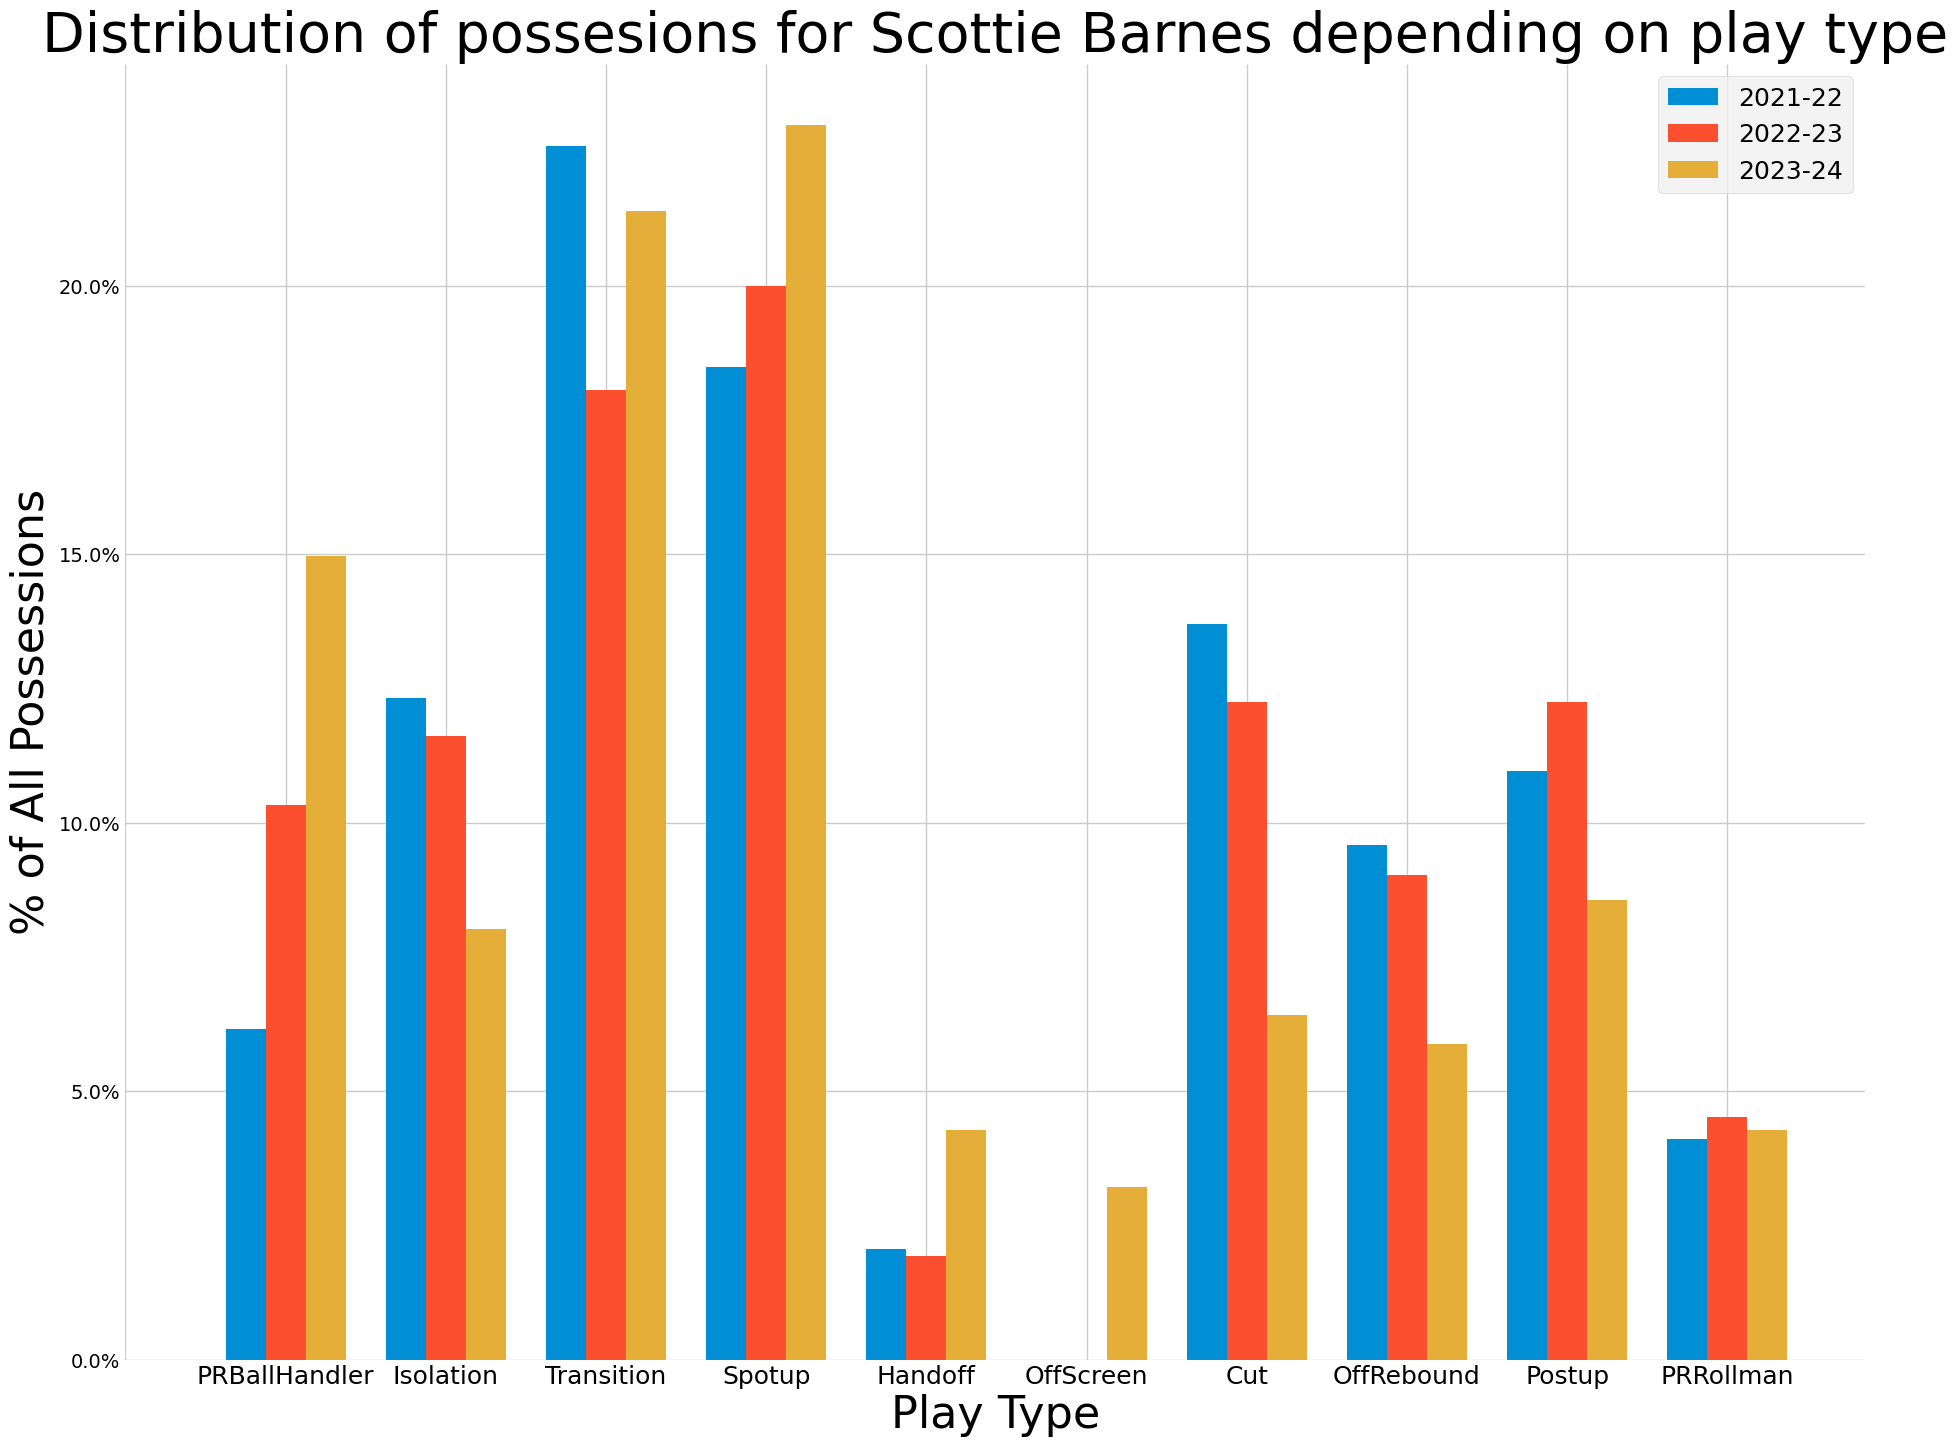

In [57]:
player_name = 'Scottie Barnes'
play_type_seasons = get_data_for_player(player_name, seasons=seasons)
plot_bar_chart(play_type_seasons, player_name)


## Evan Mobley

C:\Users\danie\AppData\Local\Temp\ipykernel_2168\2347612155.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data.loc[: ,'SEASON'] = season
C:\Users\danie\AppData\Local\Temp\ipykernel_2168\2347612155.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data.loc[: ,'SEASON'] = season
C:\Users\danie\AppData\Local\Temp\ipykernel_2168\2347612155.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

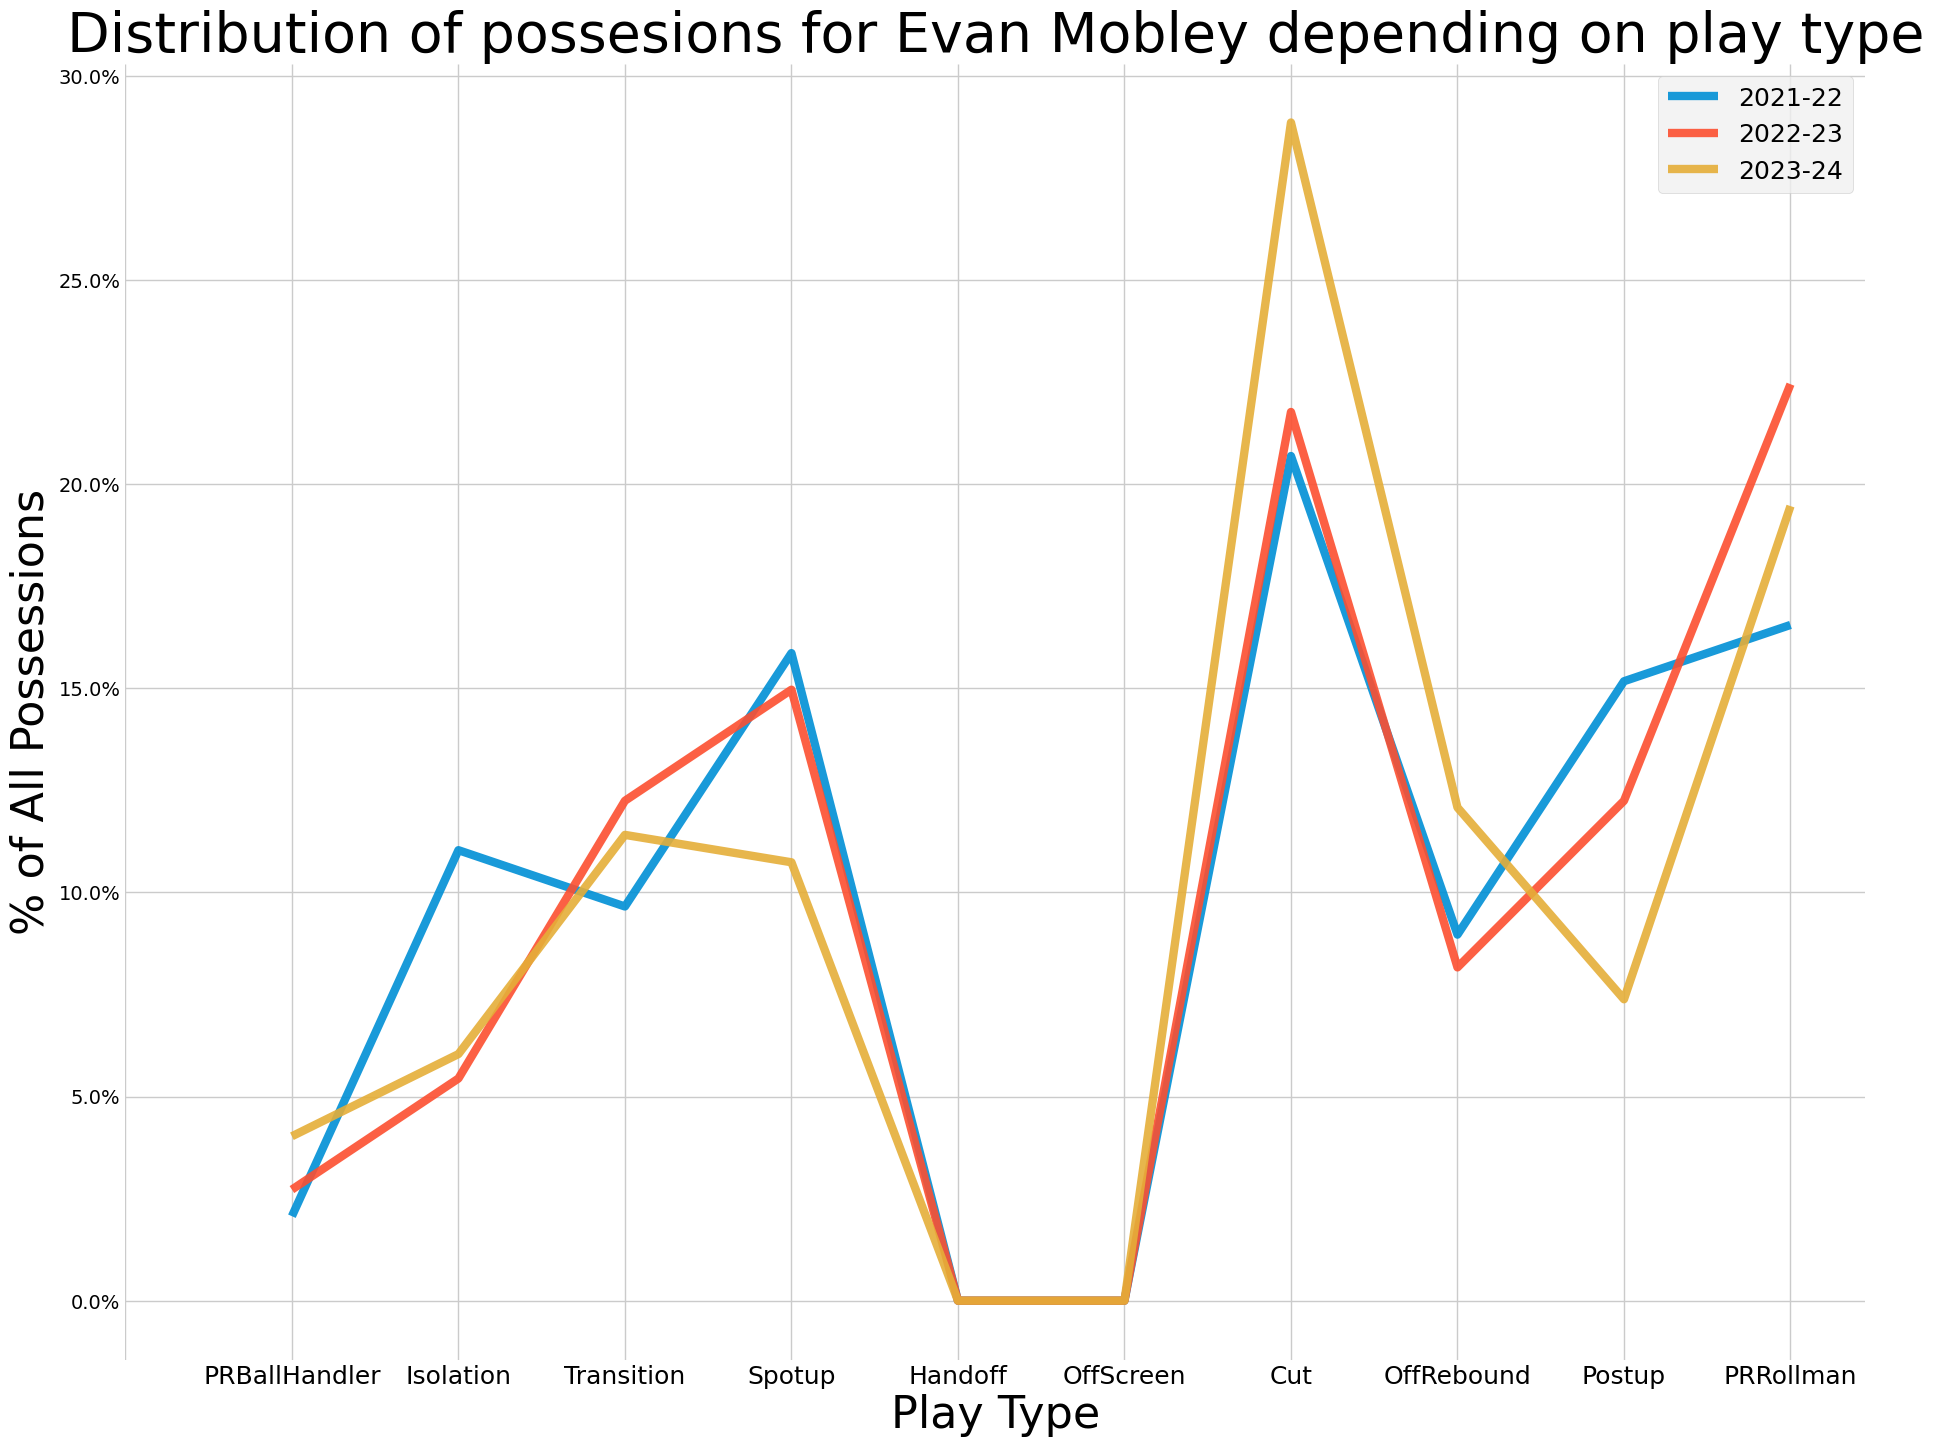

In [51]:
player_name = 'Evan Mobley'
play_type_seasons = get_data_for_player(player_name, seasons=seasons)
plot_line_chart(play_type_seasons, player_name)

C:\Users\danie\AppData\Local\Temp\ipykernel_2168\2347612155.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data.loc[: ,'SEASON'] = season
C:\Users\danie\AppData\Local\Temp\ipykernel_2168\2347612155.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data.loc[: ,'SEASON'] = season
C:\Users\danie\AppData\Local\Temp\ipykernel_2168\2347612155.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

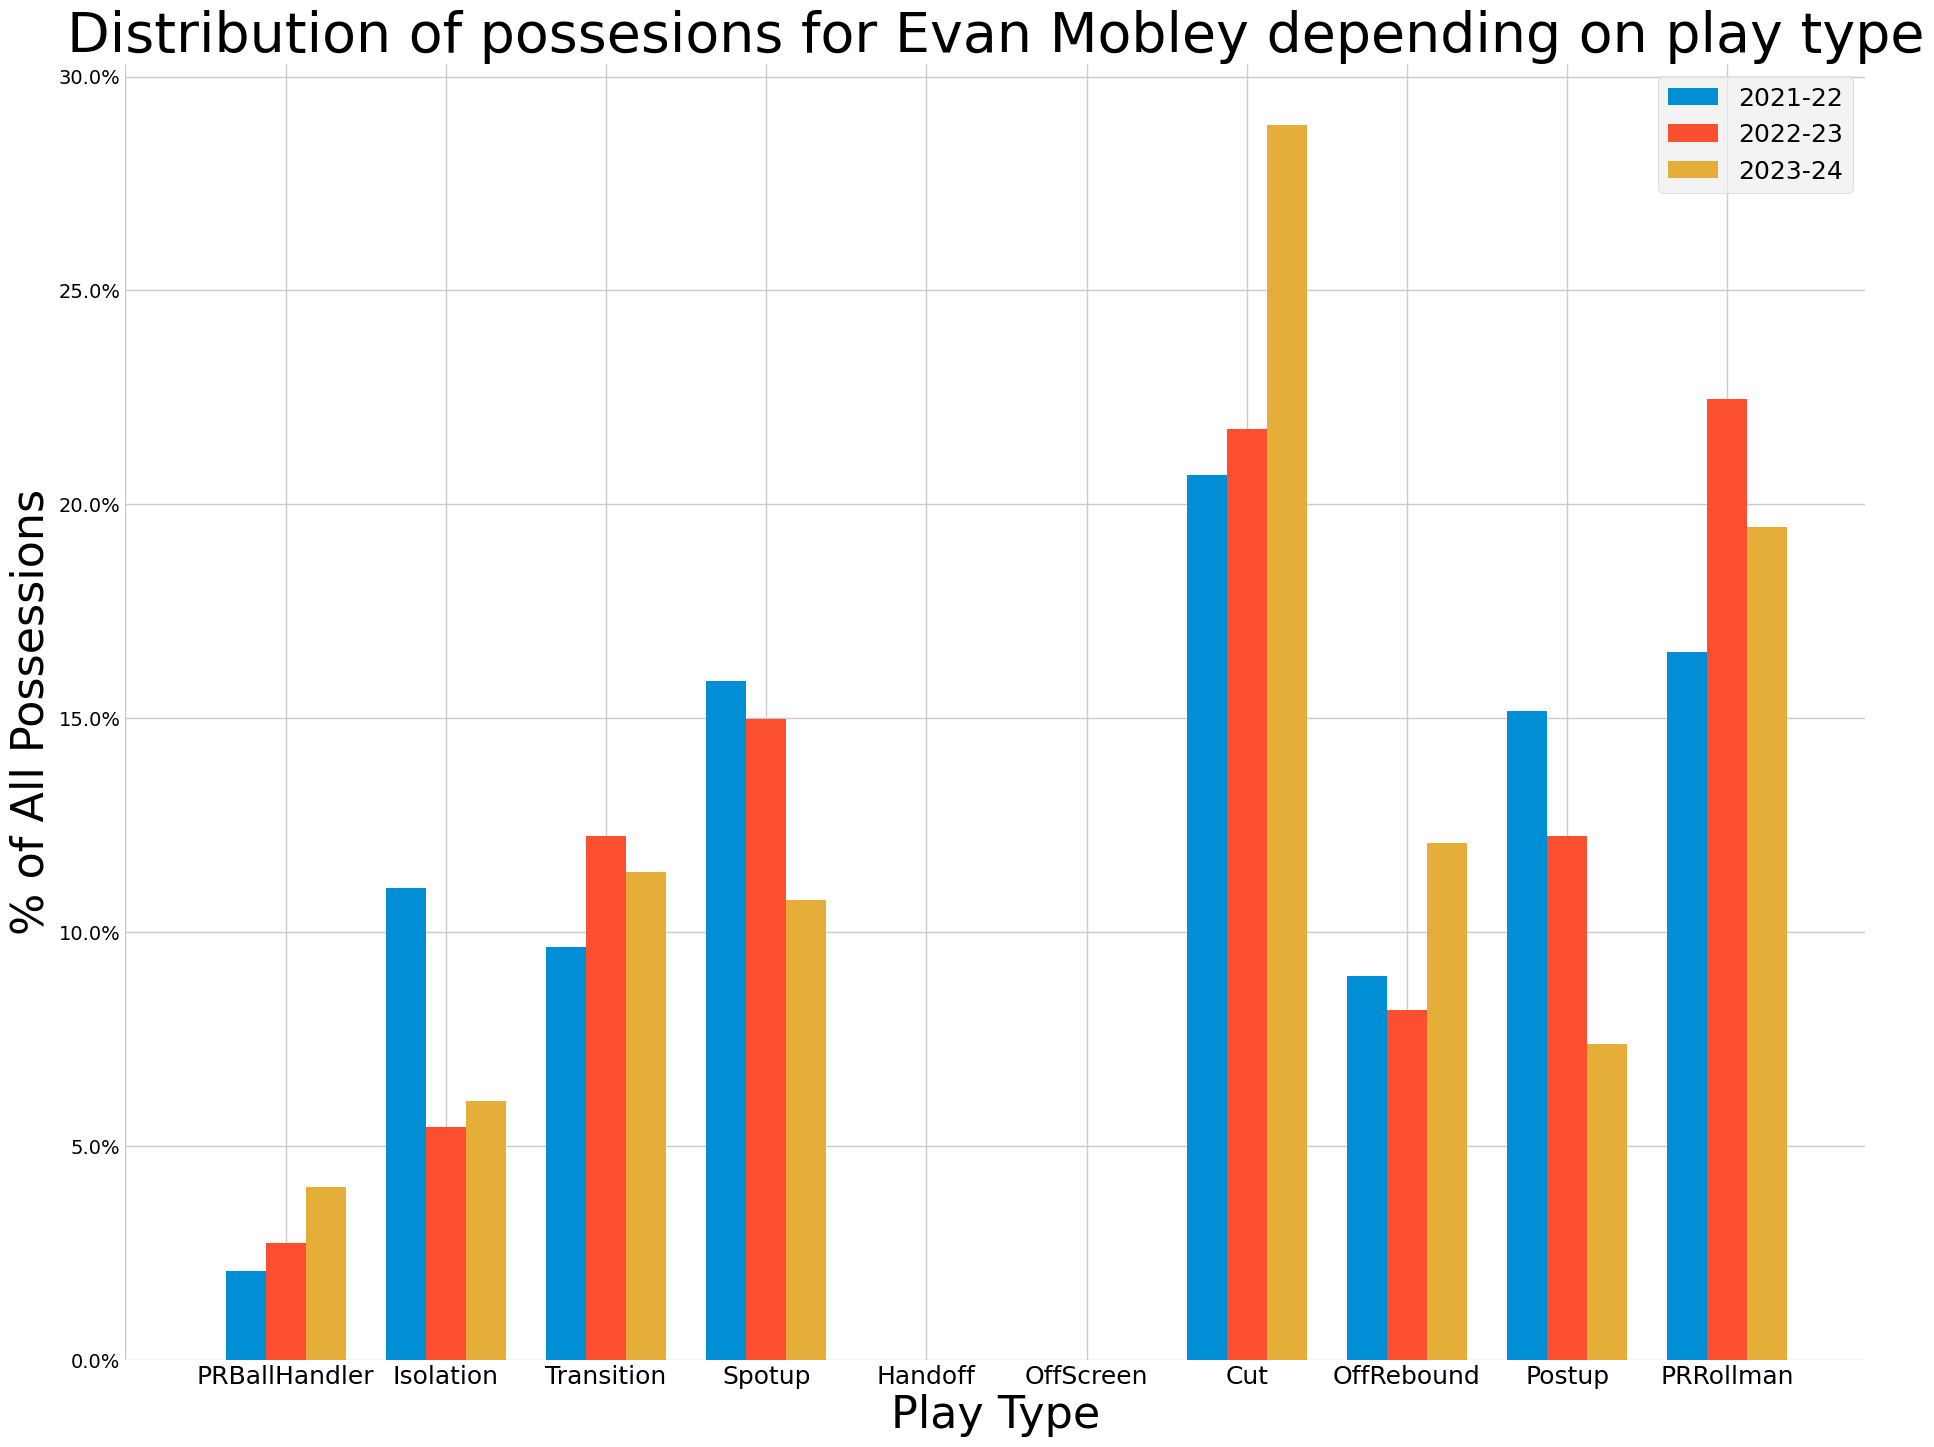

In [52]:
player_name = 'Evan Mobley'
play_type_seasons = get_data_for_player(player_name, seasons=seasons)
plot_bar_chart(play_type_seasons, player_name)

## Franz Wagner

C:\Users\danie\AppData\Local\Temp\ipykernel_2168\2347612155.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data.loc[: ,'SEASON'] = season
C:\Users\danie\AppData\Local\Temp\ipykernel_2168\2347612155.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data.loc[: ,'SEASON'] = season
C:\Users\danie\AppData\Local\Temp\ipykernel_2168\2347612155.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

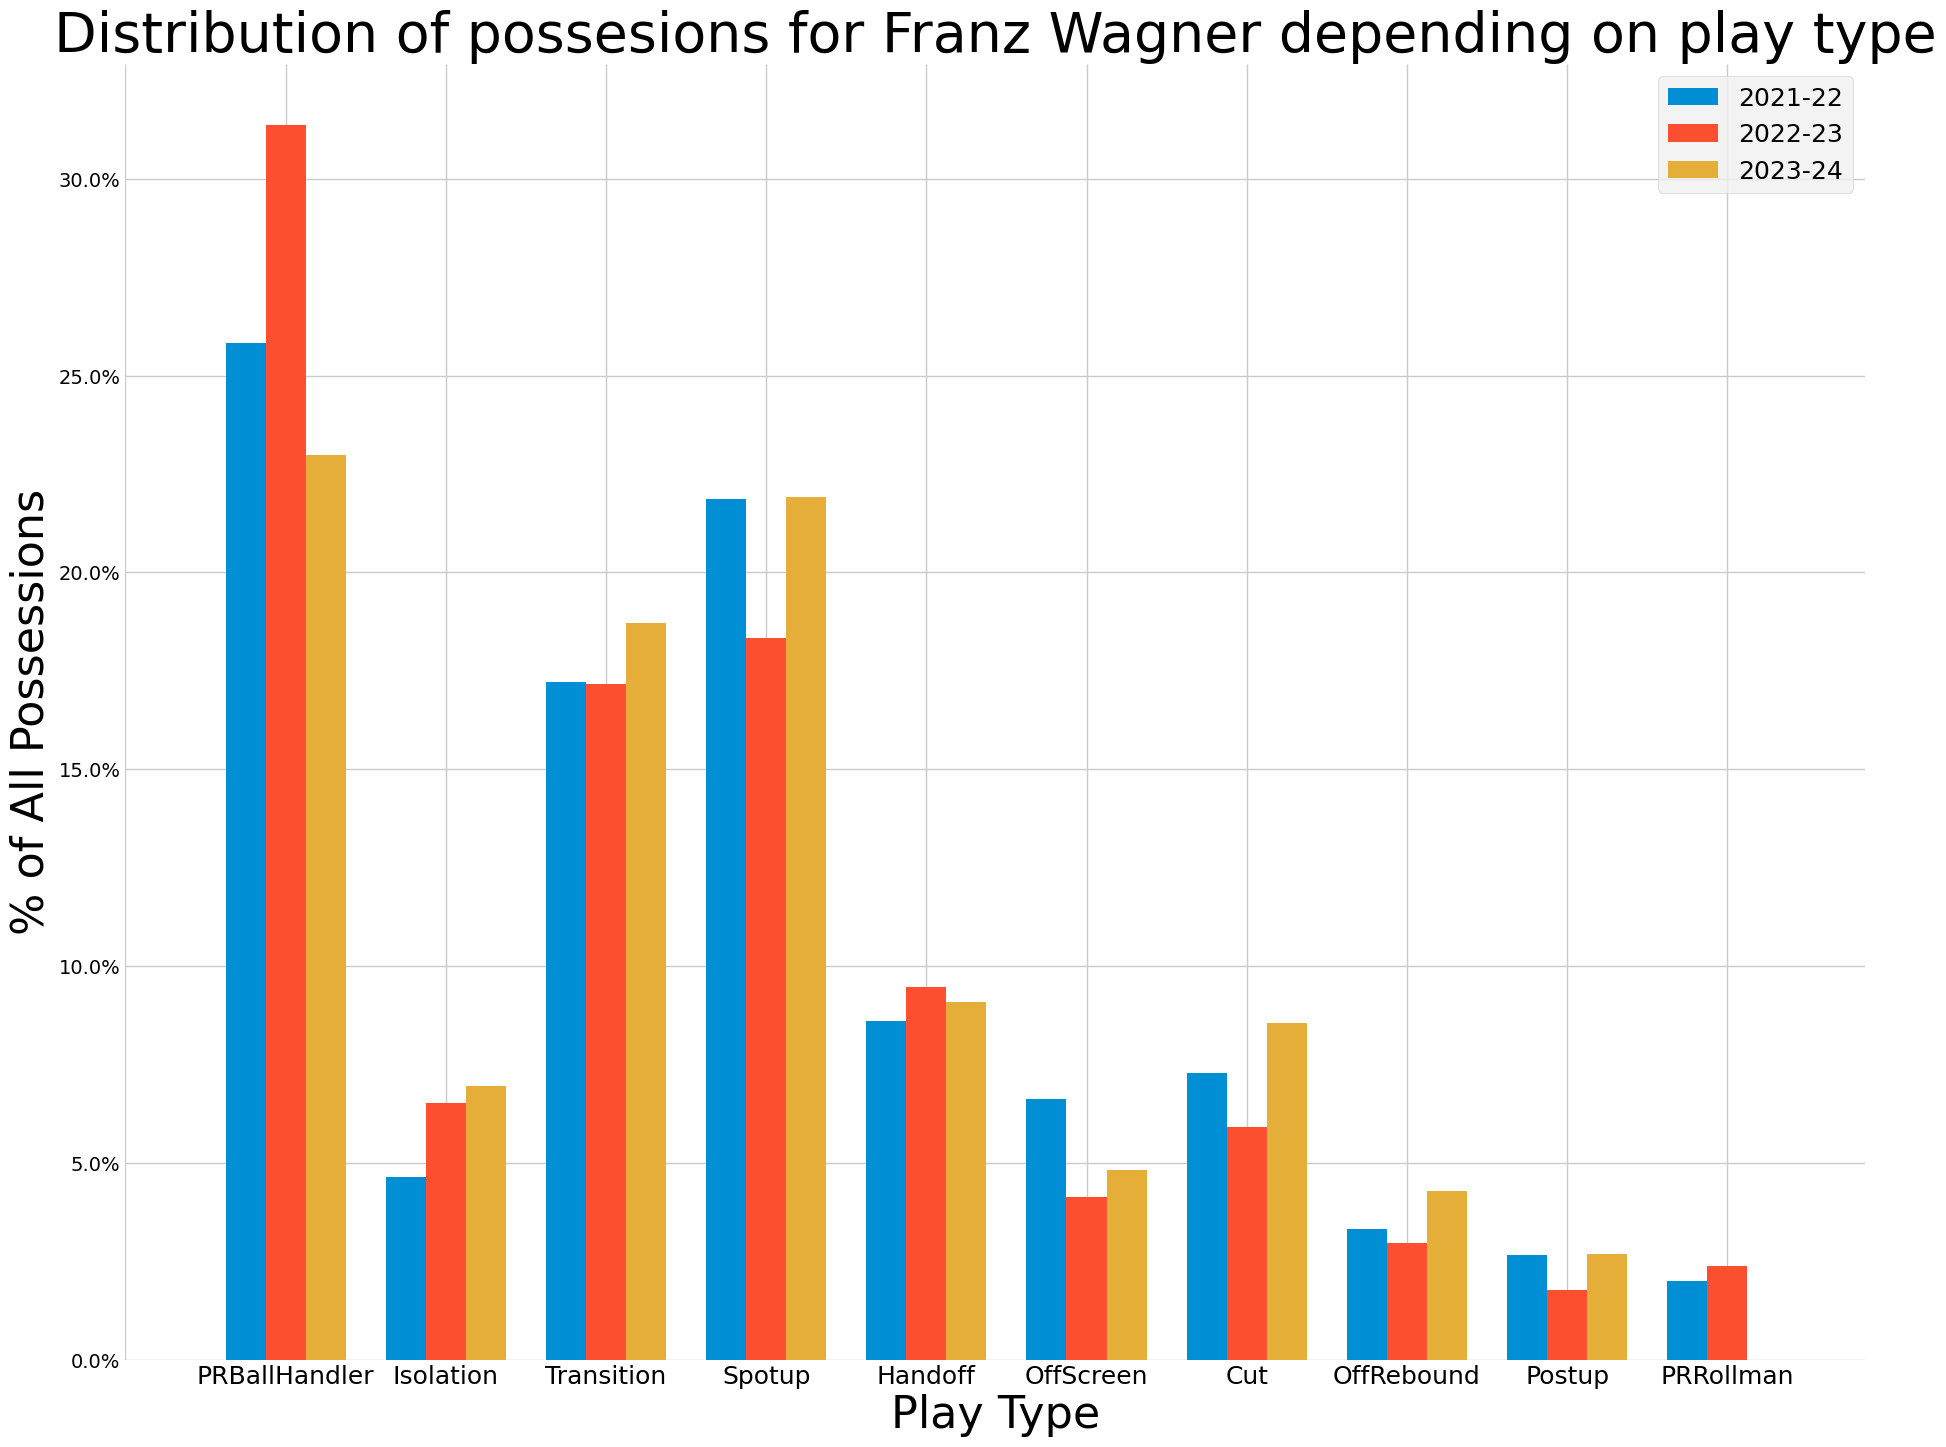

In [60]:
player_name = 'Franz Wagner'
play_type_seasons = get_data_for_player(player_name, seasons=seasons)
plot_bar_chart(play_type_seasons, player_name)


C:\Users\danie\AppData\Local\Temp\ipykernel_11848\1340230174.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data.loc[: ,'SEASON'] = season
C:\Users\danie\AppData\Local\Temp\ipykernel_11848\1340230174.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data.loc[: ,'SEASON'] = season
C:\Users\danie\AppData\Local\Temp\ipykernel_11848\1340230174.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

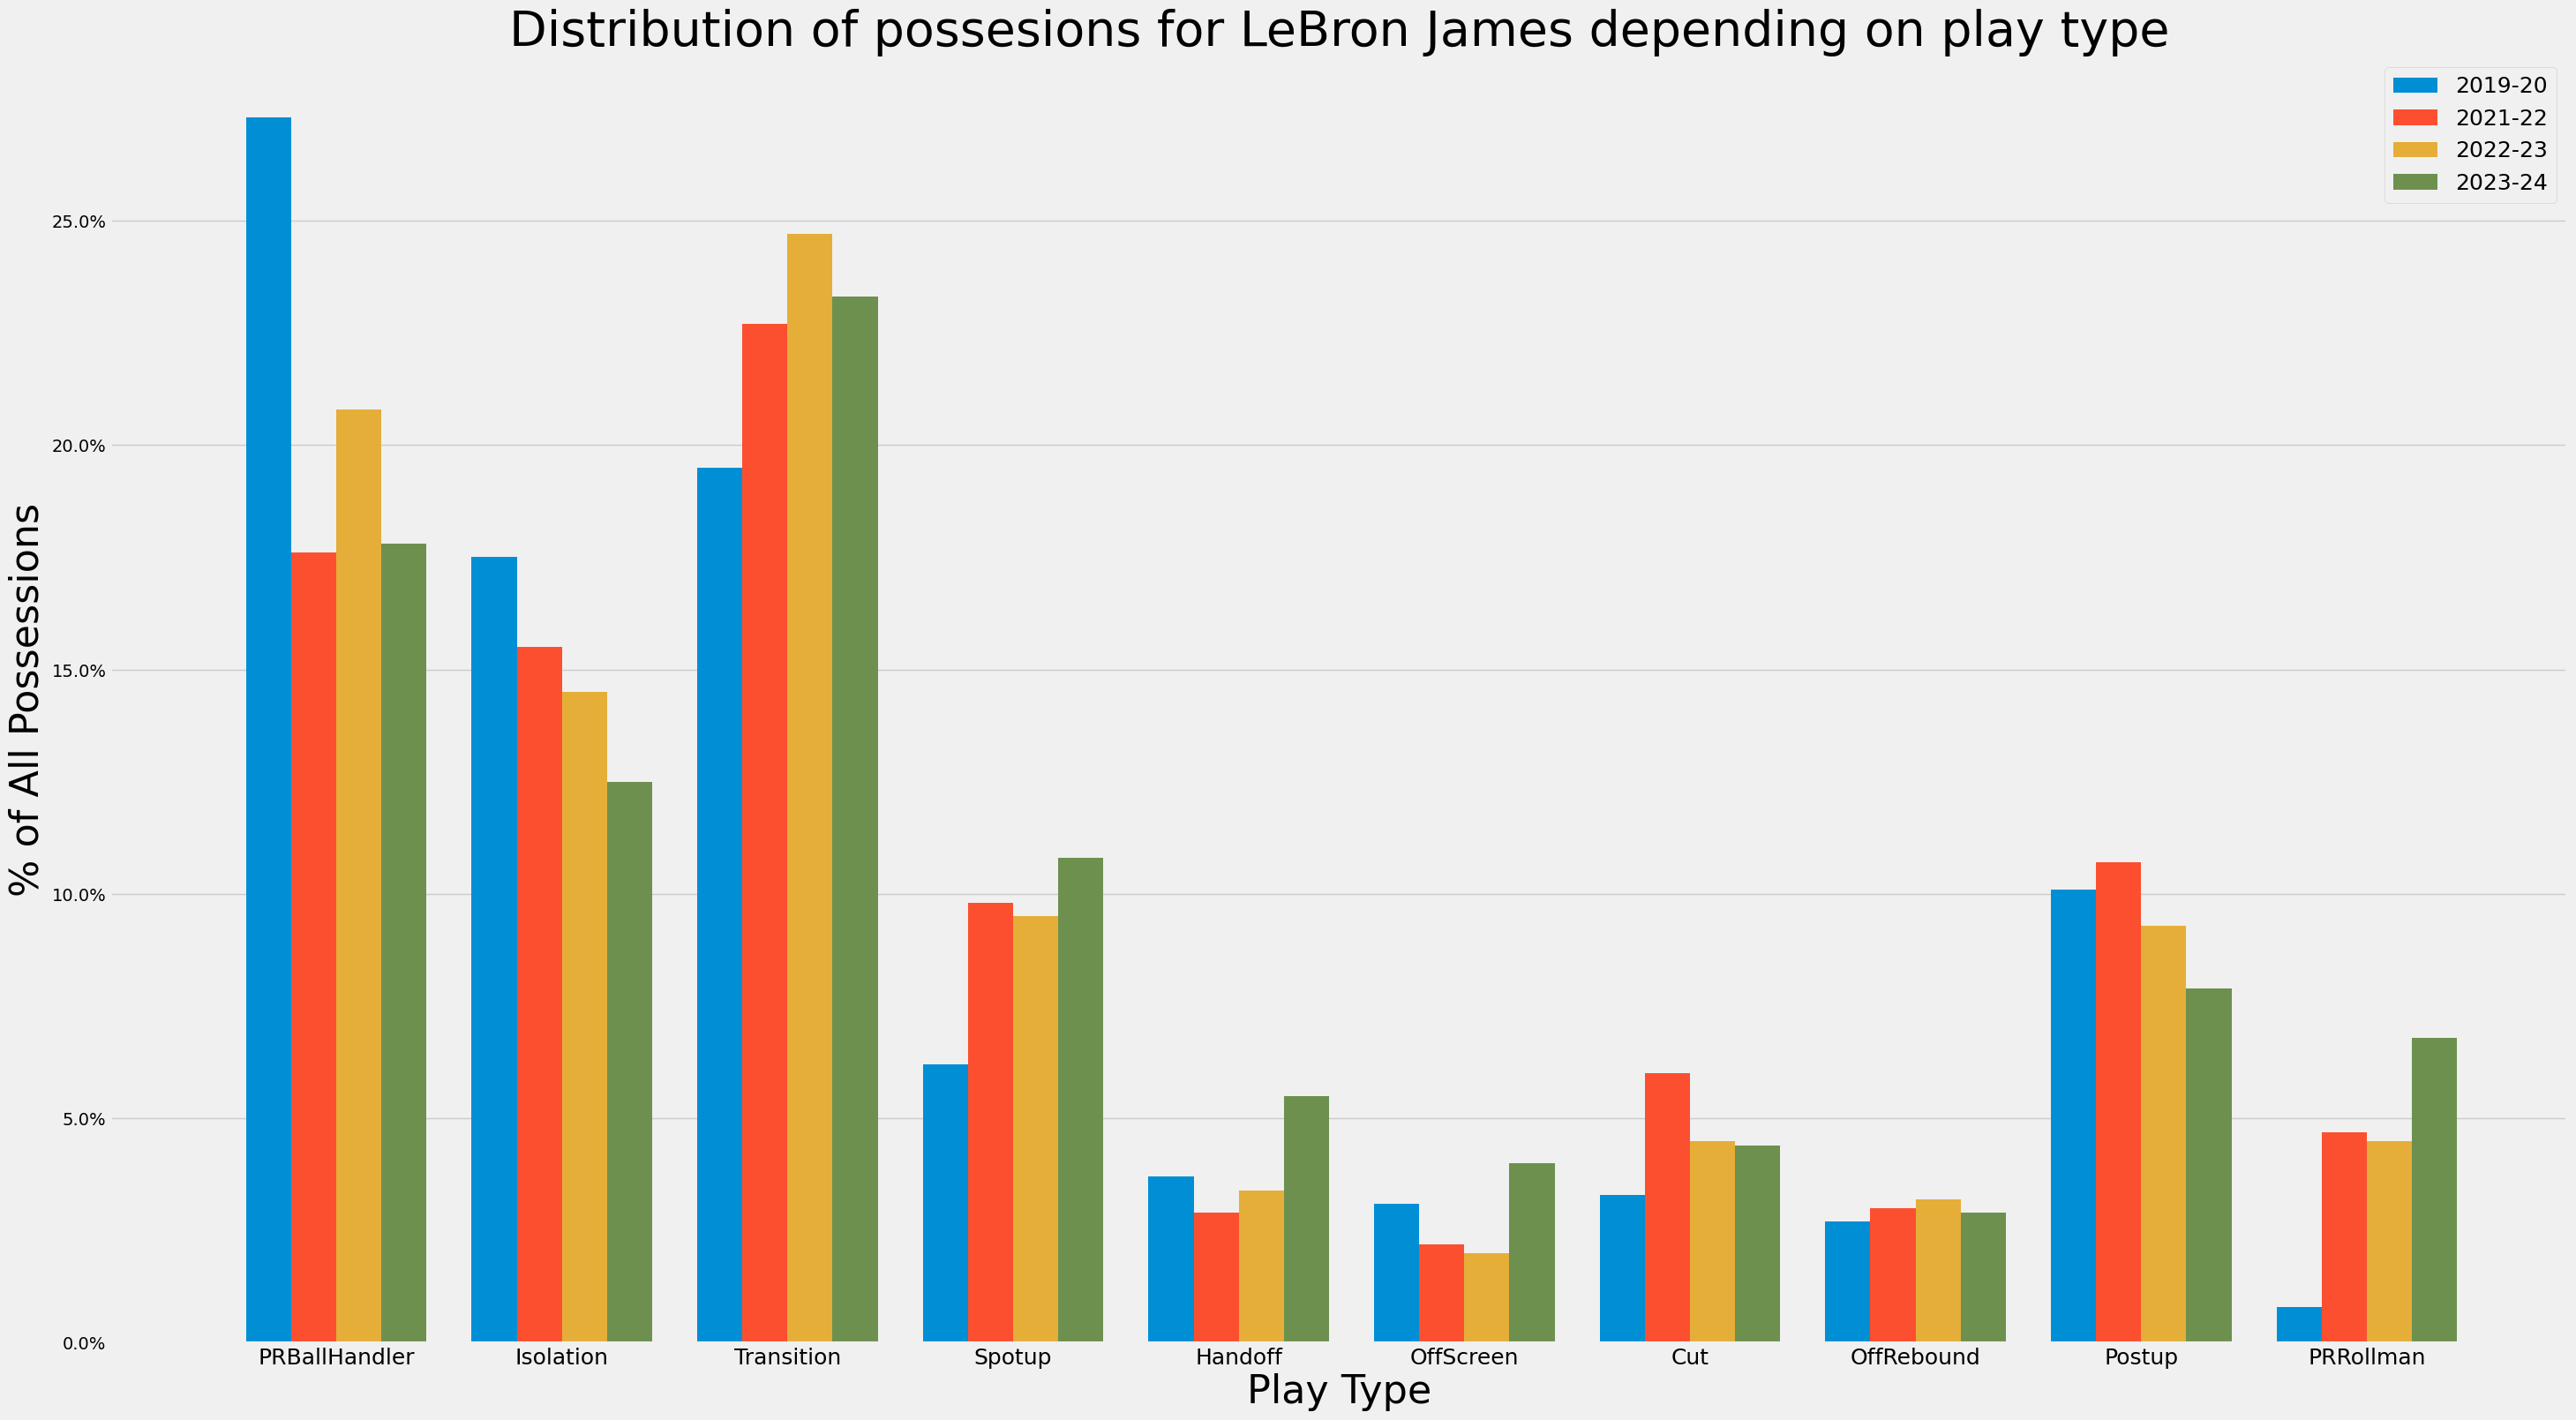

In [200]:
player_name = 'LeBron James'
play_type_seasons = get_data_for_player(player_name, seasons=['2019-20', '2021-22', '2022-23', '2023-24'])
plot_bar_chart_non_white(play_type_seasons, "Distribution of possesions for LeBron James depending on play type")
#plt.savefig('podcast_ideje/lebron_play_types.png')

C:\Users\danie\AppData\Local\Temp\ipykernel_11848\1340230174.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data.loc[: ,'SEASON'] = season
C:\Users\danie\AppData\Local\Temp\ipykernel_11848\1340230174.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data.loc[: ,'SEASON'] = season
C:\Users\danie\AppData\Local\Temp\ipykernel_11848\1340230174.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

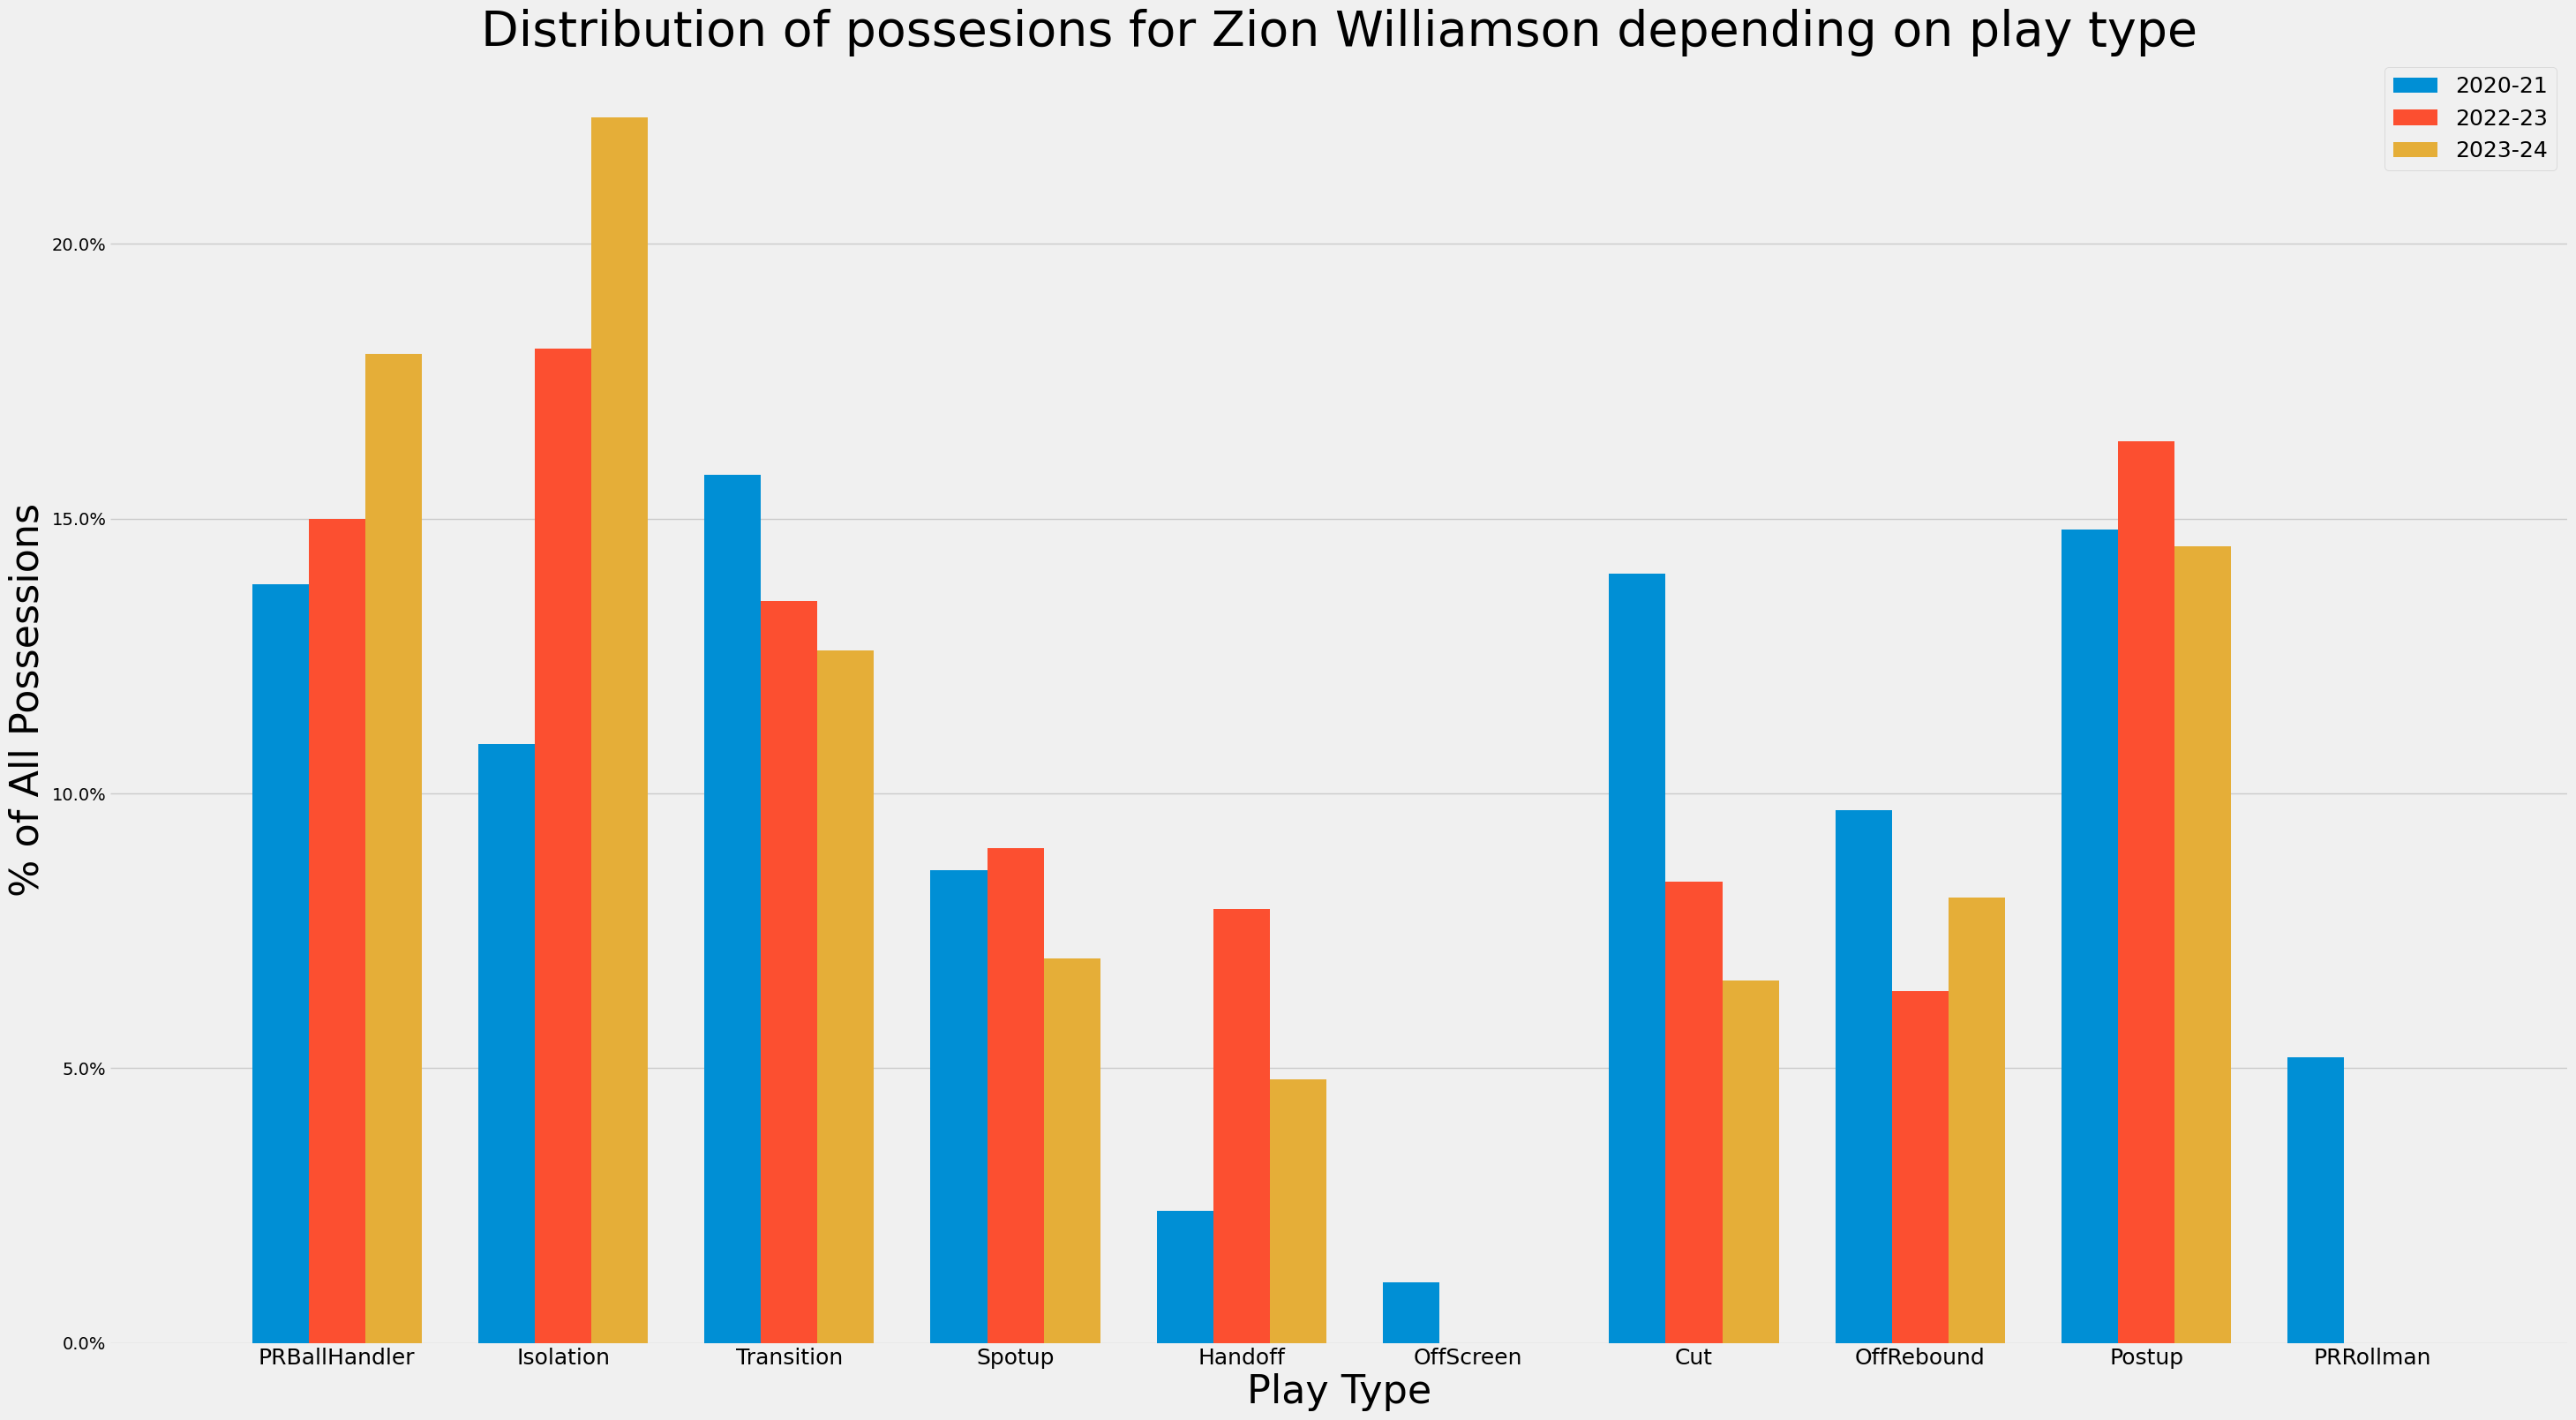

In [201]:
player_name = 'Zion Williamson'
play_type_seasons = get_data_for_player(player_name, seasons=['2020-21', '2022-23', '2023-24'])
plot_bar_chart_non_white(play_type_seasons, f"Distribution of possesions for {player_name} depending on play type")
plt.gca().set_frame_on(False)
plt.savefig('podcast_ideje/zion_play_types.png')

C:\Users\danie\AppData\Local\Temp\ipykernel_11848\1340230174.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data.loc[: ,'SEASON'] = season
C:\Users\danie\AppData\Local\Temp\ipykernel_11848\1340230174.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data.loc[: ,'SEASON'] = season
C:\Users\danie\AppData\Local\Temp\ipykernel_11848\1340230174.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

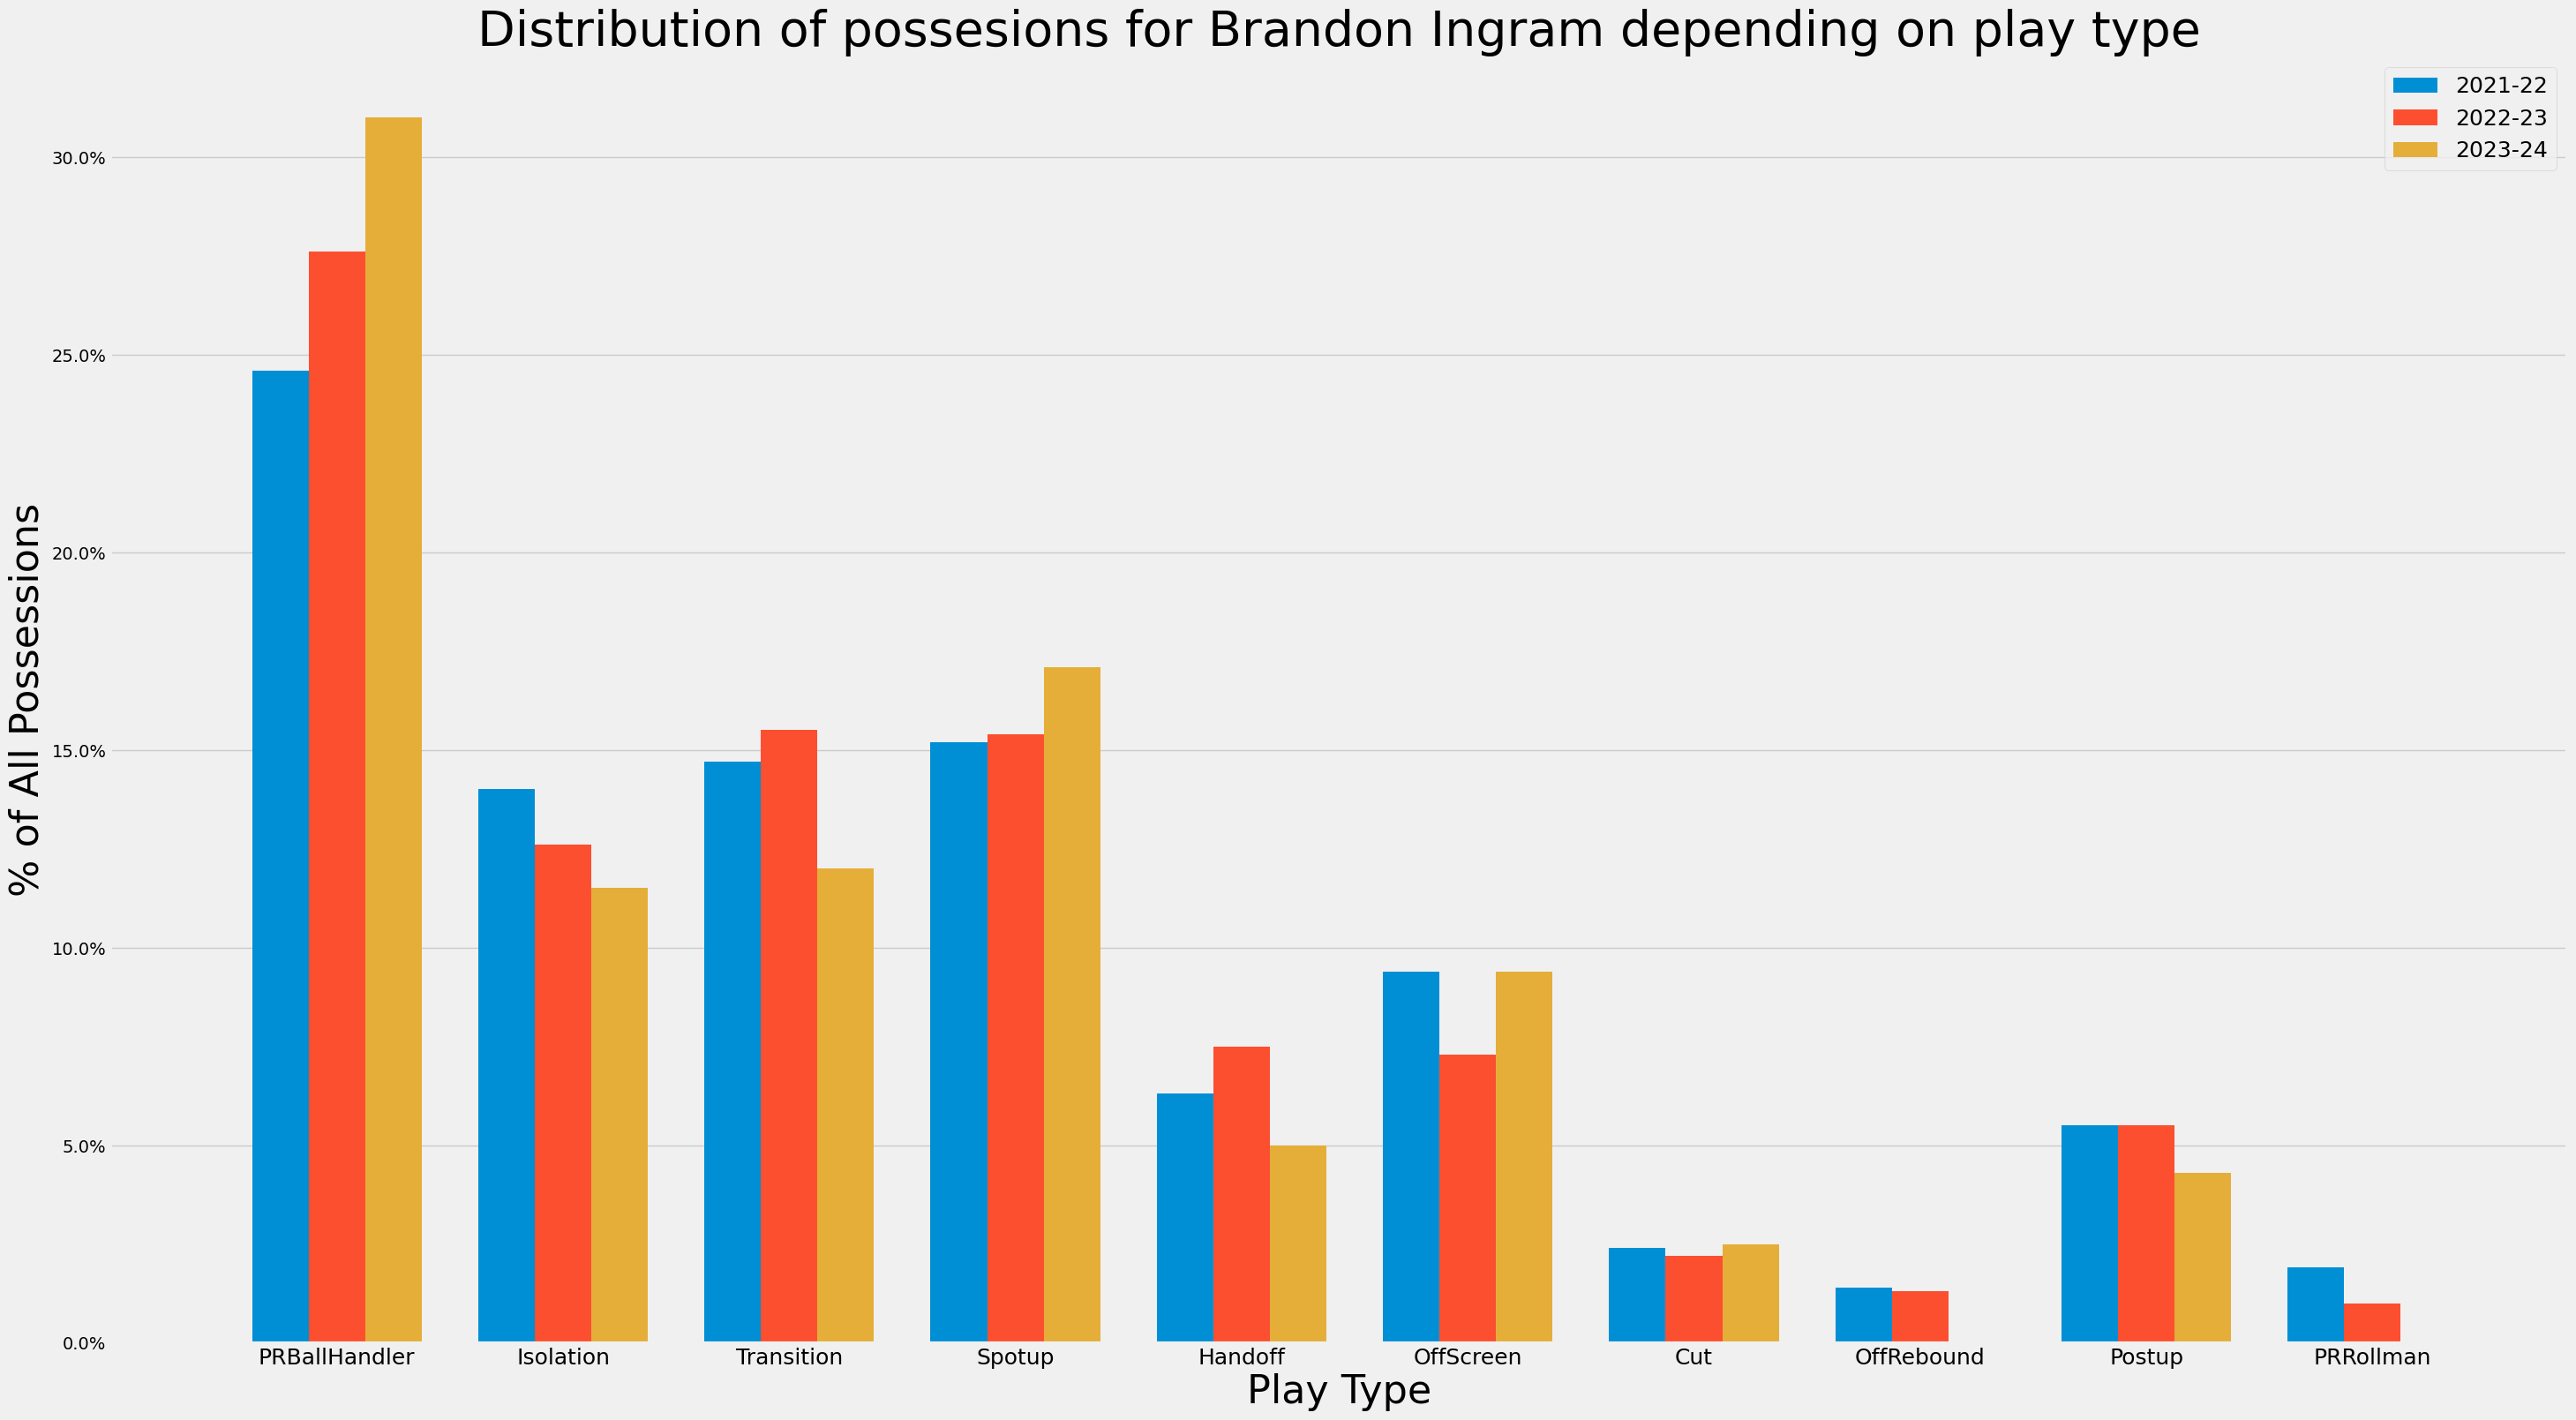

In [202]:
player_name = 'Brandon Ingram'
play_type_seasons = get_data_for_player(player_name, seasons=['2021-22', '2022-23', '2023-24'])
plot_bar_chart_non_white(play_type_seasons, f"Distribution of possesions for {player_name} depending on play type")
plt.savefig('podcast_ideje/ingram_play_types.png')

## Pelicans

In [204]:
play_type_players = get_data_for_players(['Brandon Ingram', 'Zion Williamson', 'CJ McCollum'], season='2023-24')


C:\Users\danie\AppData\Local\Temp\ipykernel_11848\2398590726.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + [item.split("POSS_PCT_")[1] for item in list(labels)], size=18)


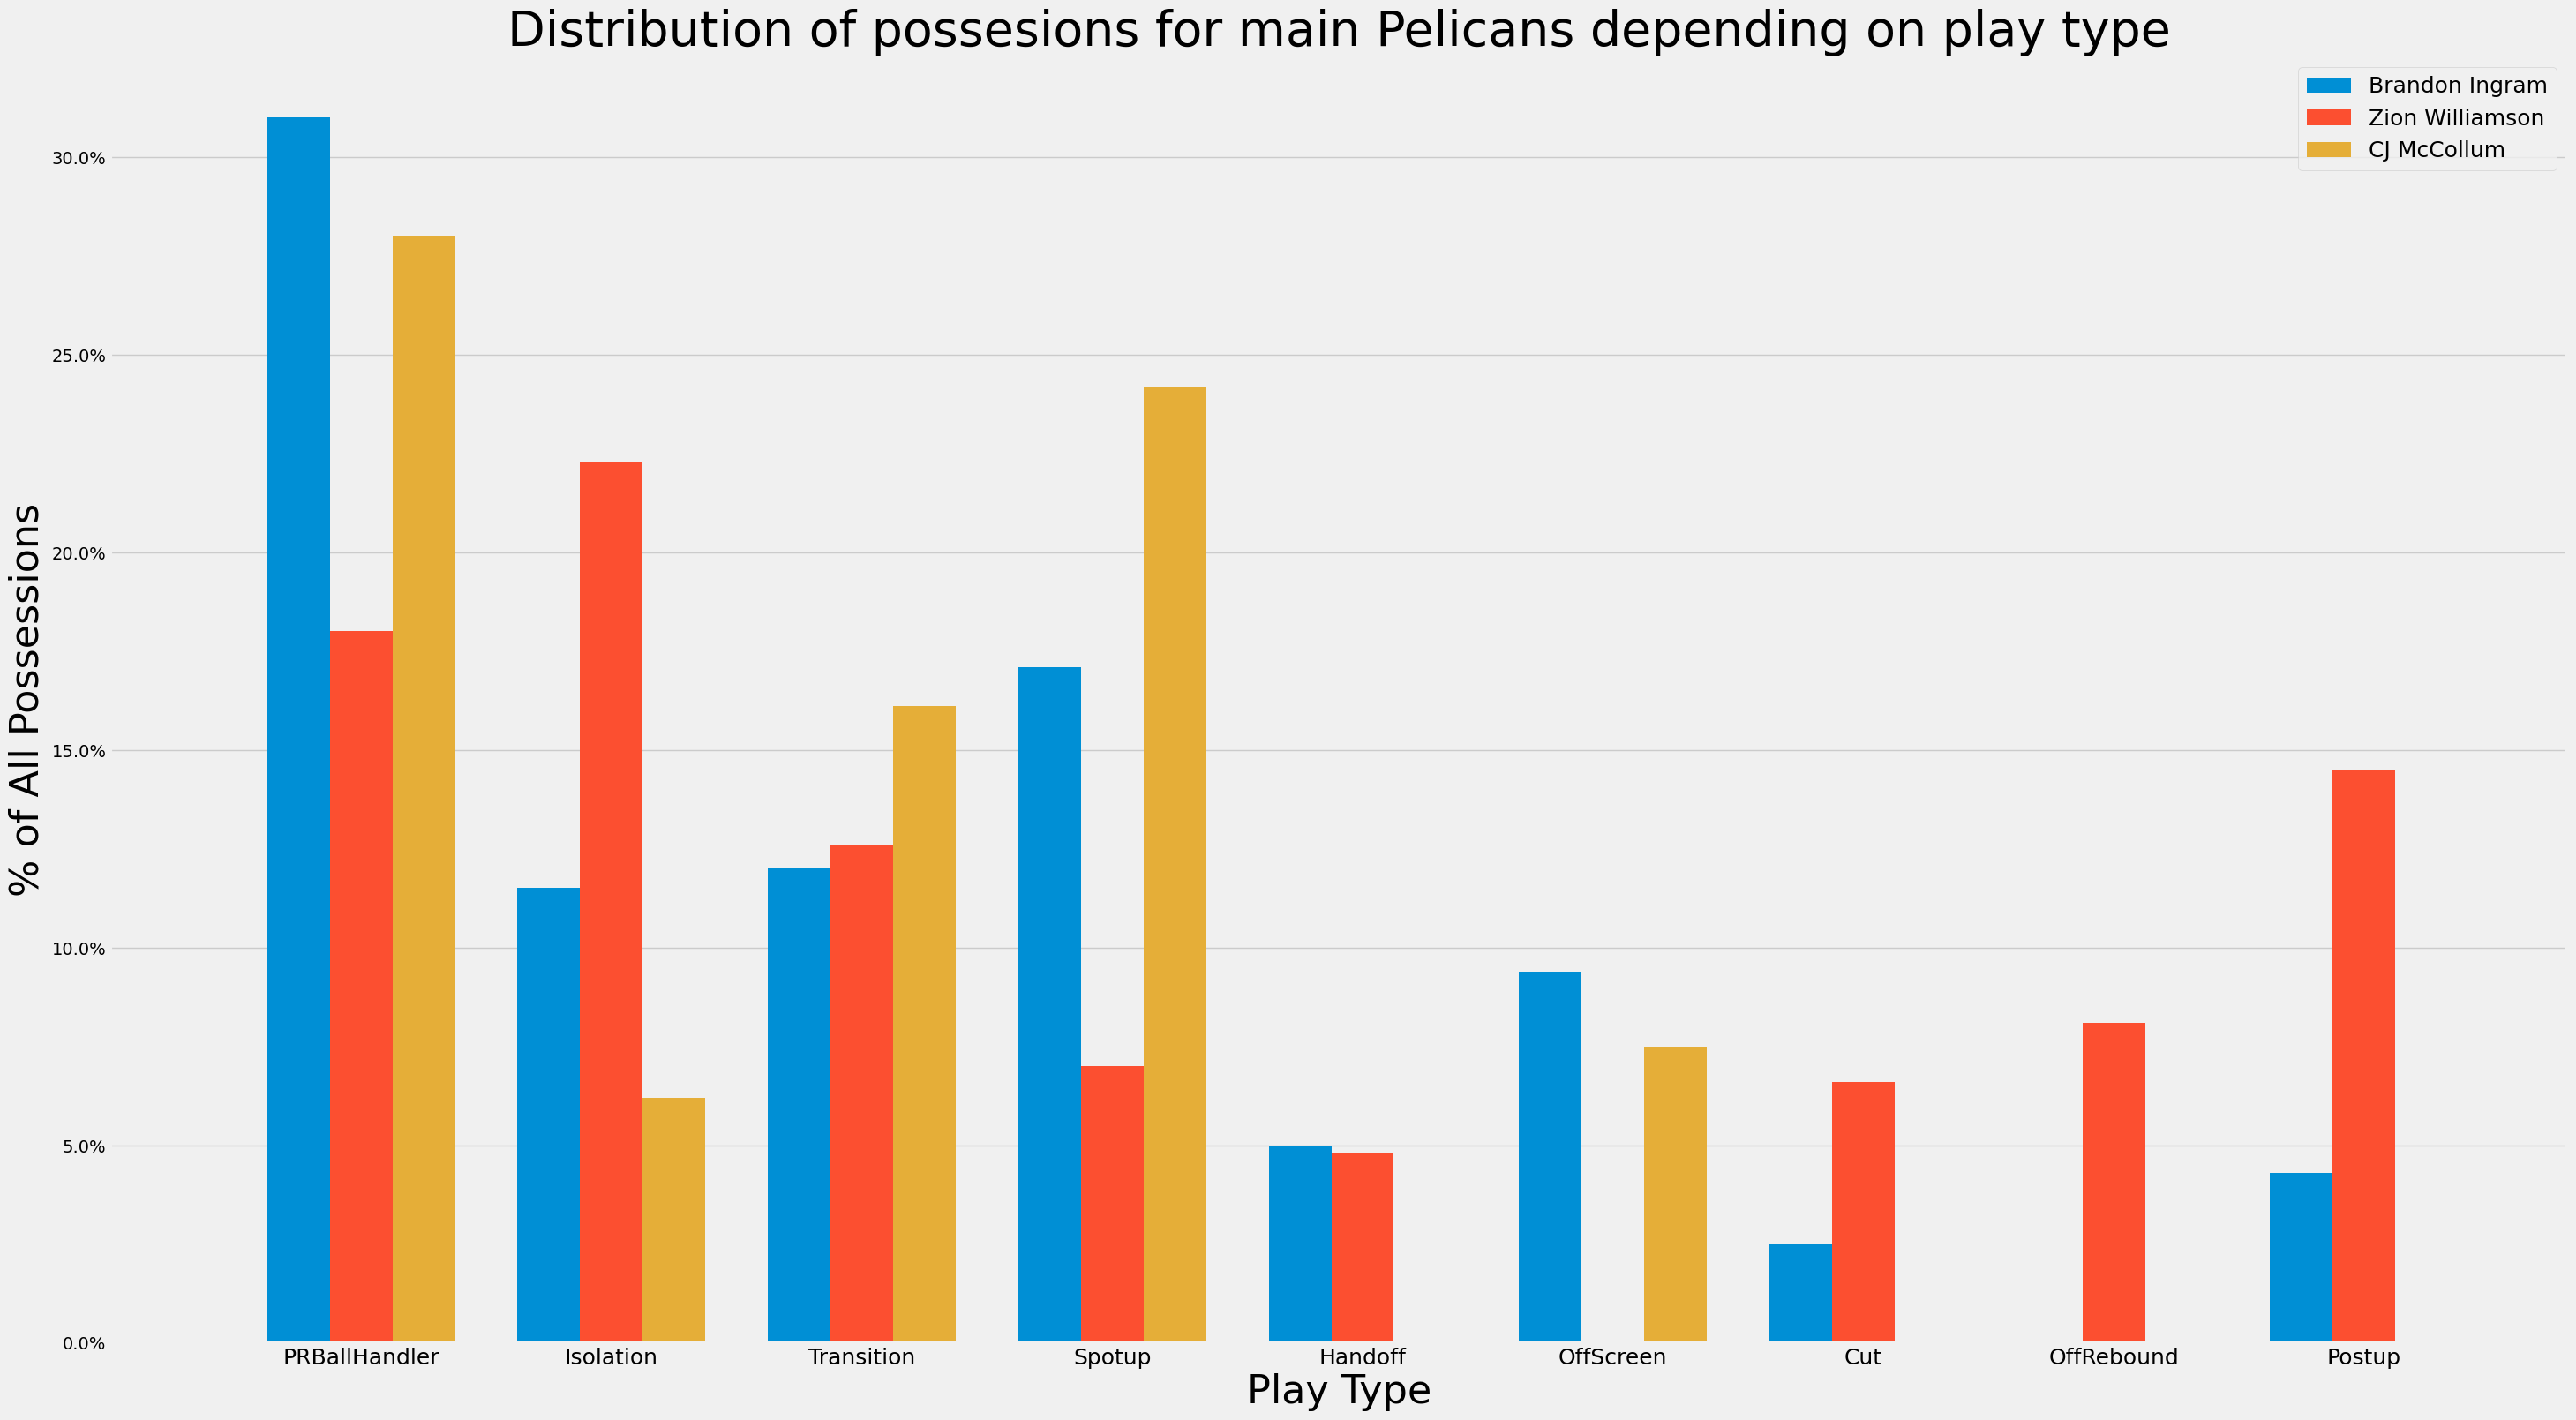

In [205]:

plot_bar_chart_non_white(play_type_players, "Distribution of possesions for main Pelicans depending on play type")
plt.savefig('podcast_ideje/pelicans_play_types.png')

## Bam Adebayo

C:\Users\danie\AppData\Local\Temp\ipykernel_11848\1340230174.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data.loc[: ,'SEASON'] = season
C:\Users\danie\AppData\Local\Temp\ipykernel_11848\1340230174.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data.loc[: ,'SEASON'] = season
C:\Users\danie\AppData\Local\Temp\ipykernel_11848\1340230174.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

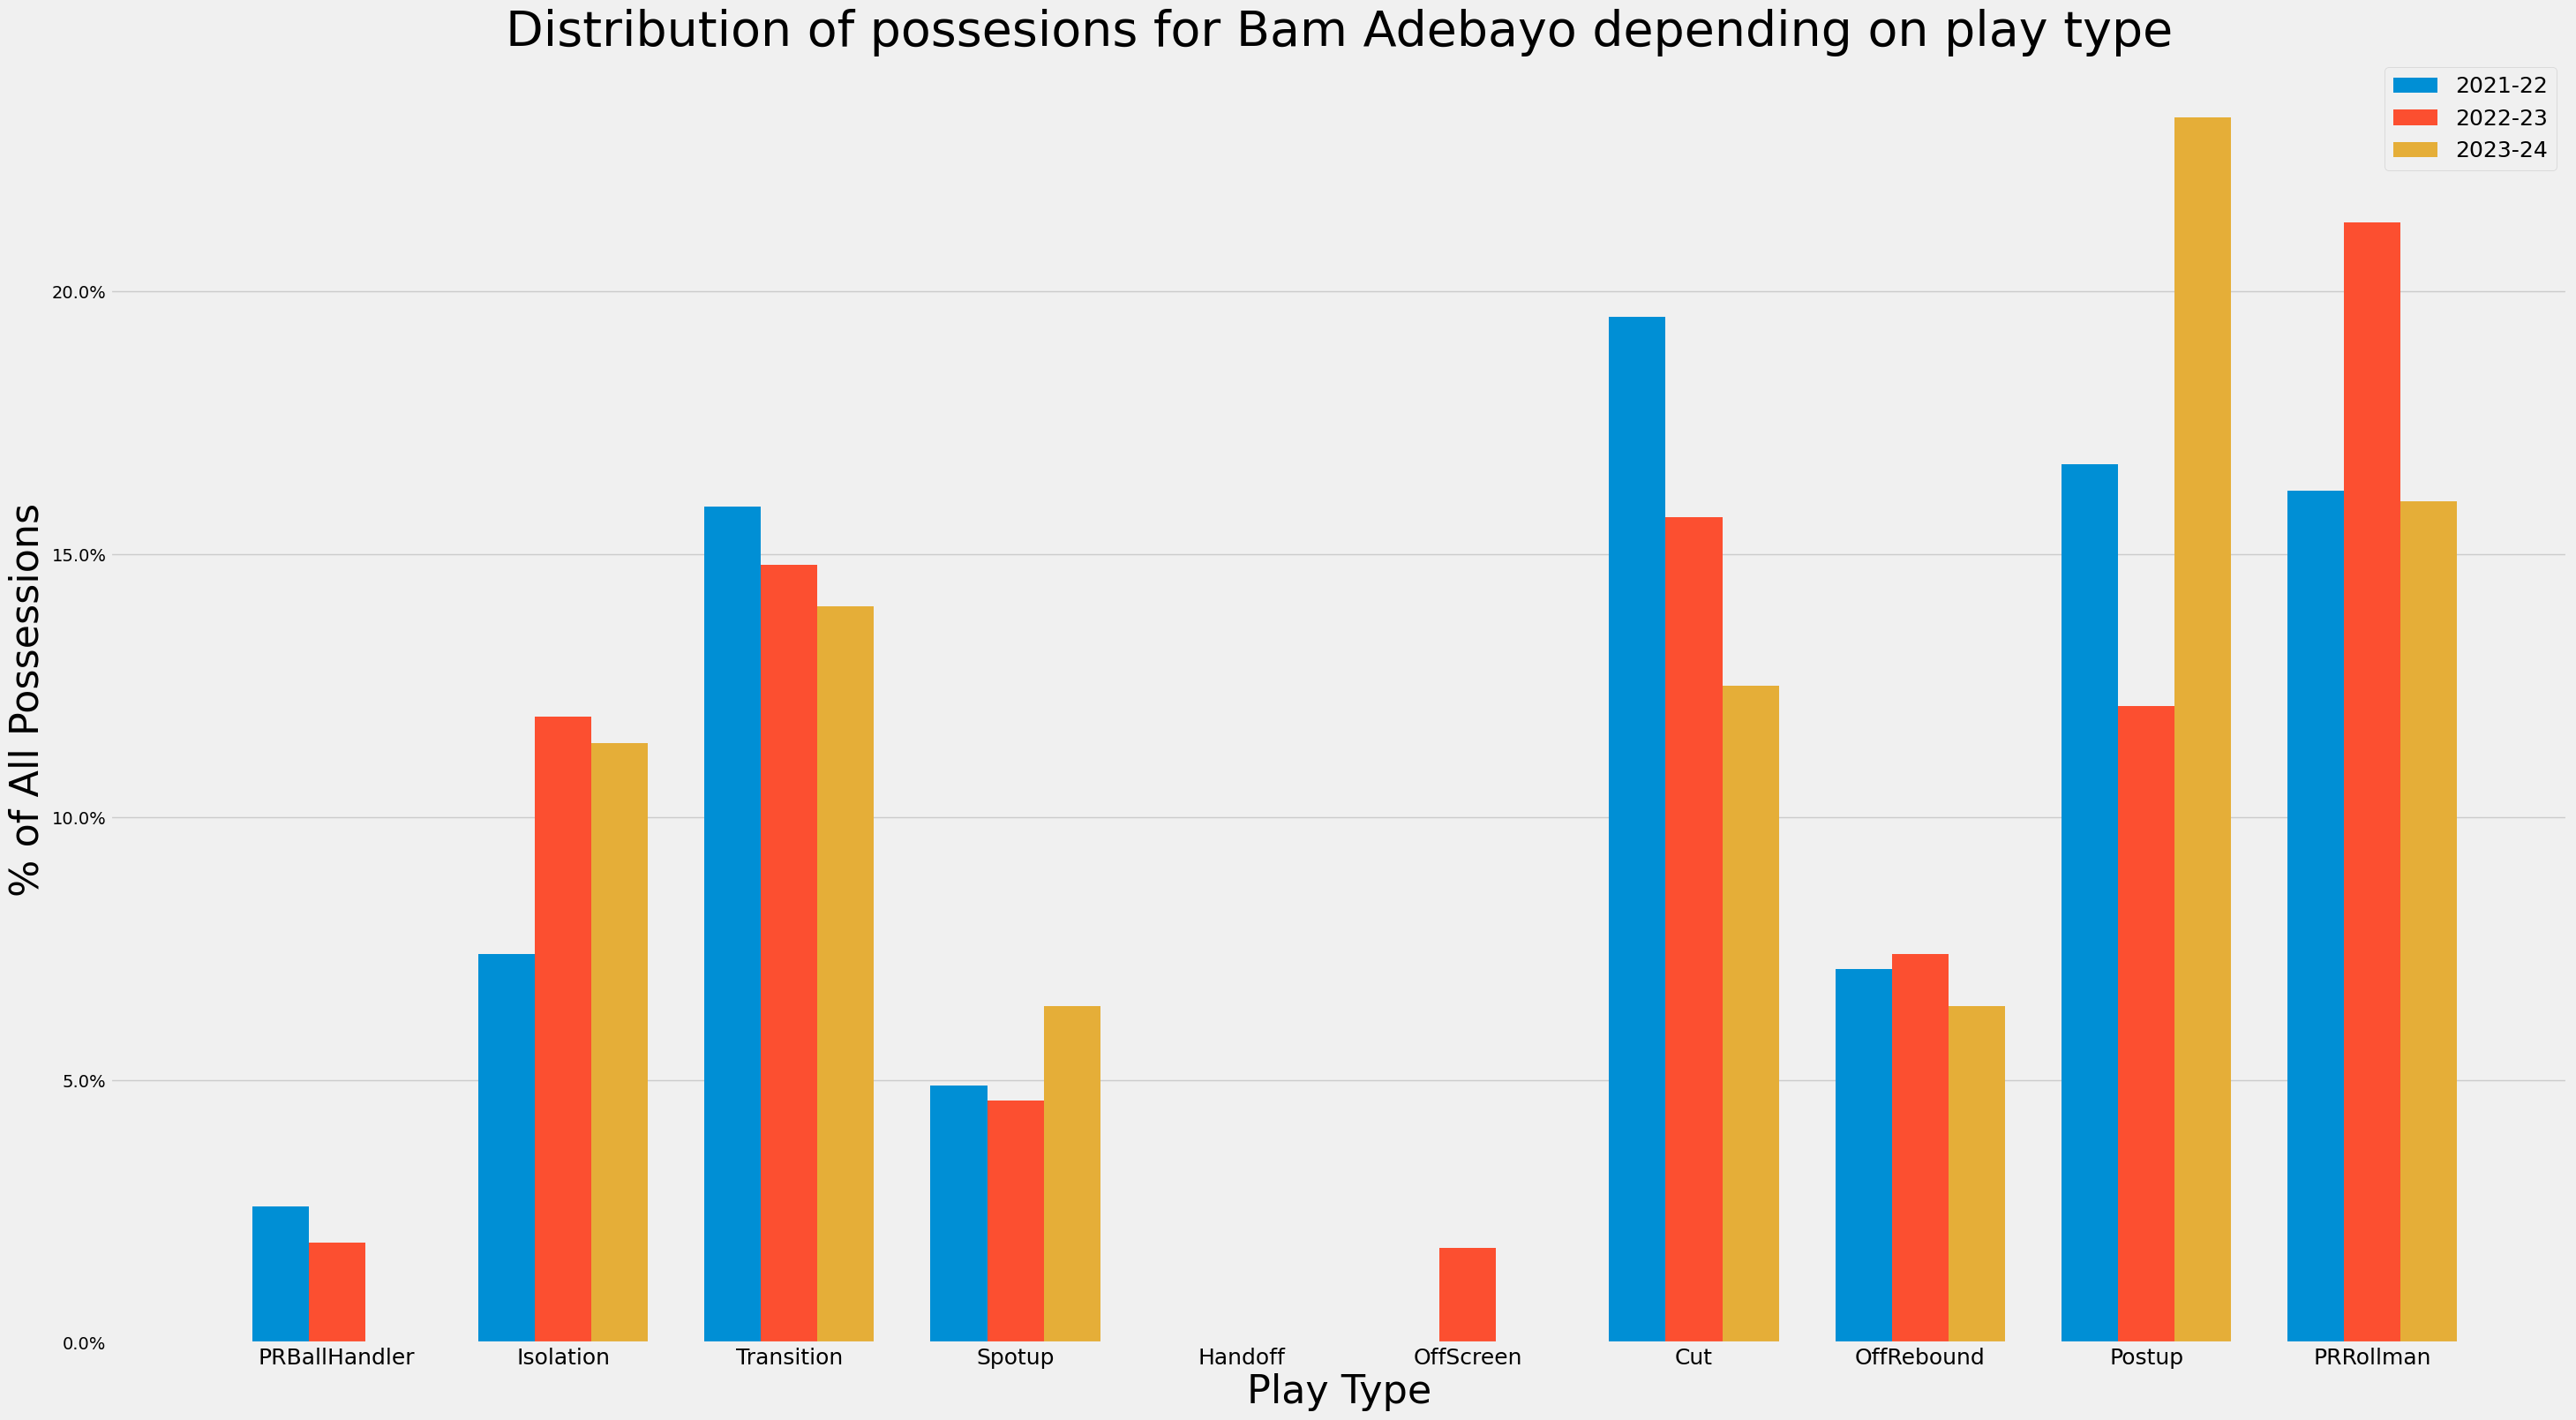

In [206]:
player_name = 'Bam Adebayo'
play_type_seasons = get_data_for_player(player_name, seasons=['2021-22', '2022-23', '2023-24'])
plot_bar_chart_non_white(play_type_seasons, f"Distribution of possesions for {player_name} depending on play type")
plt.savefig('podcast_ideje/adebayo_play_types.png')

C:\Users\danie\AppData\Local\Temp\ipykernel_11848\1340230174.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data.loc[: ,'SEASON'] = season
C:\Users\danie\AppData\Local\Temp\ipykernel_11848\1340230174.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data.loc[: ,'SEASON'] = season
C:\Users\danie\AppData\Local\Temp\ipykernel_11848\2398590726.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xti

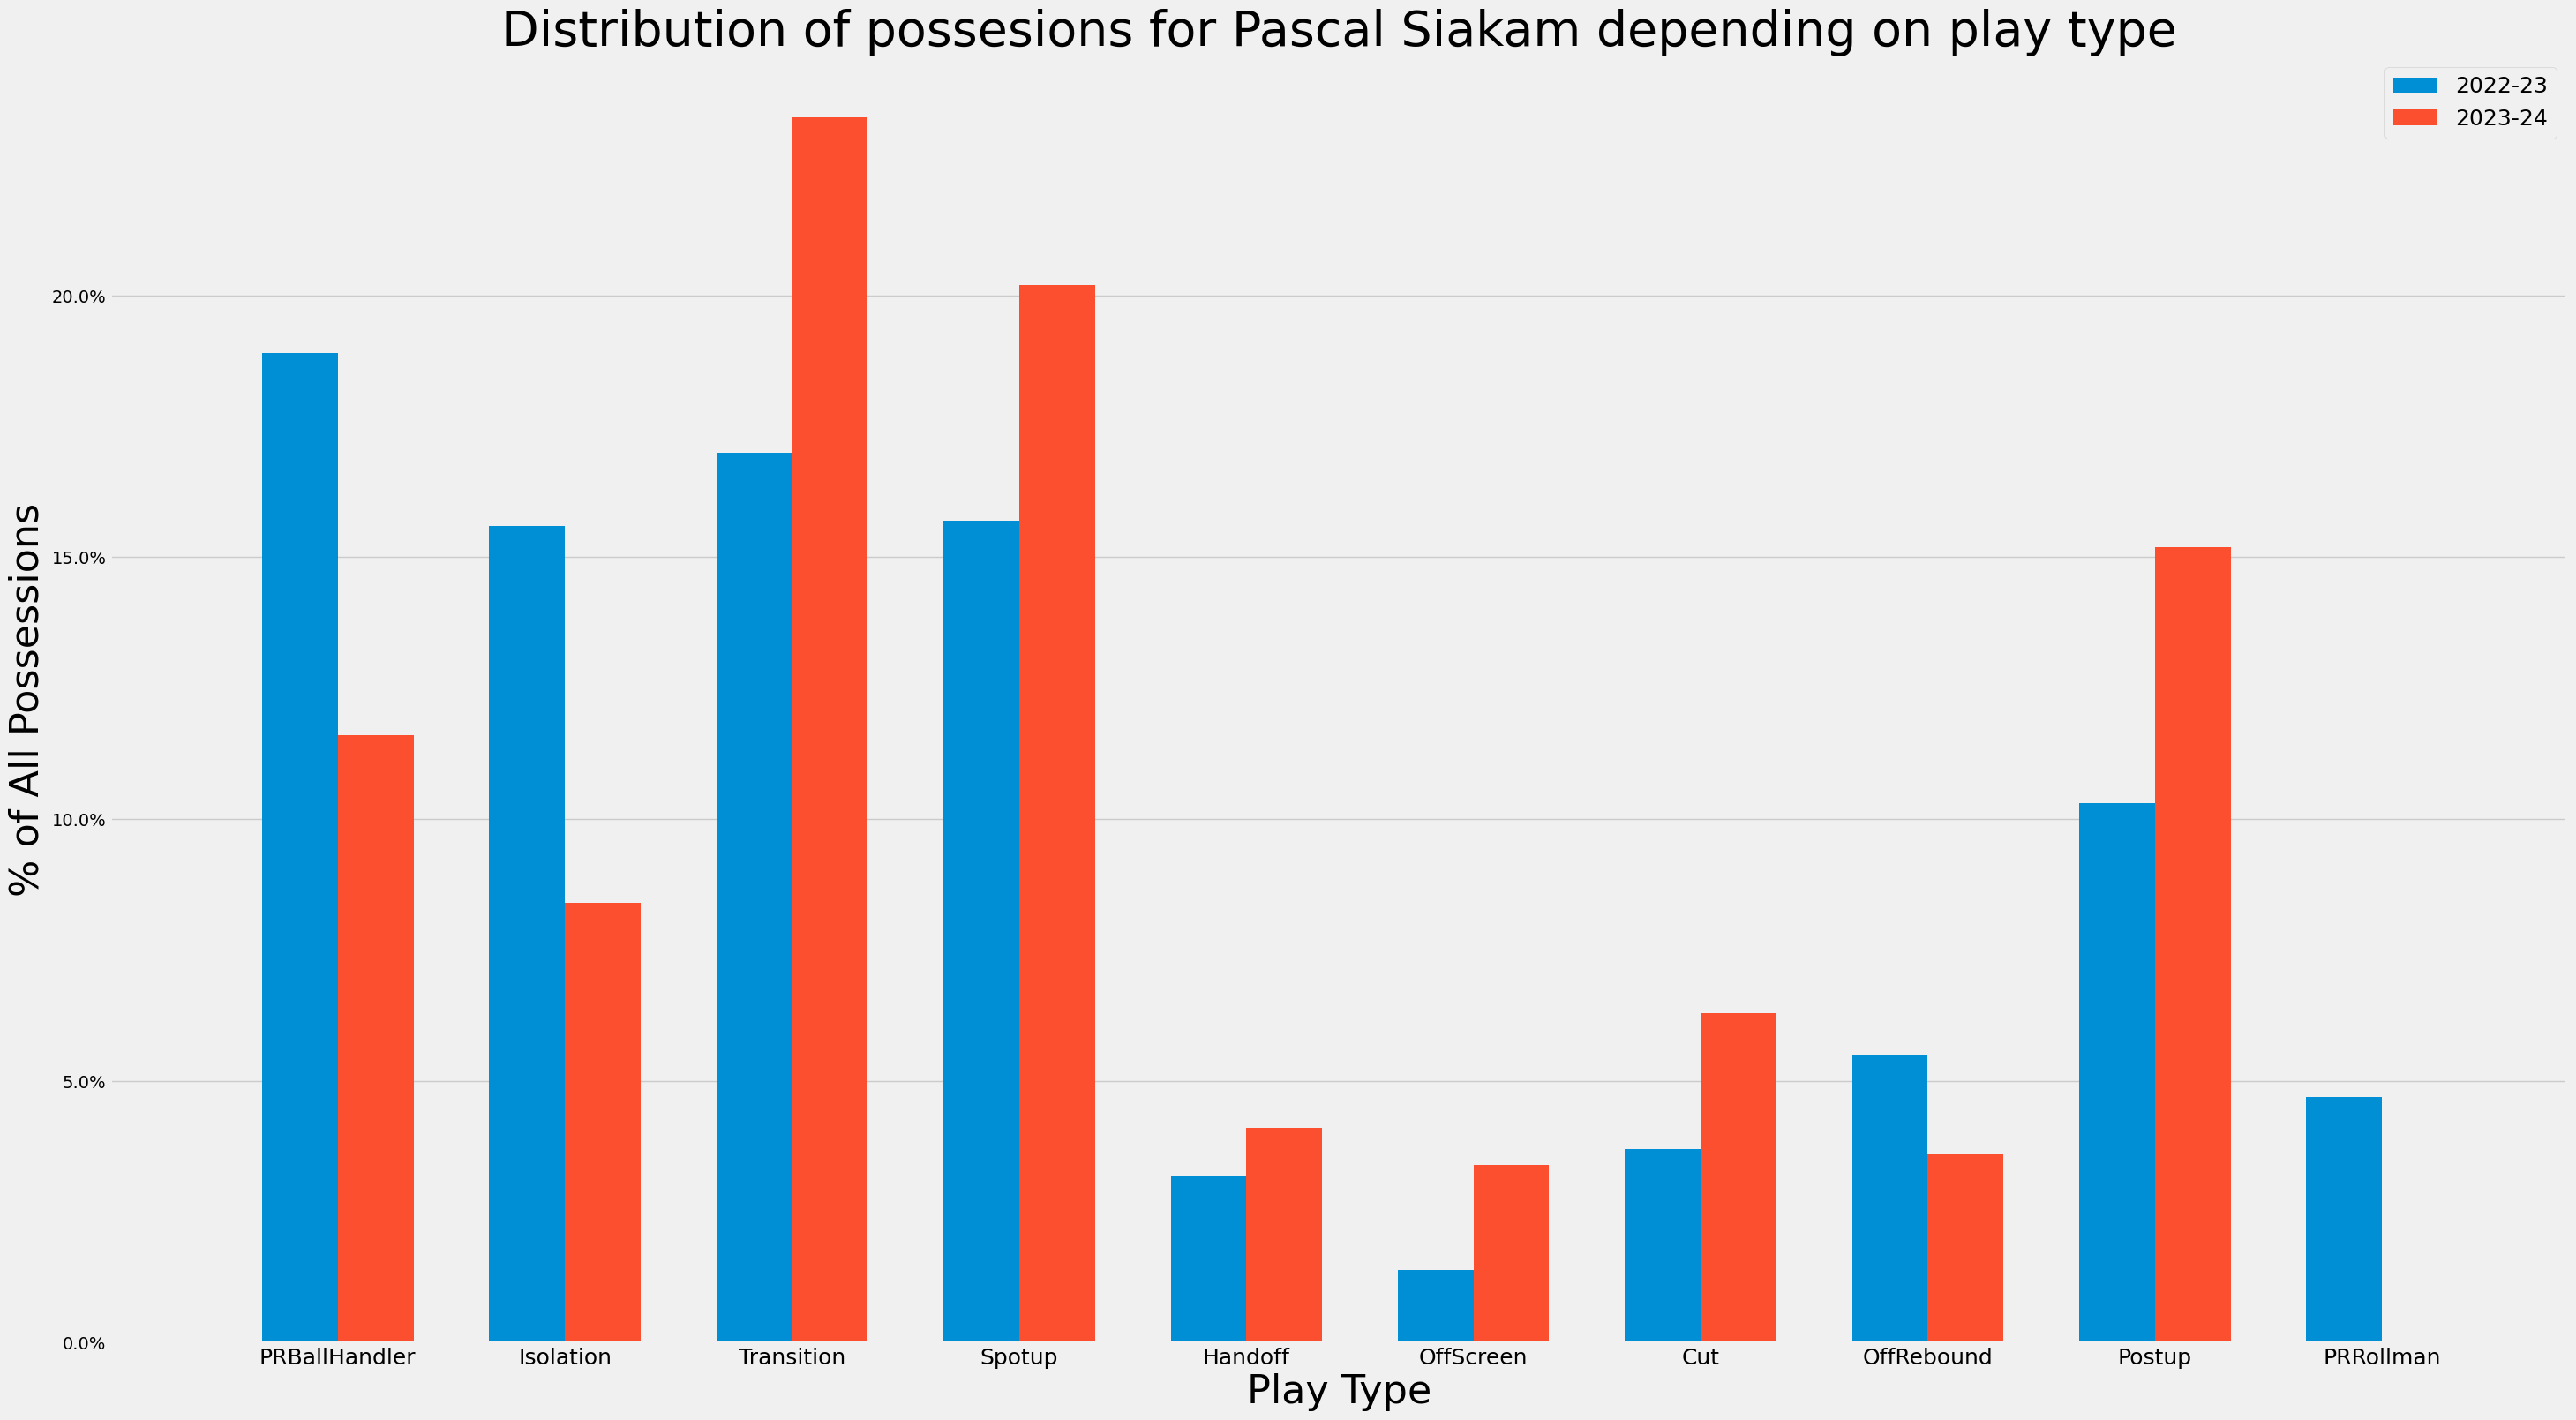

In [208]:
player_name = 'Pascal Siakam'
play_type_seasons = get_data_for_player(player_name, seasons=['2022-23', '2023-24'])
plot_bar_chart_non_white(play_type_seasons, f"Distribution of possesions for {player_name} depending on play type")


Retrieving play types...


C:\Users\danie\AppData\Local\Temp\ipykernel_6756\1340230174.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data.loc[: ,'SEASON'] = season


Retrieving play types...


C:\Users\danie\AppData\Local\Temp\ipykernel_6756\1340230174.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data.loc[: ,'SEASON'] = season
C:\Users\danie\AppData\Local\Temp\ipykernel_6756\2398590726.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + [item.split("POSS_PCT_")[1] for item in list(labels)], size=18)


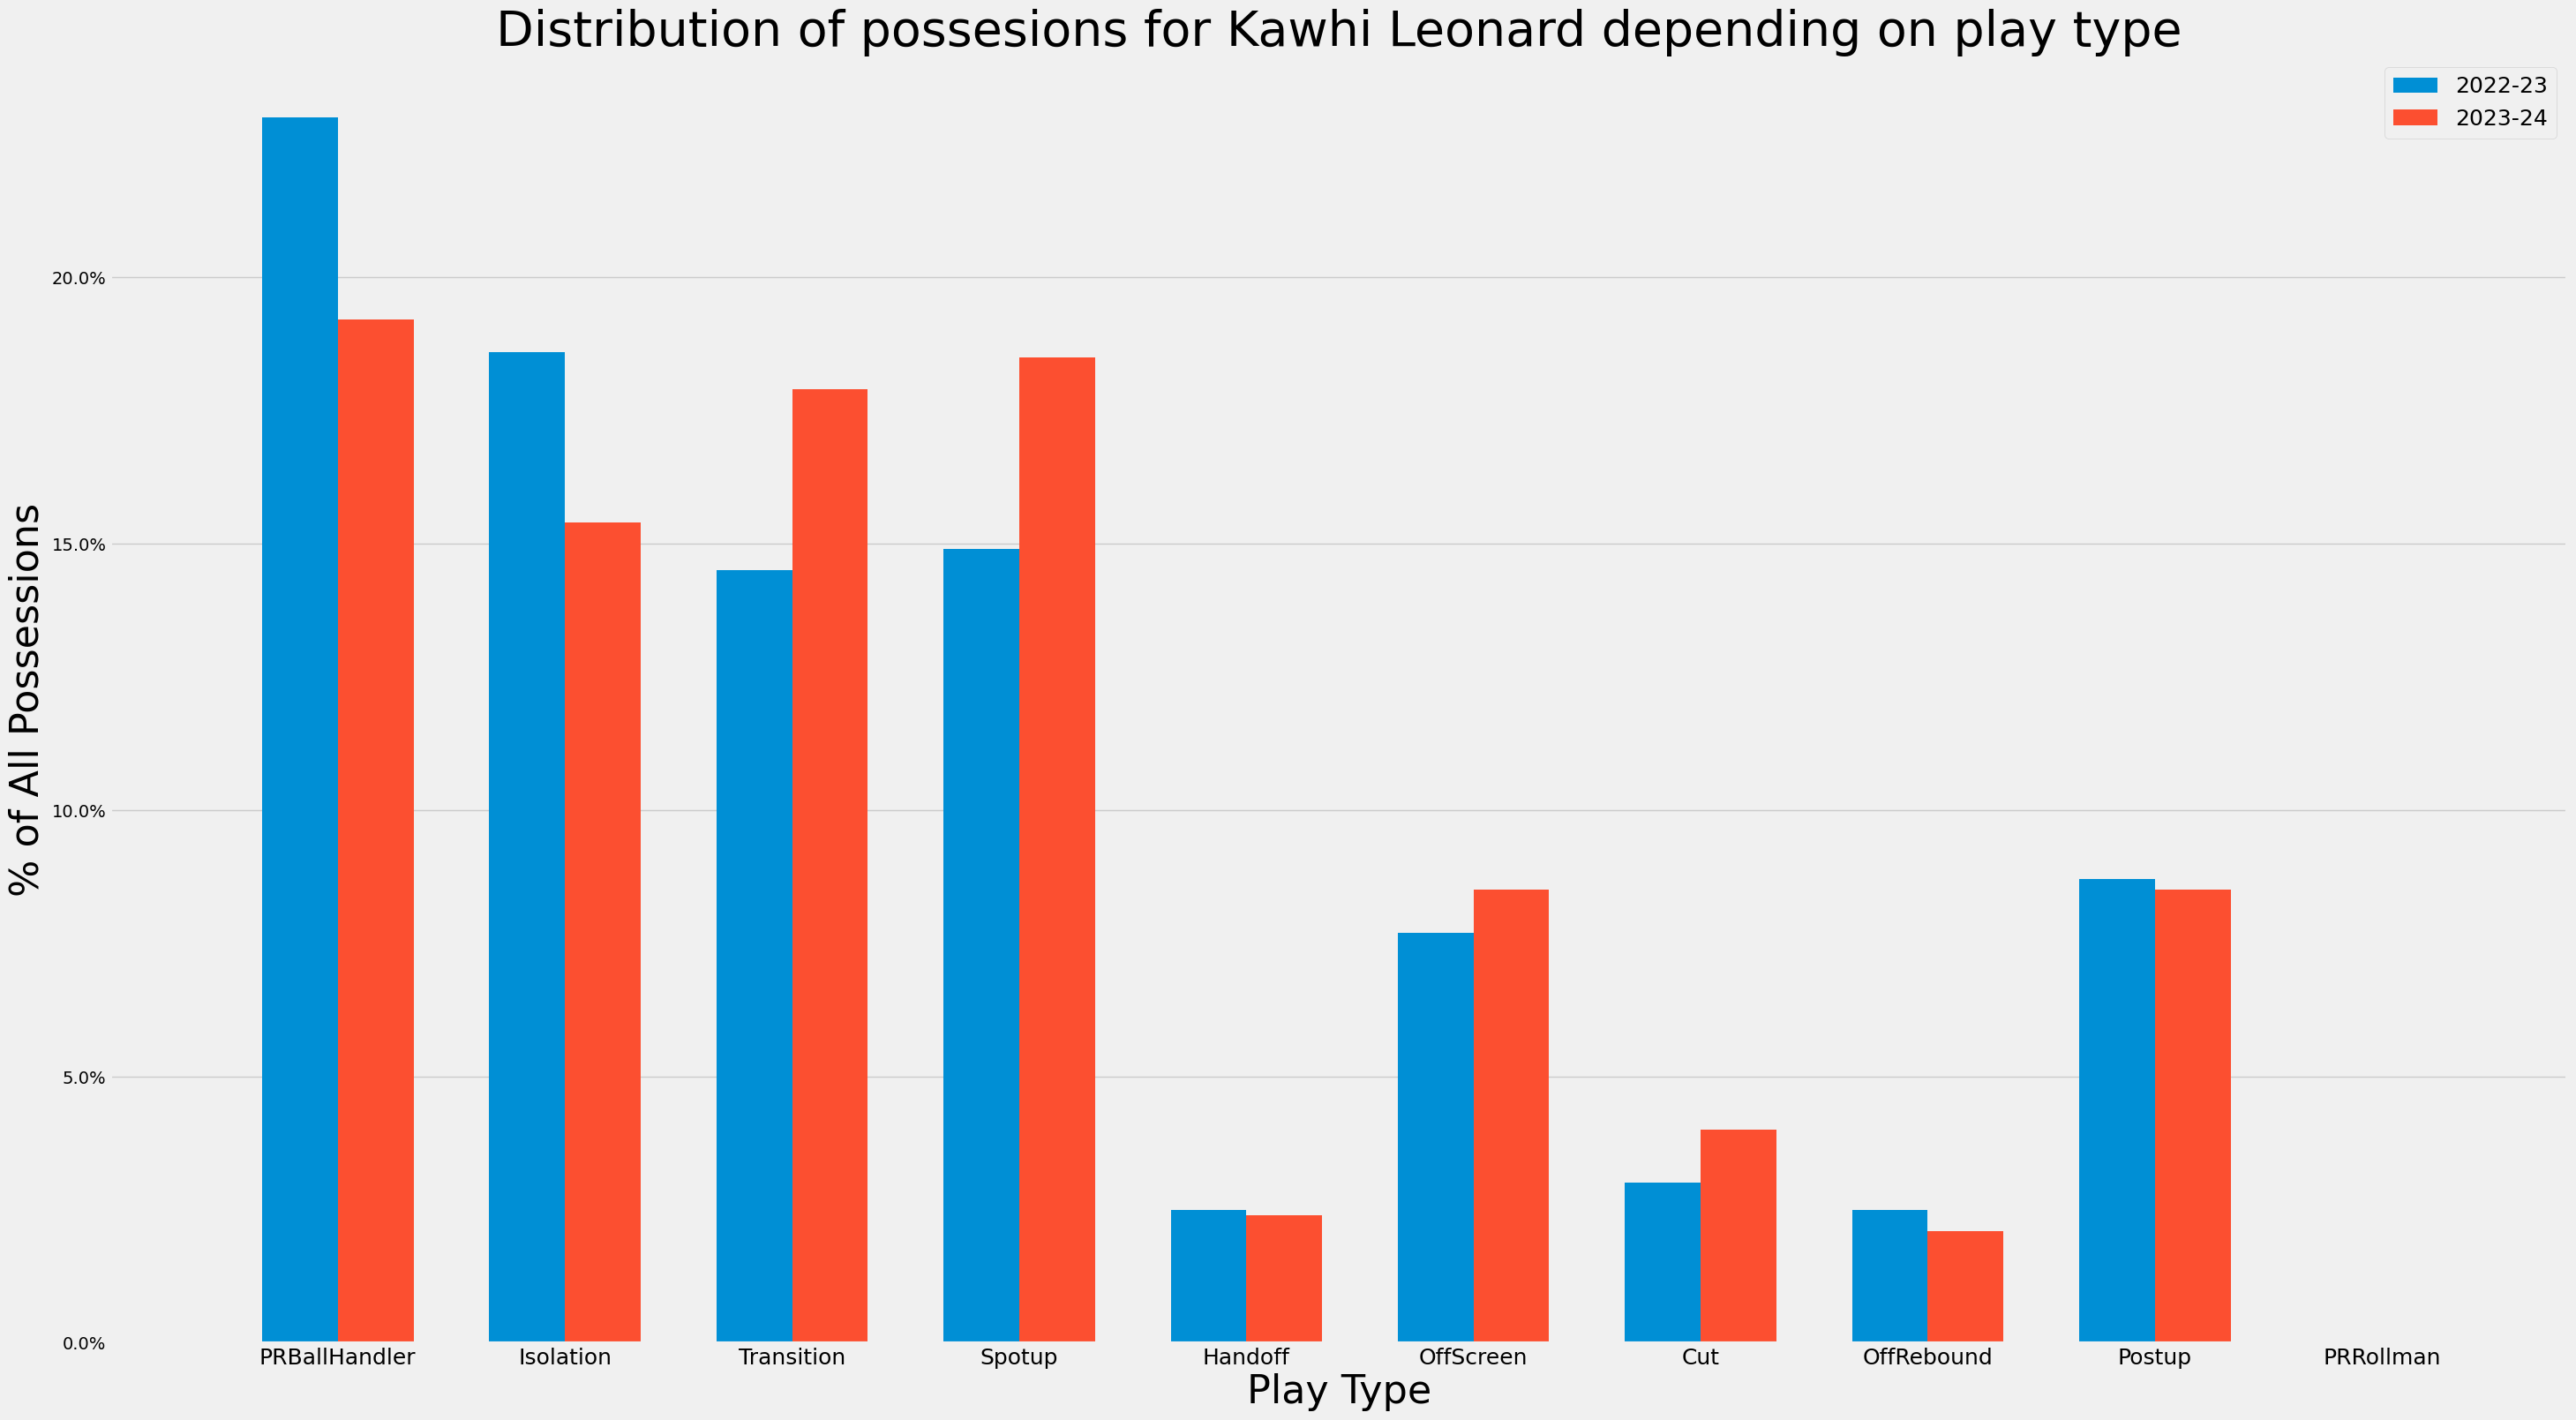

In [11]:
player_name = 'Kawhi Leonard'
play_type_seasons = get_data_for_player(player_name, seasons=['2022-23', '2023-24'])
plot_bar_chart_non_white(play_type_seasons, f"Distribution of possesions for {player_name} depending on play type")


C:\Users\danie\AppData\Local\Temp\ipykernel_6756\1340230174.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data.loc[: ,'SEASON'] = season
C:\Users\danie\AppData\Local\Temp\ipykernel_6756\1340230174.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data.loc[: ,'SEASON'] = season
C:\Users\danie\AppData\Local\Temp\ipykernel_6756\2398590726.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xtickl

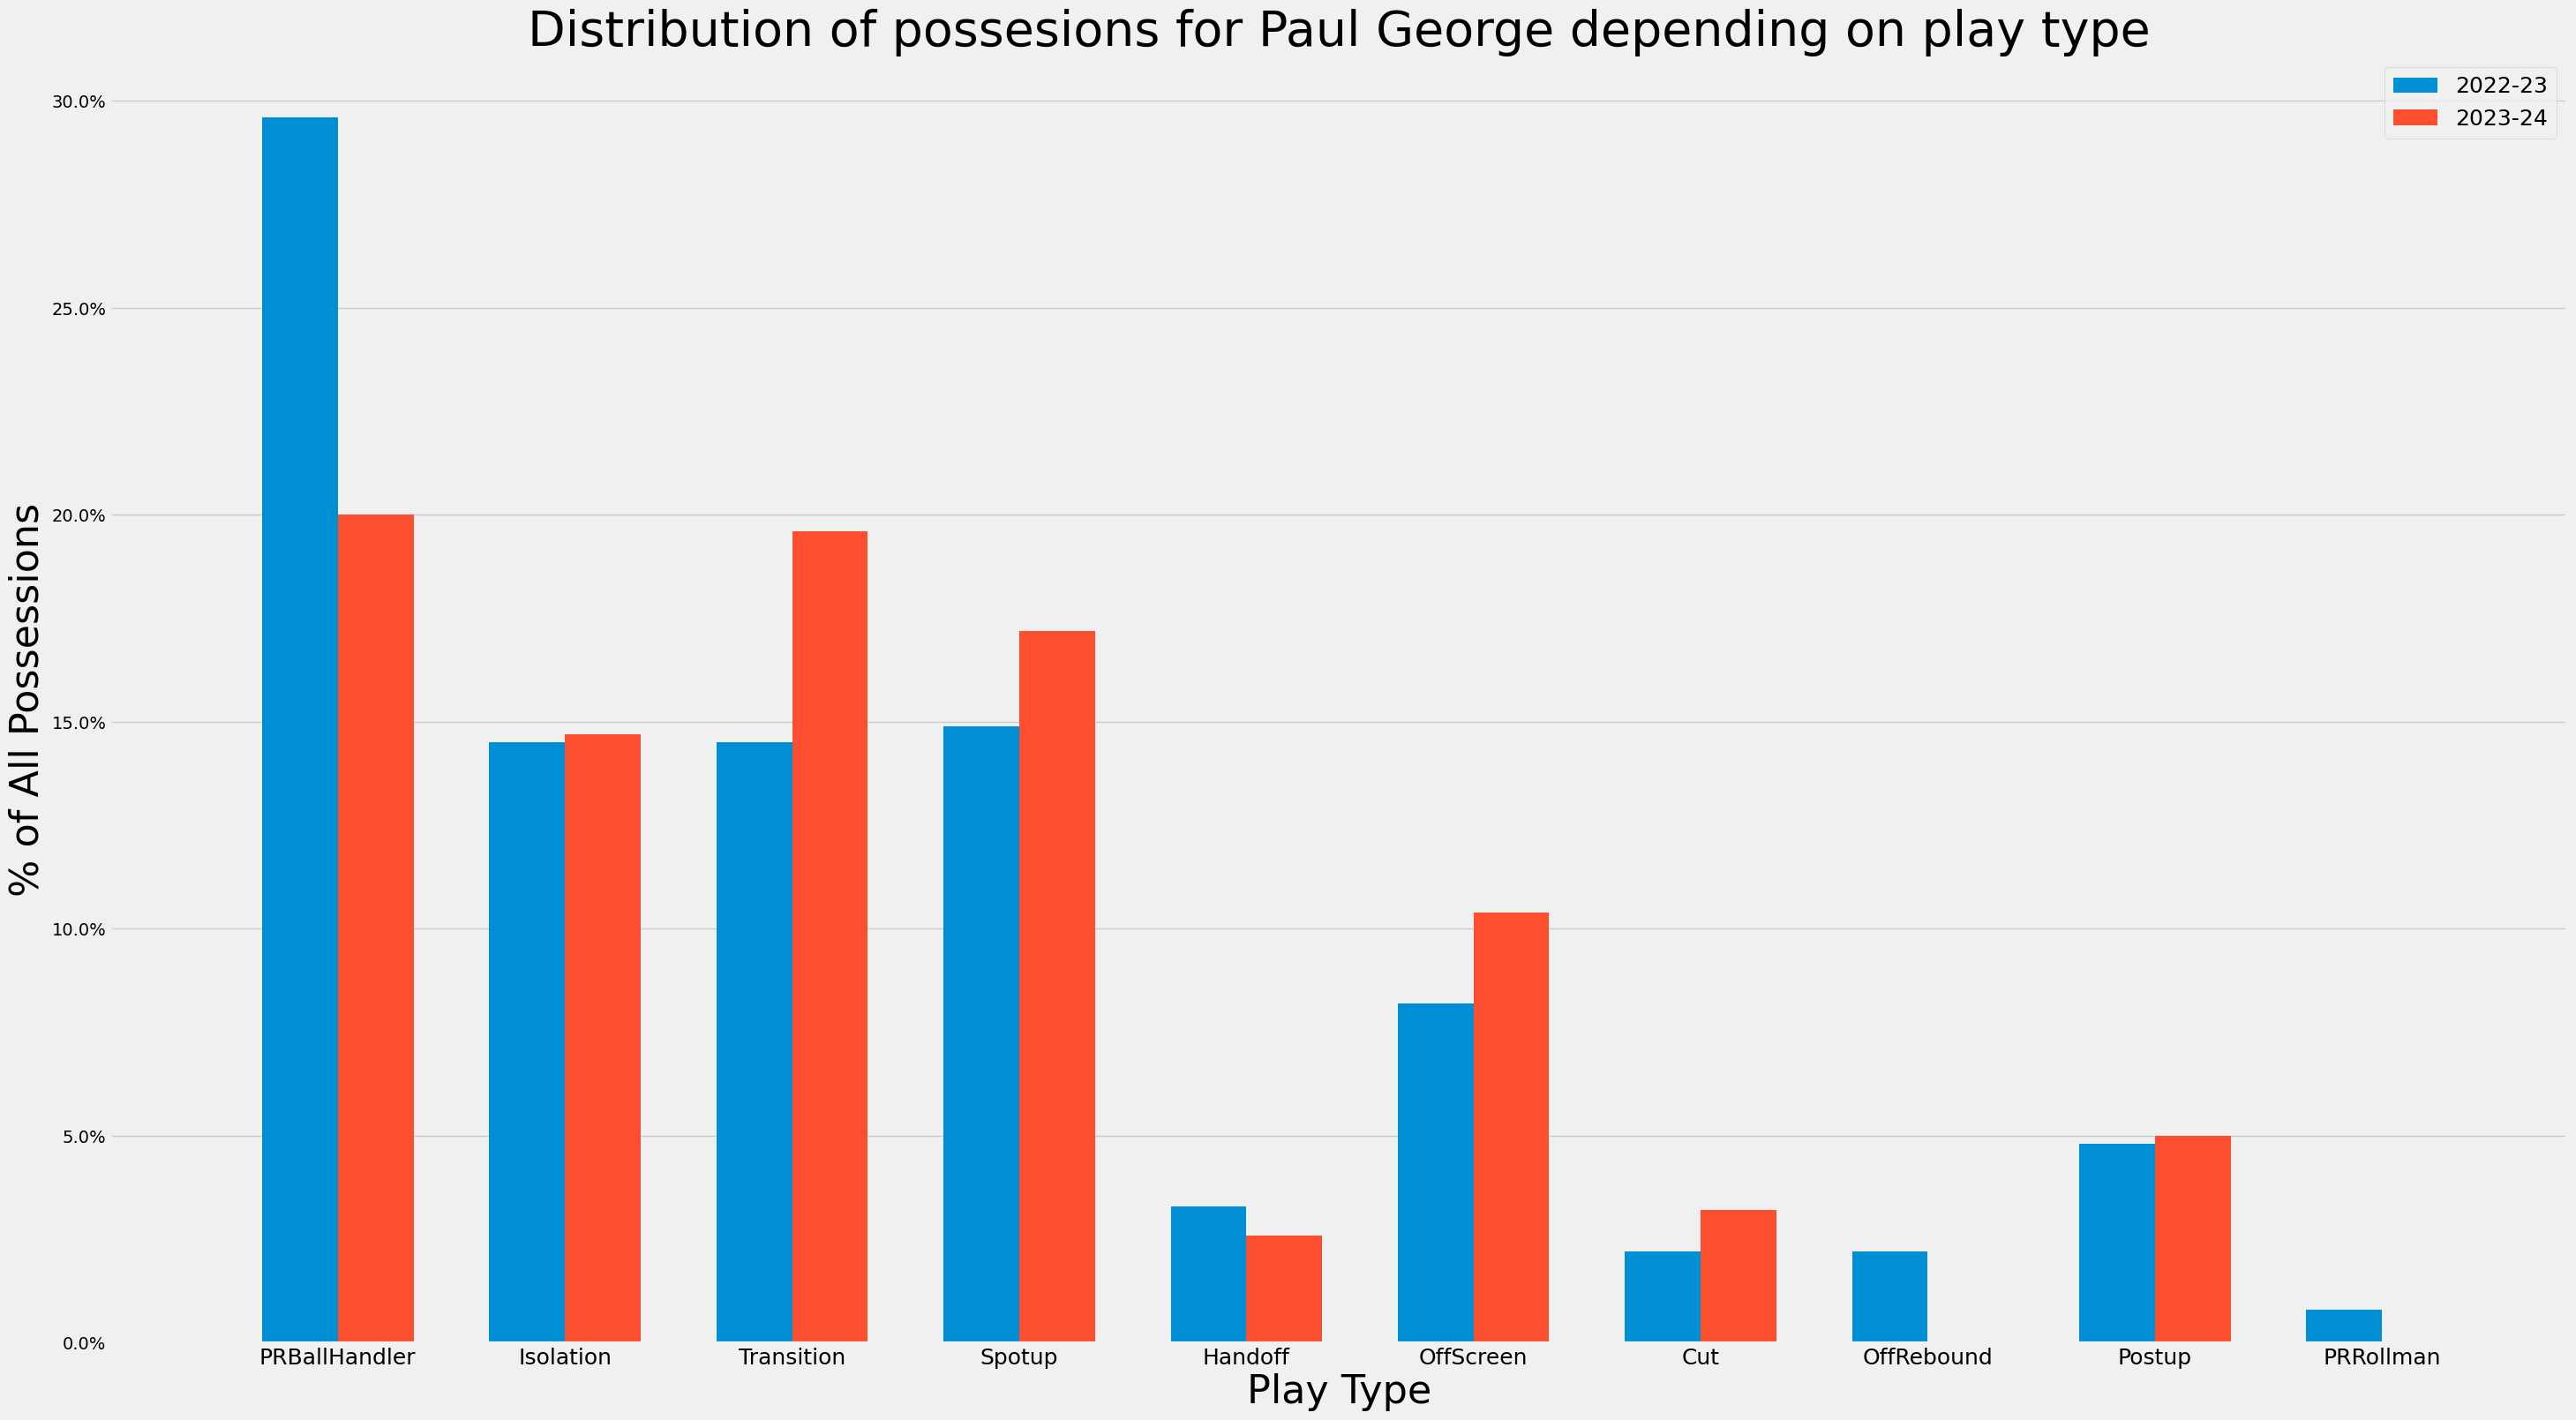

In [12]:
player_name = 'Paul George'
play_type_seasons = get_data_for_player(player_name, seasons=['2022-23', '2023-24'])
plot_bar_chart_non_white(play_type_seasons, f"Distribution of possesions for {player_name} depending on play type")


C:\Users\danie\AppData\Local\Temp\ipykernel_6756\1340230174.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data.loc[: ,'SEASON'] = season
C:\Users\danie\AppData\Local\Temp\ipykernel_6756\1340230174.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data.loc[: ,'SEASON'] = season
C:\Users\danie\AppData\Local\Temp\ipykernel_6756\2398590726.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xtickl

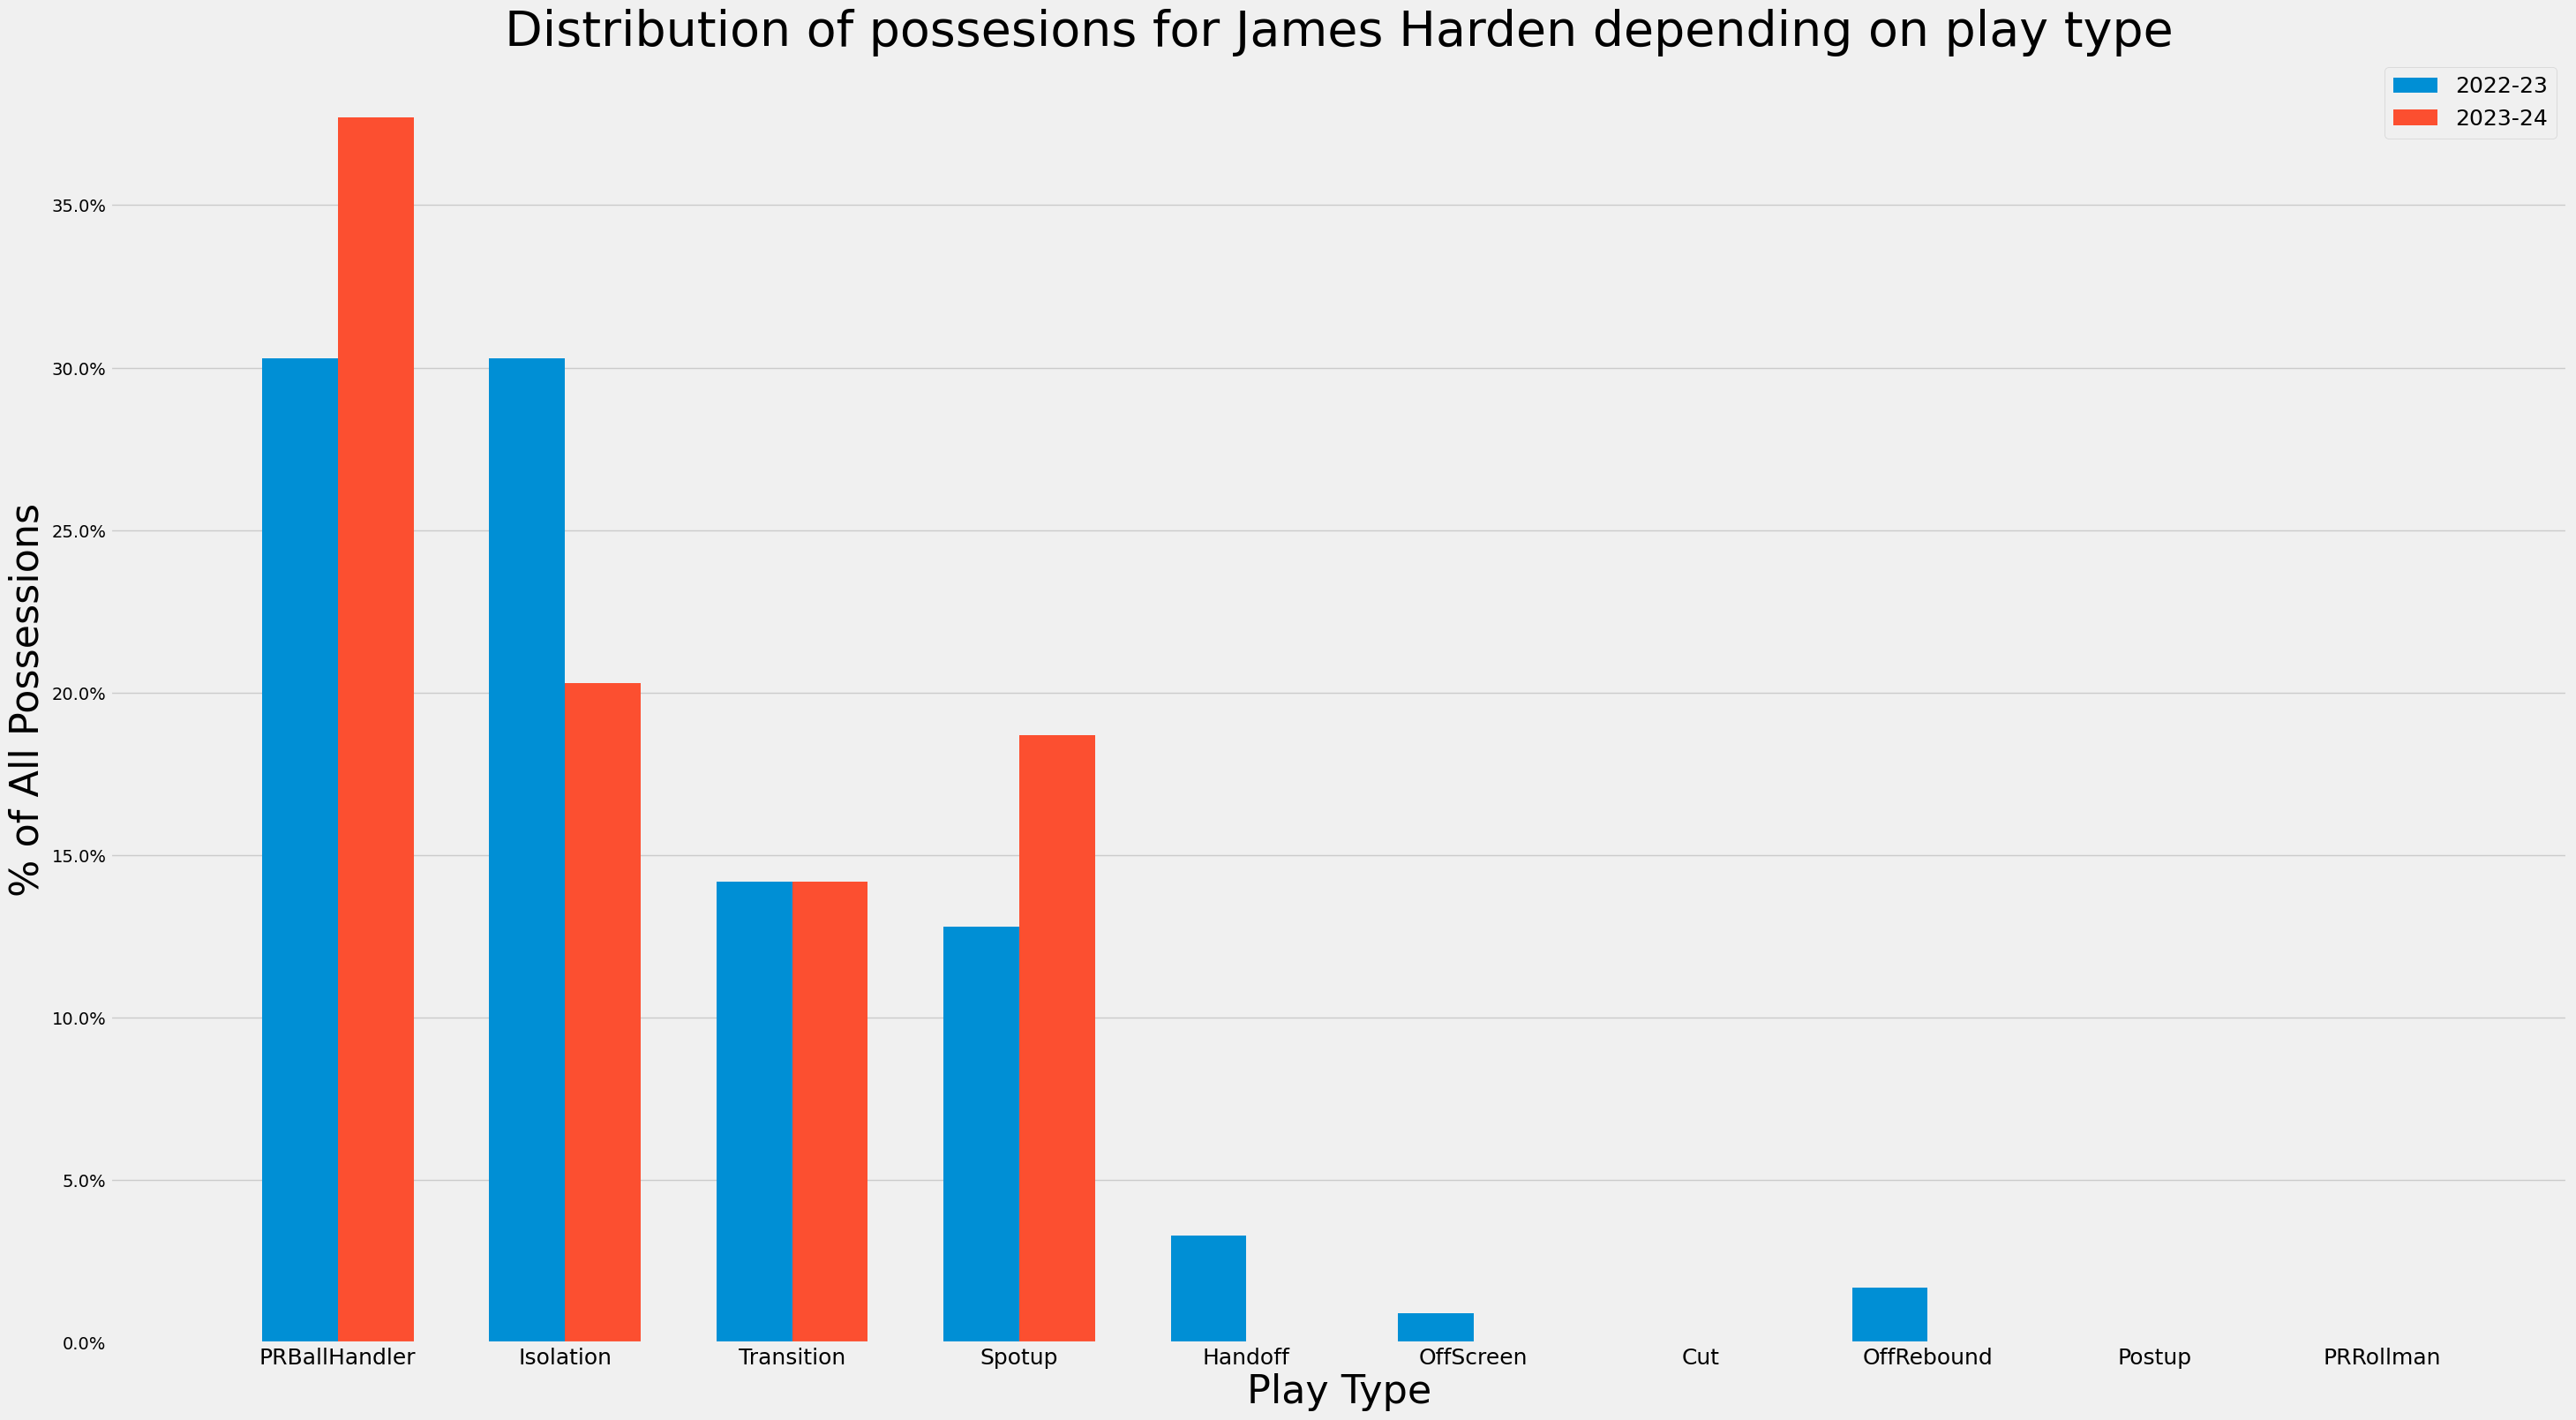

In [13]:
player_name = 'James Harden'
play_type_seasons = get_data_for_player(player_name, seasons=['2022-23', '2023-24'])
plot_bar_chart_non_white(play_type_seasons, f"Distribution of possesions for {player_name} depending on play type")


## Giannis

Retrieving play types...


C:\Users\danie\AppData\Local\Temp\ipykernel_8828\1340230174.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data.loc[: ,'SEASON'] = season


Retrieving play types...


C:\Users\danie\AppData\Local\Temp\ipykernel_8828\1340230174.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data.loc[: ,'SEASON'] = season
C:\Users\danie\AppData\Local\Temp\ipykernel_8828\2398590726.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + [item.split("POSS_PCT_")[1] for item in list(labels)], size=18)


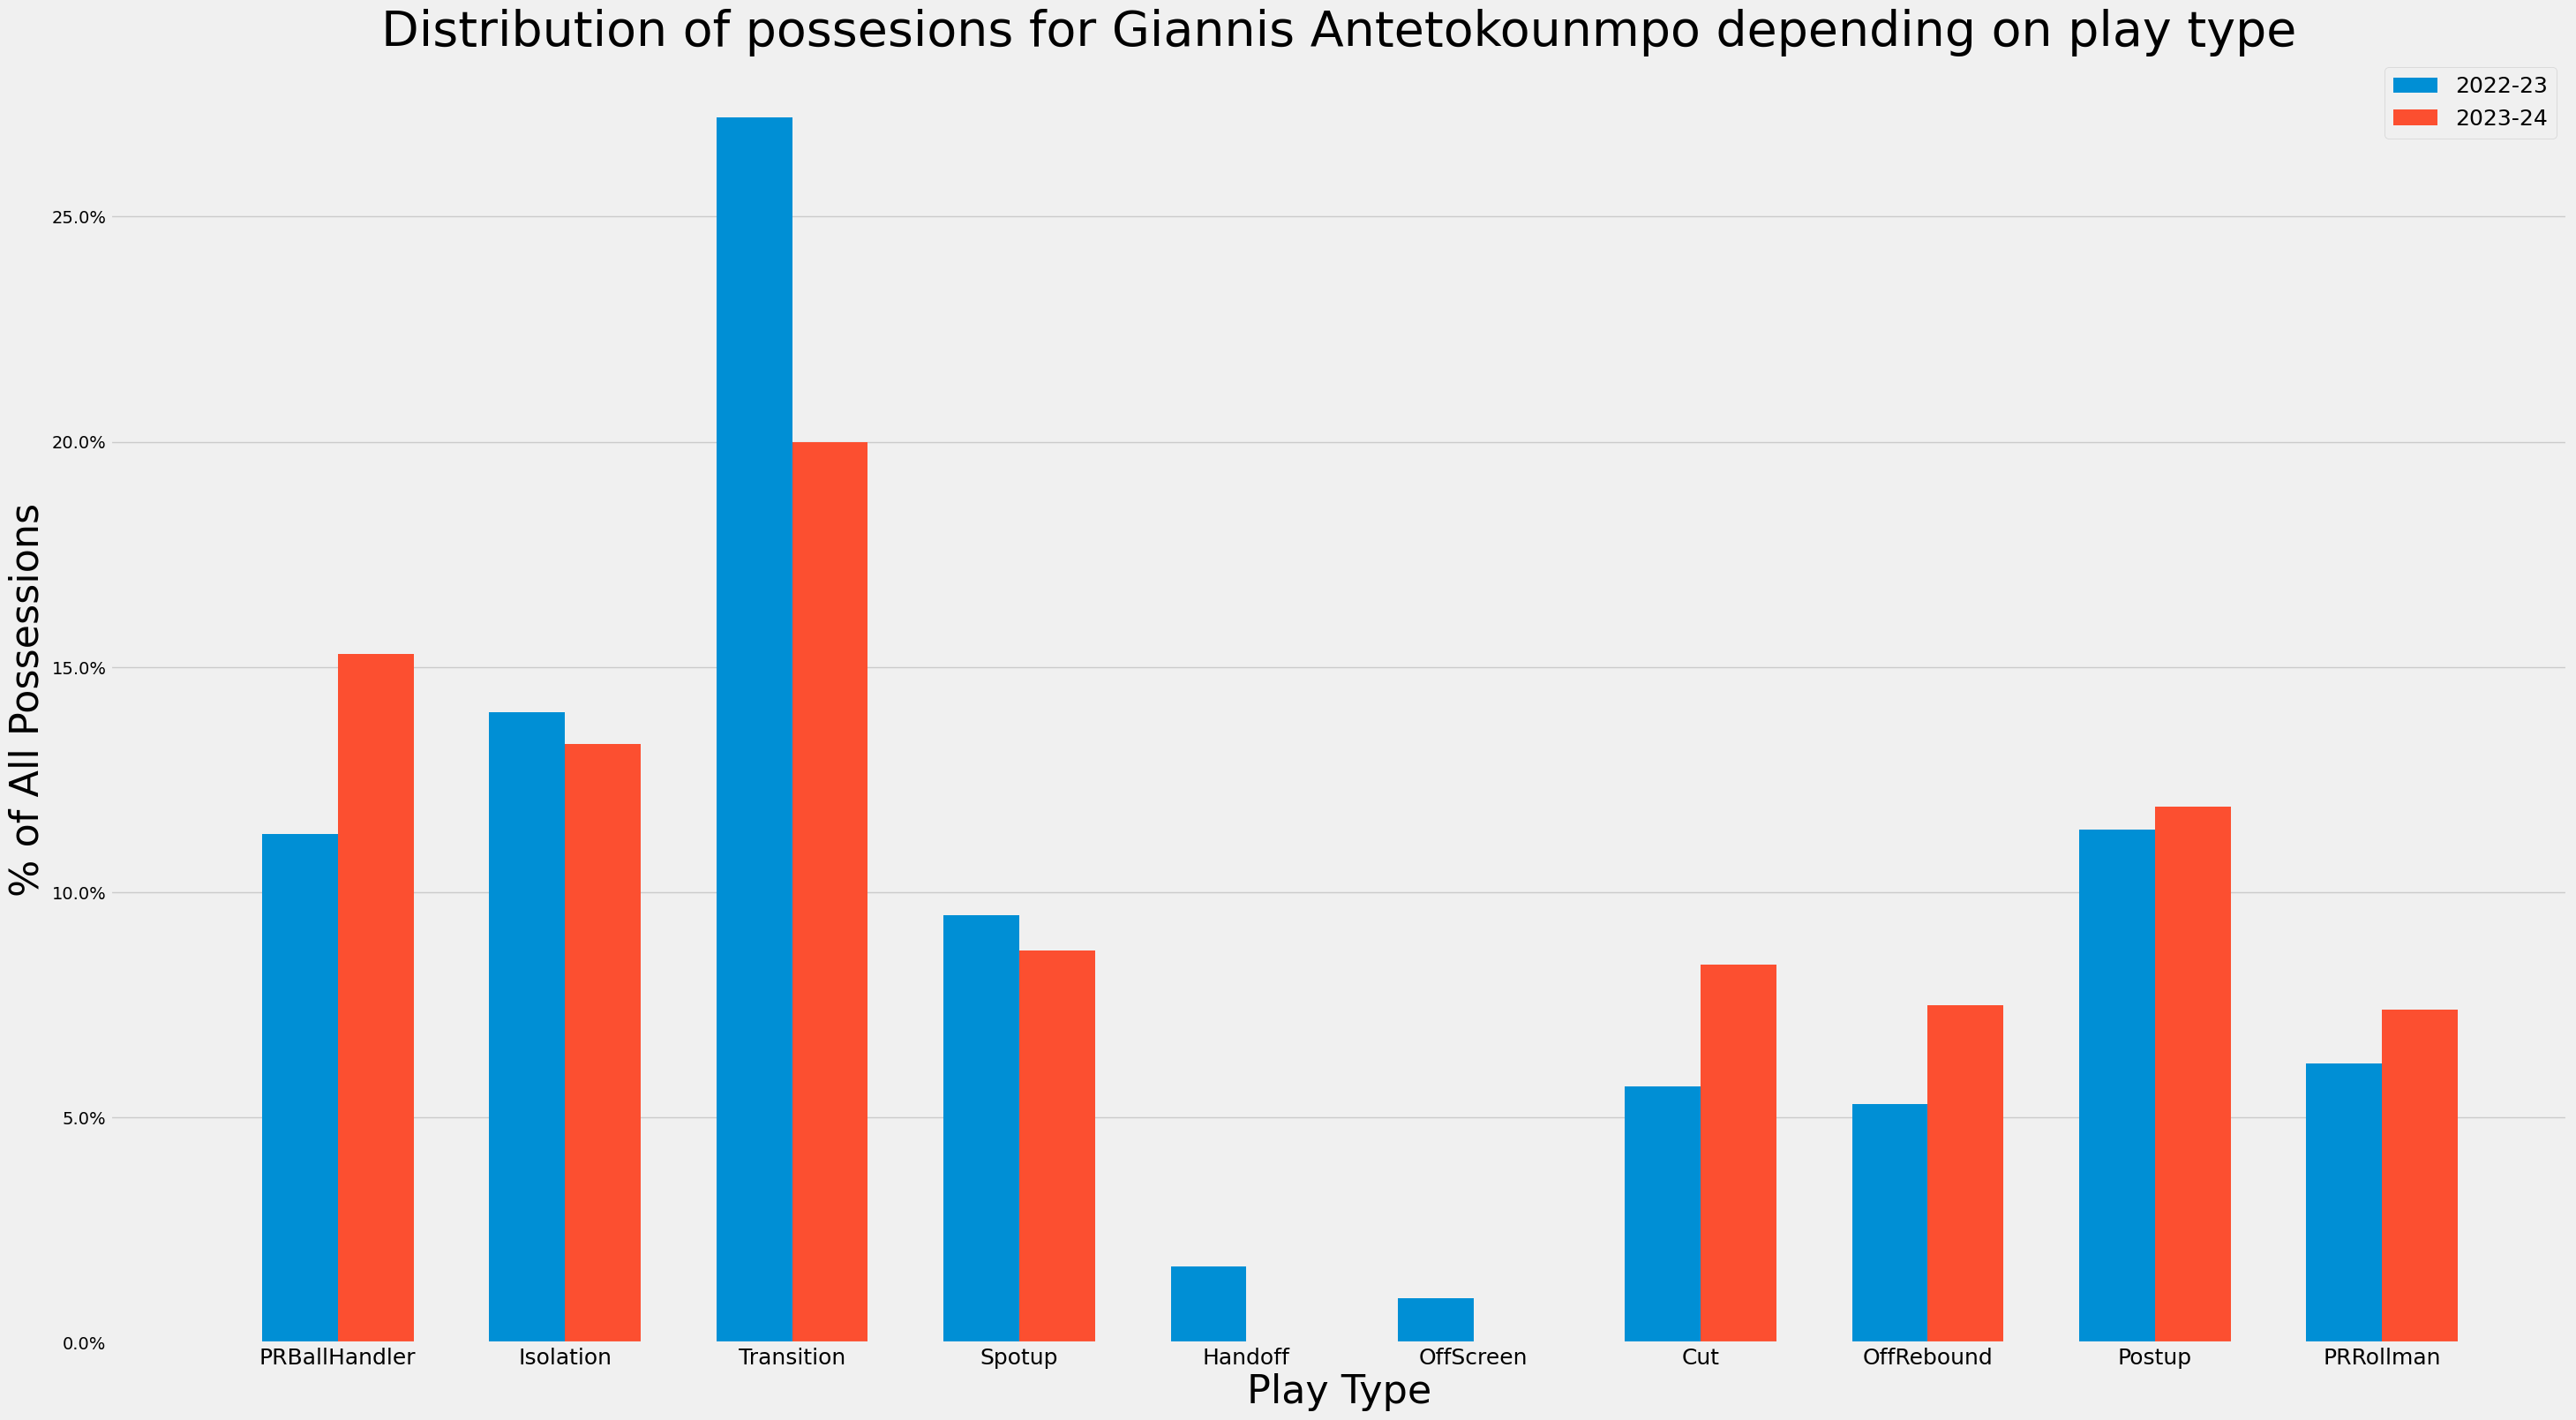

In [11]:
player_name = 'Giannis Antetokounmpo'
play_type_seasons = get_data_for_player(player_name, seasons=['2022-23', '2023-24'])
plot_bar_chart_non_white(play_type_seasons, f"Distribution of possesions for {player_name} depending on play type")


## Anunoby vs Barrett

In [18]:
play_type_players = get_data_for_players(['OG Anunoby', 'RJ Barrett'], season='2023-24')

C:\Users\danie\AppData\Local\Temp\ipykernel_20444\1530384983.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + [item.split("POSS_PCT_")[1] for item in list(labels)], size=18)


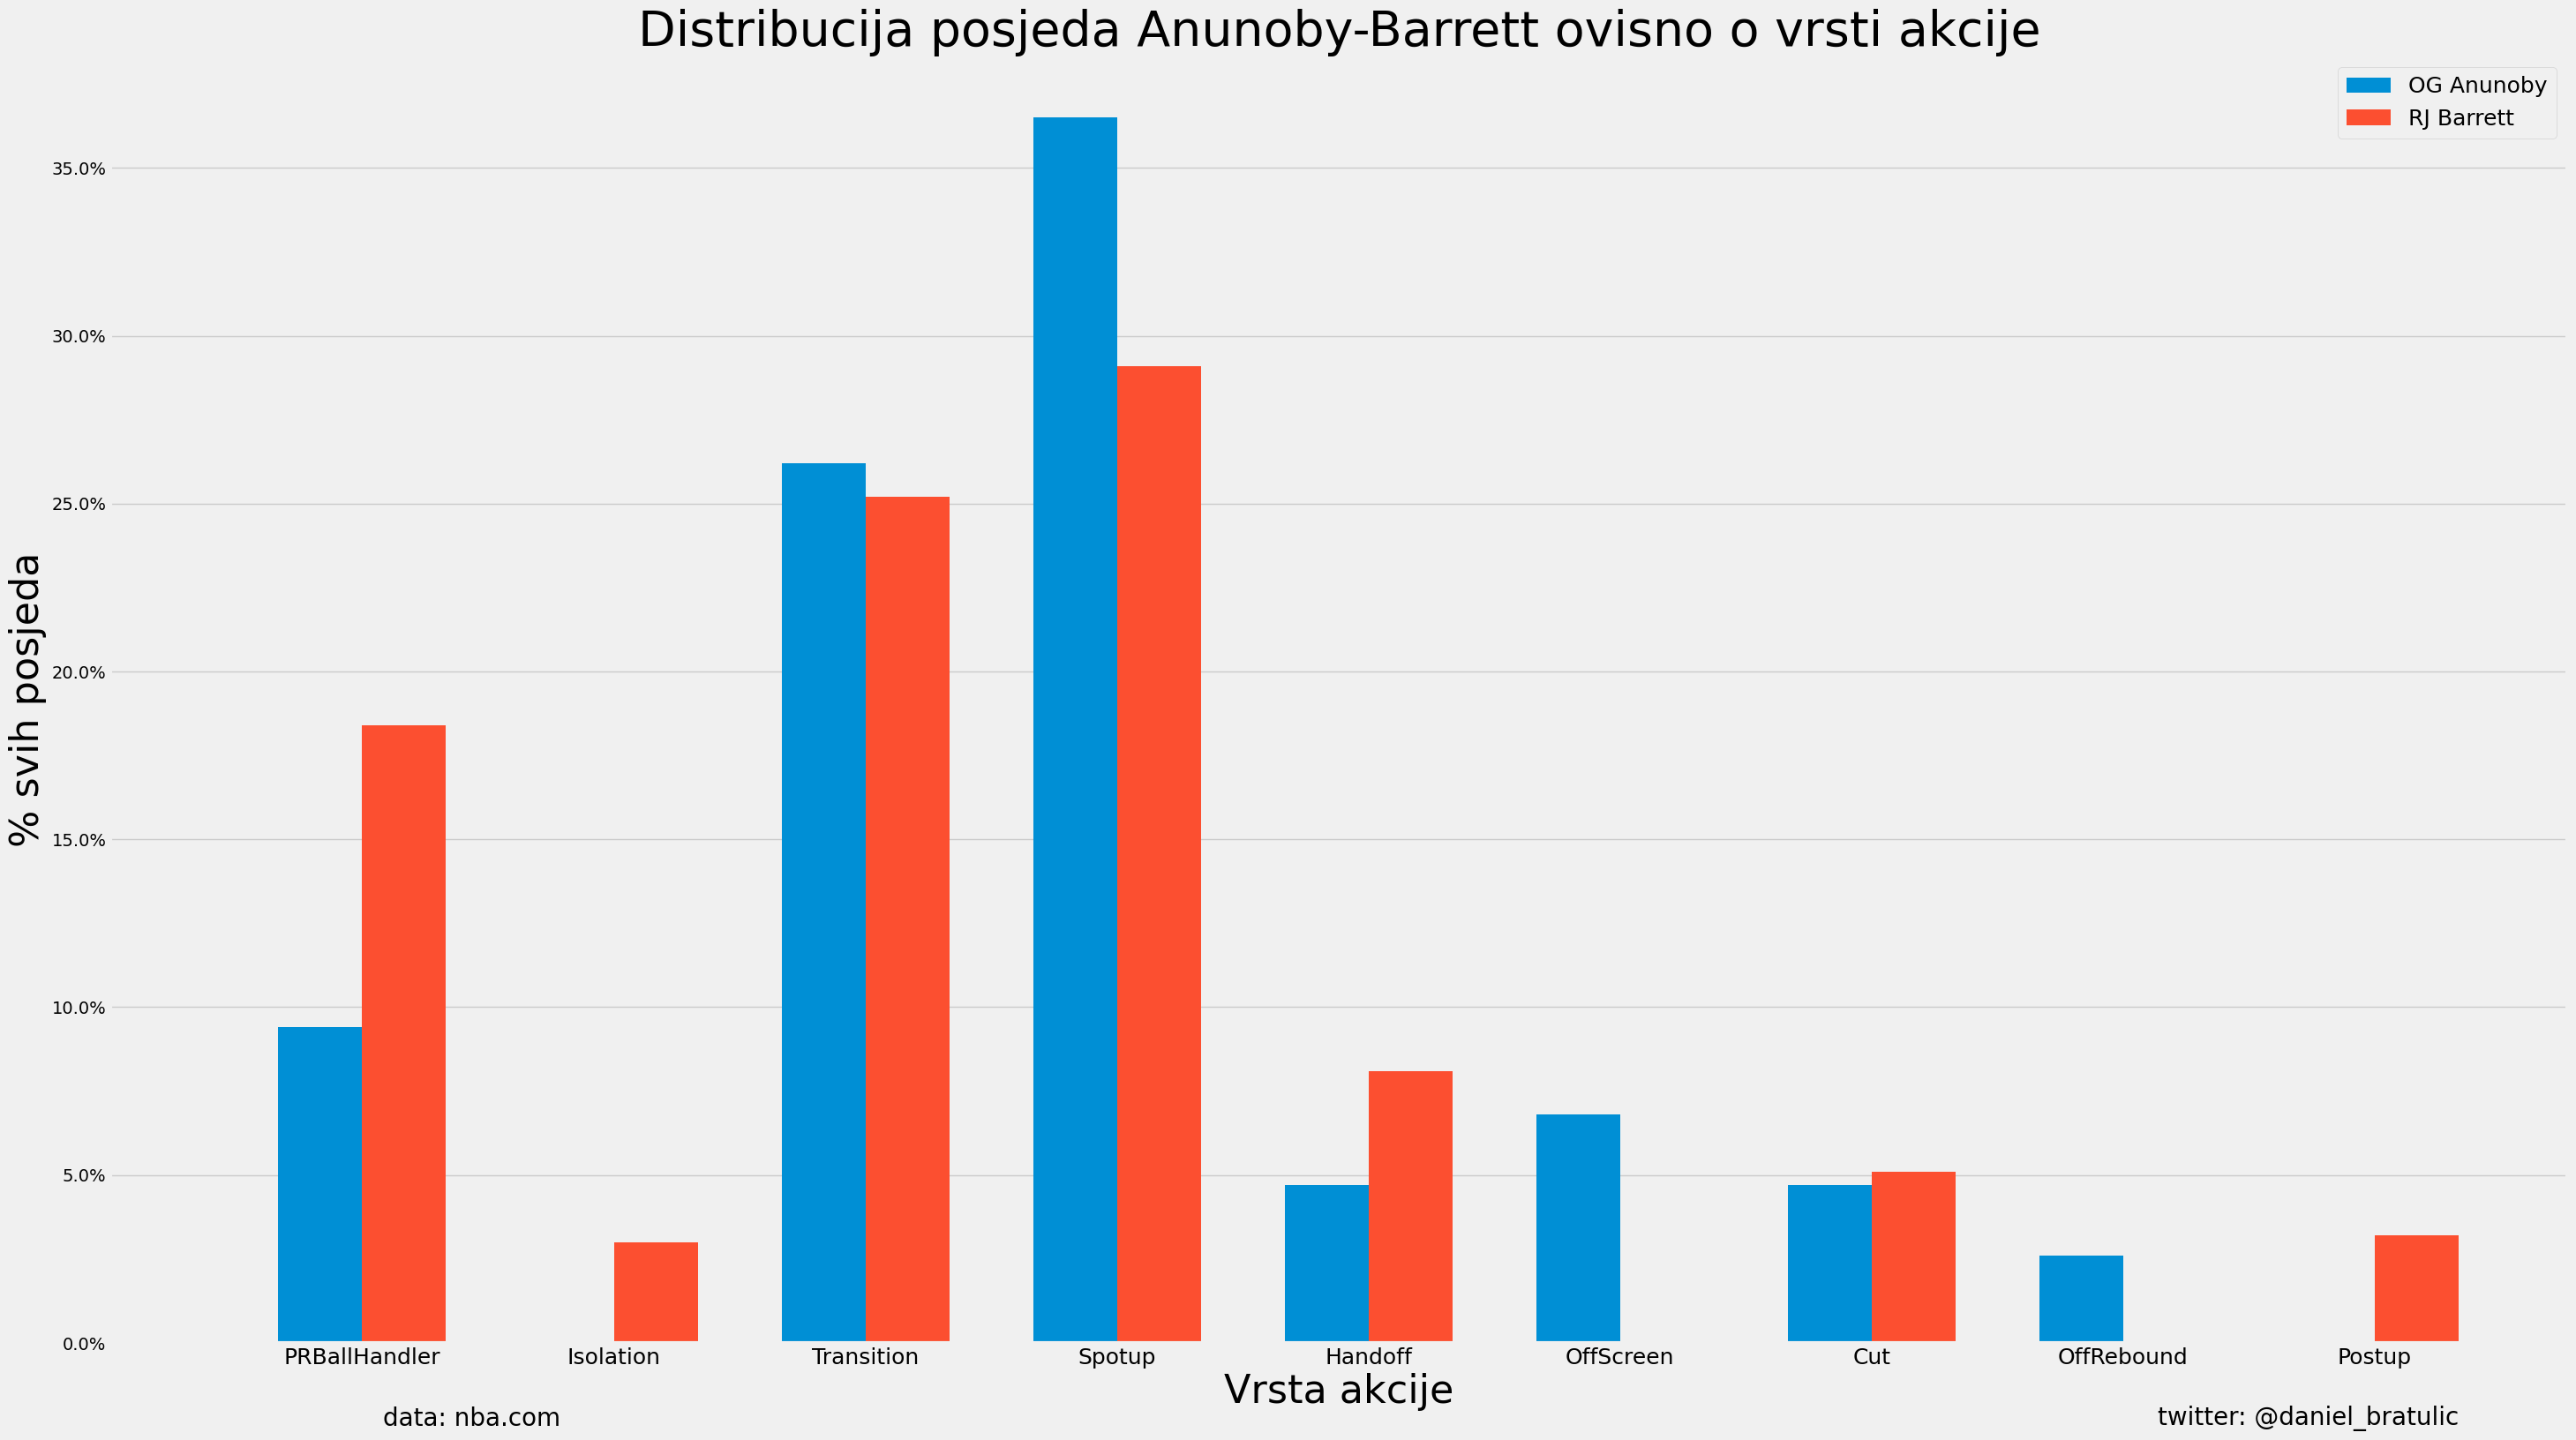

In [29]:
plot_bar_chart_non_white_hr(play_type_players, f"Distribucija posjeda Anunoby-Barrett ovisno o vrsti akcije")

Retrieving play types...


C:\Users\danie\AppData\Local\Temp\ipykernel_20444\1340230174.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data.loc[: ,'SEASON'] = season


Retrieving play types...


C:\Users\danie\AppData\Local\Temp\ipykernel_20444\1340230174.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data.loc[: ,'SEASON'] = season
C:\Users\danie\AppData\Local\Temp\ipykernel_20444\2398590726.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + [item.split("POSS_PCT_")[1] for item in list(labels)], size=18)


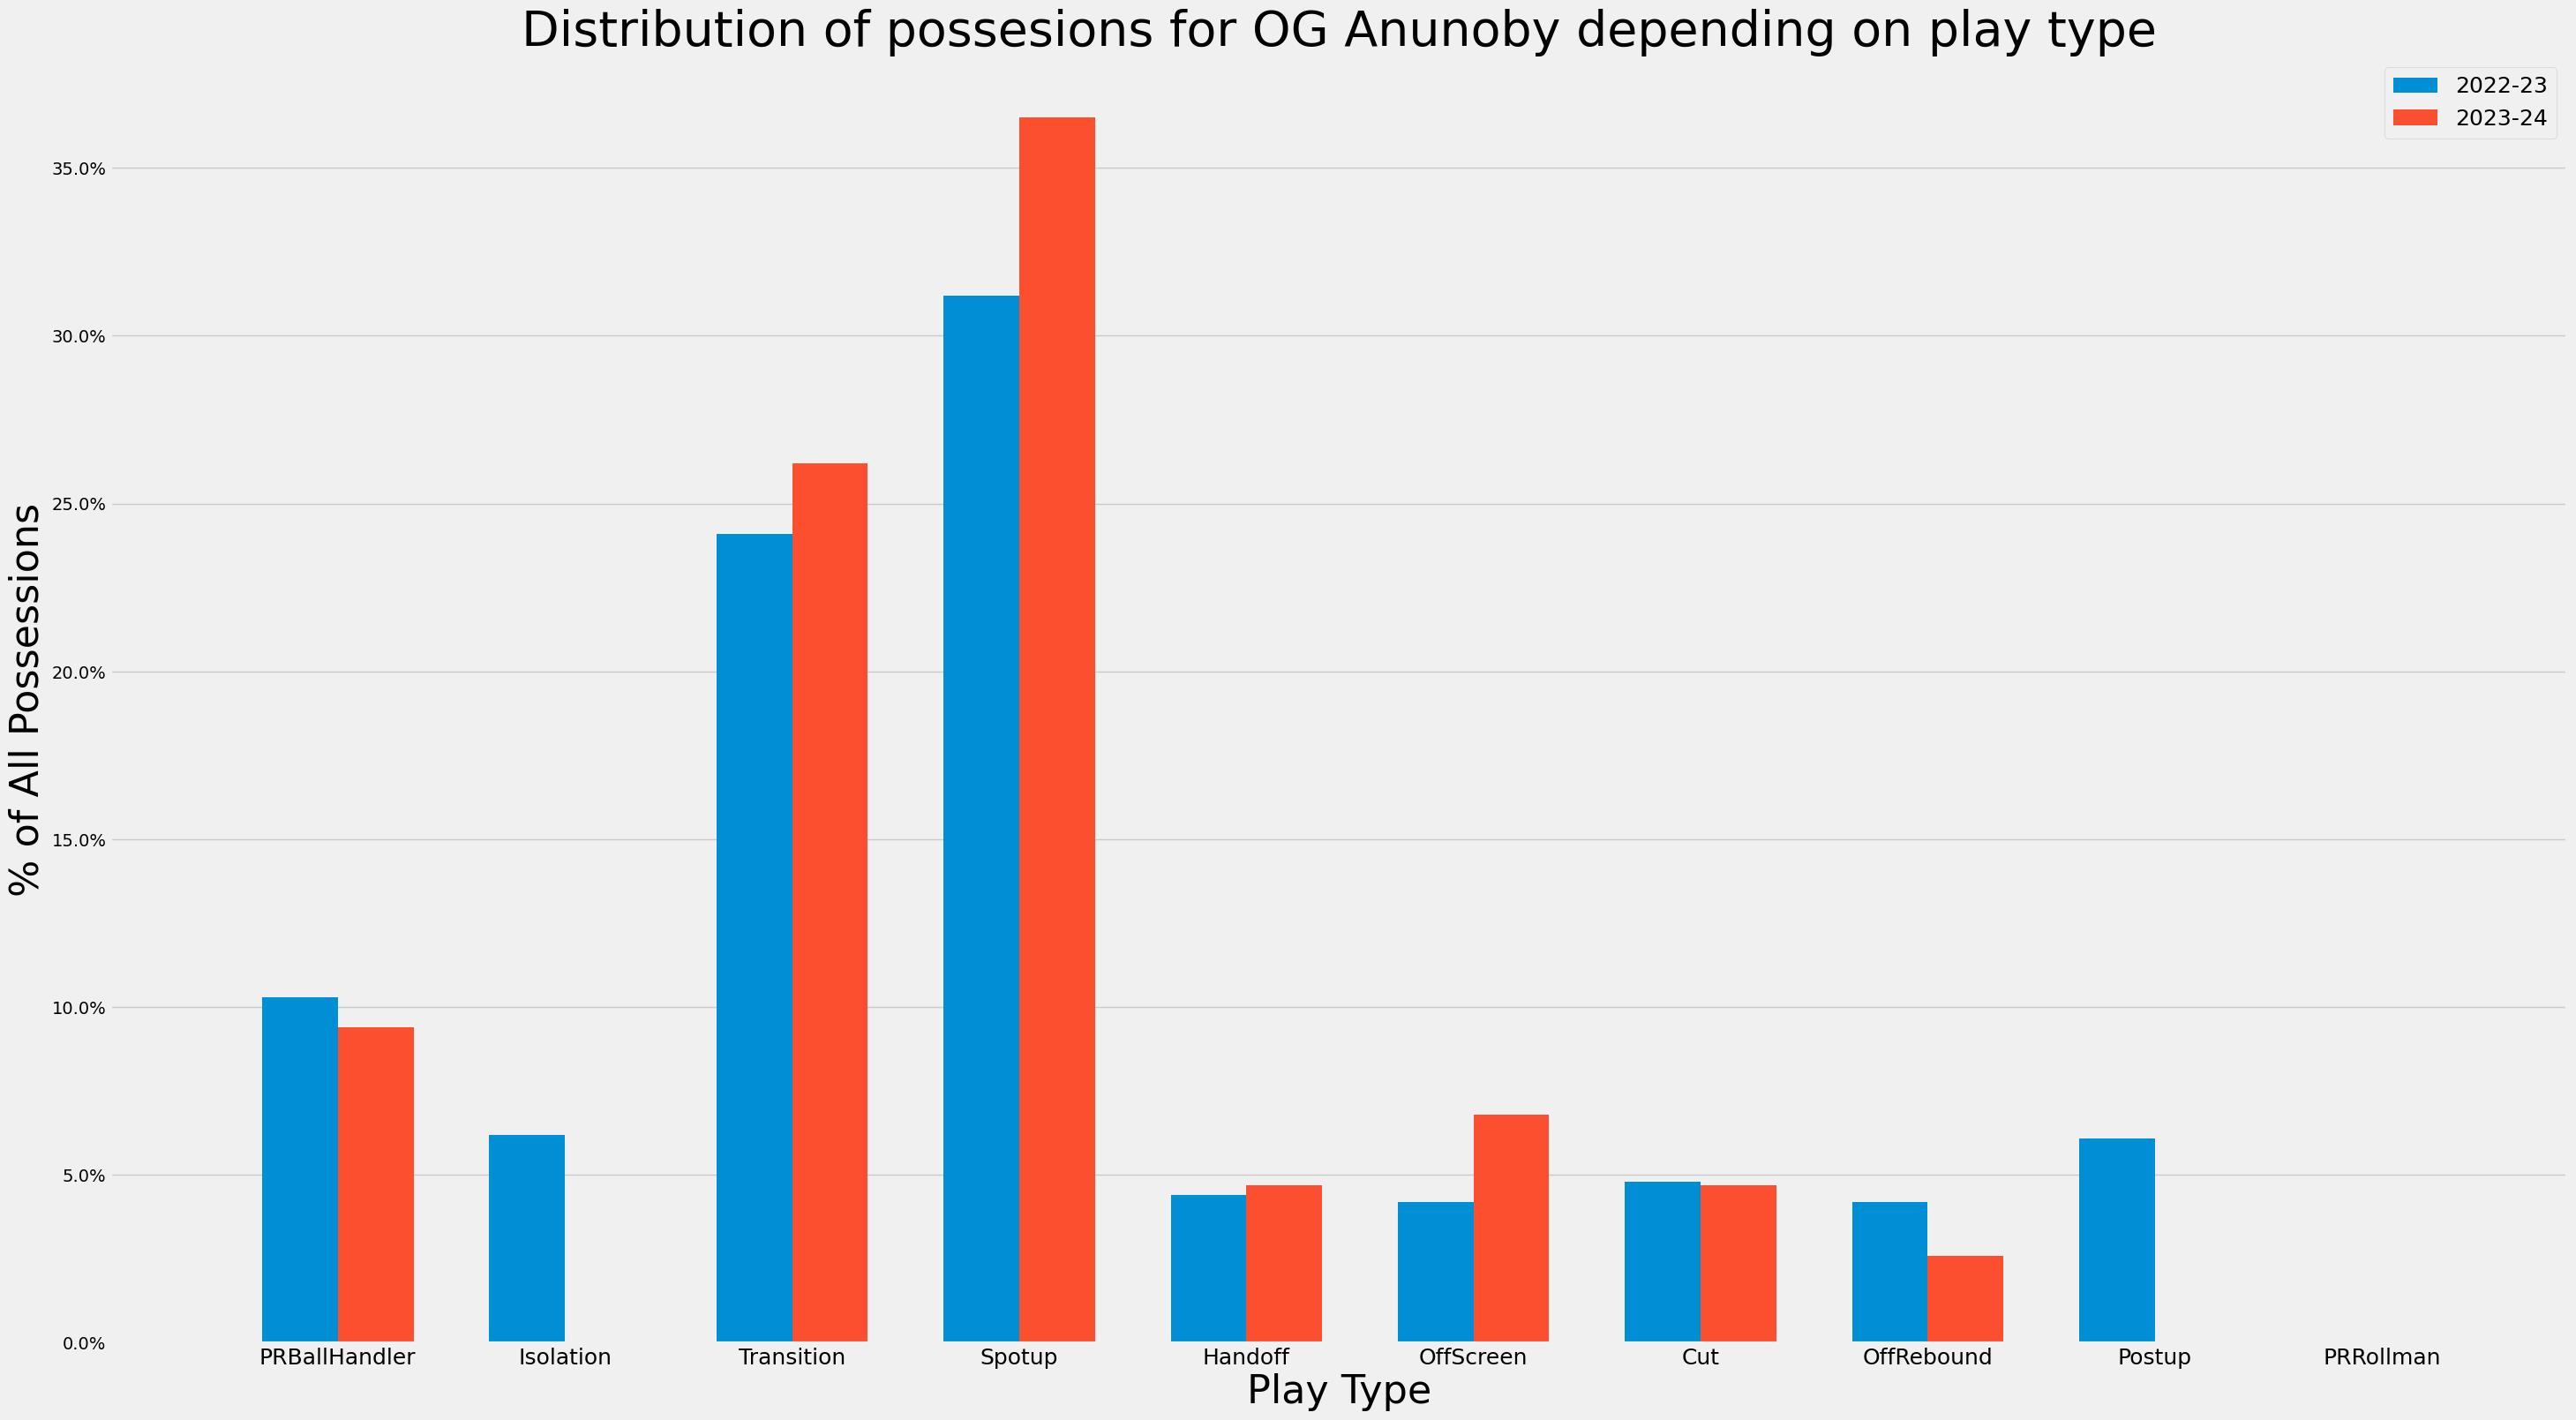

In [13]:
player_name = 'OG Anunoby'
play_type_seasons = get_data_for_player(player_name, seasons=['2022-23', '2023-24'])
plot_bar_chart_non_white(play_type_seasons, f"Distribution of possesions for {player_name} depending on play type")


## RJ Barrett

C:\Users\danie\AppData\Local\Temp\ipykernel_20444\1340230174.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data.loc[: ,'SEASON'] = season
C:\Users\danie\AppData\Local\Temp\ipykernel_20444\1340230174.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data.loc[: ,'SEASON'] = season
C:\Users\danie\AppData\Local\Temp\ipykernel_20444\2398590726.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xti

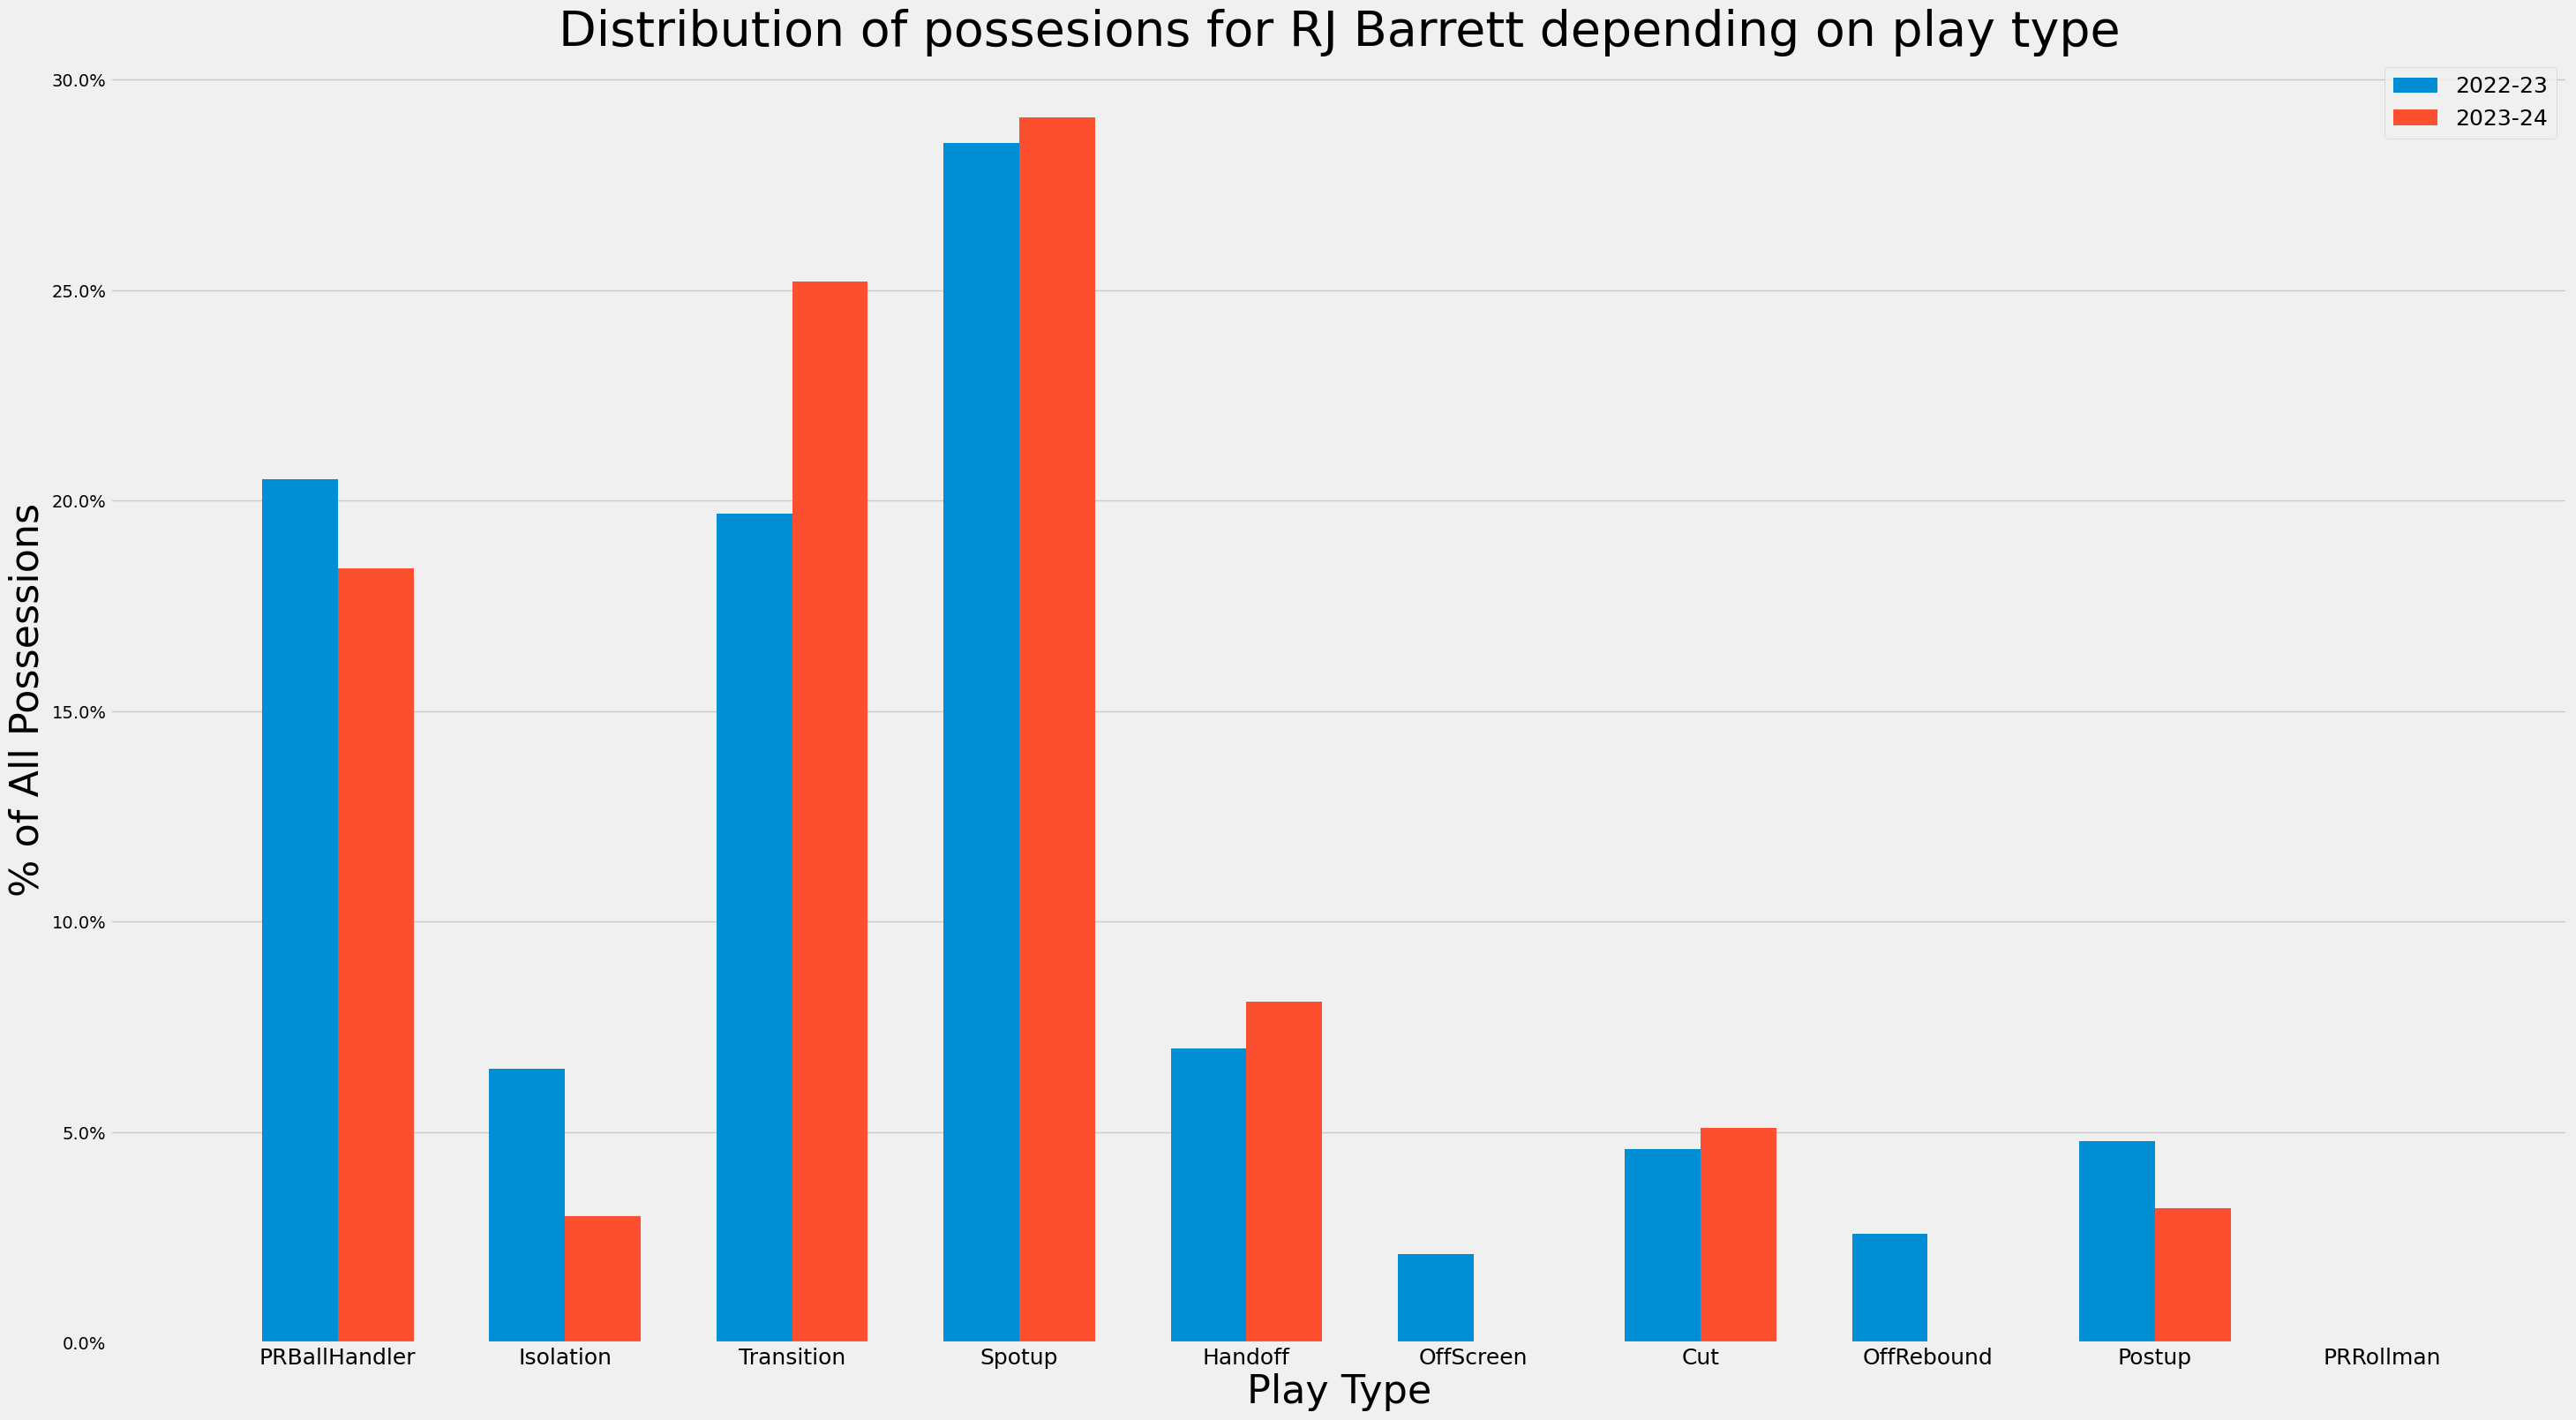

In [14]:
player_name = 'RJ Barrett'
play_type_seasons = get_data_for_player(player_name, seasons=['2022-23', '2023-24'])
plot_bar_chart_non_white(play_type_seasons, f"Distribution of possesions for {player_name} depending on play type")


## Quickley

C:\Users\danie\AppData\Local\Temp\ipykernel_20444\1340230174.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data.loc[: ,'SEASON'] = season
C:\Users\danie\AppData\Local\Temp\ipykernel_20444\1340230174.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data.loc[: ,'SEASON'] = season
C:\Users\danie\AppData\Local\Temp\ipykernel_20444\2398590726.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xti

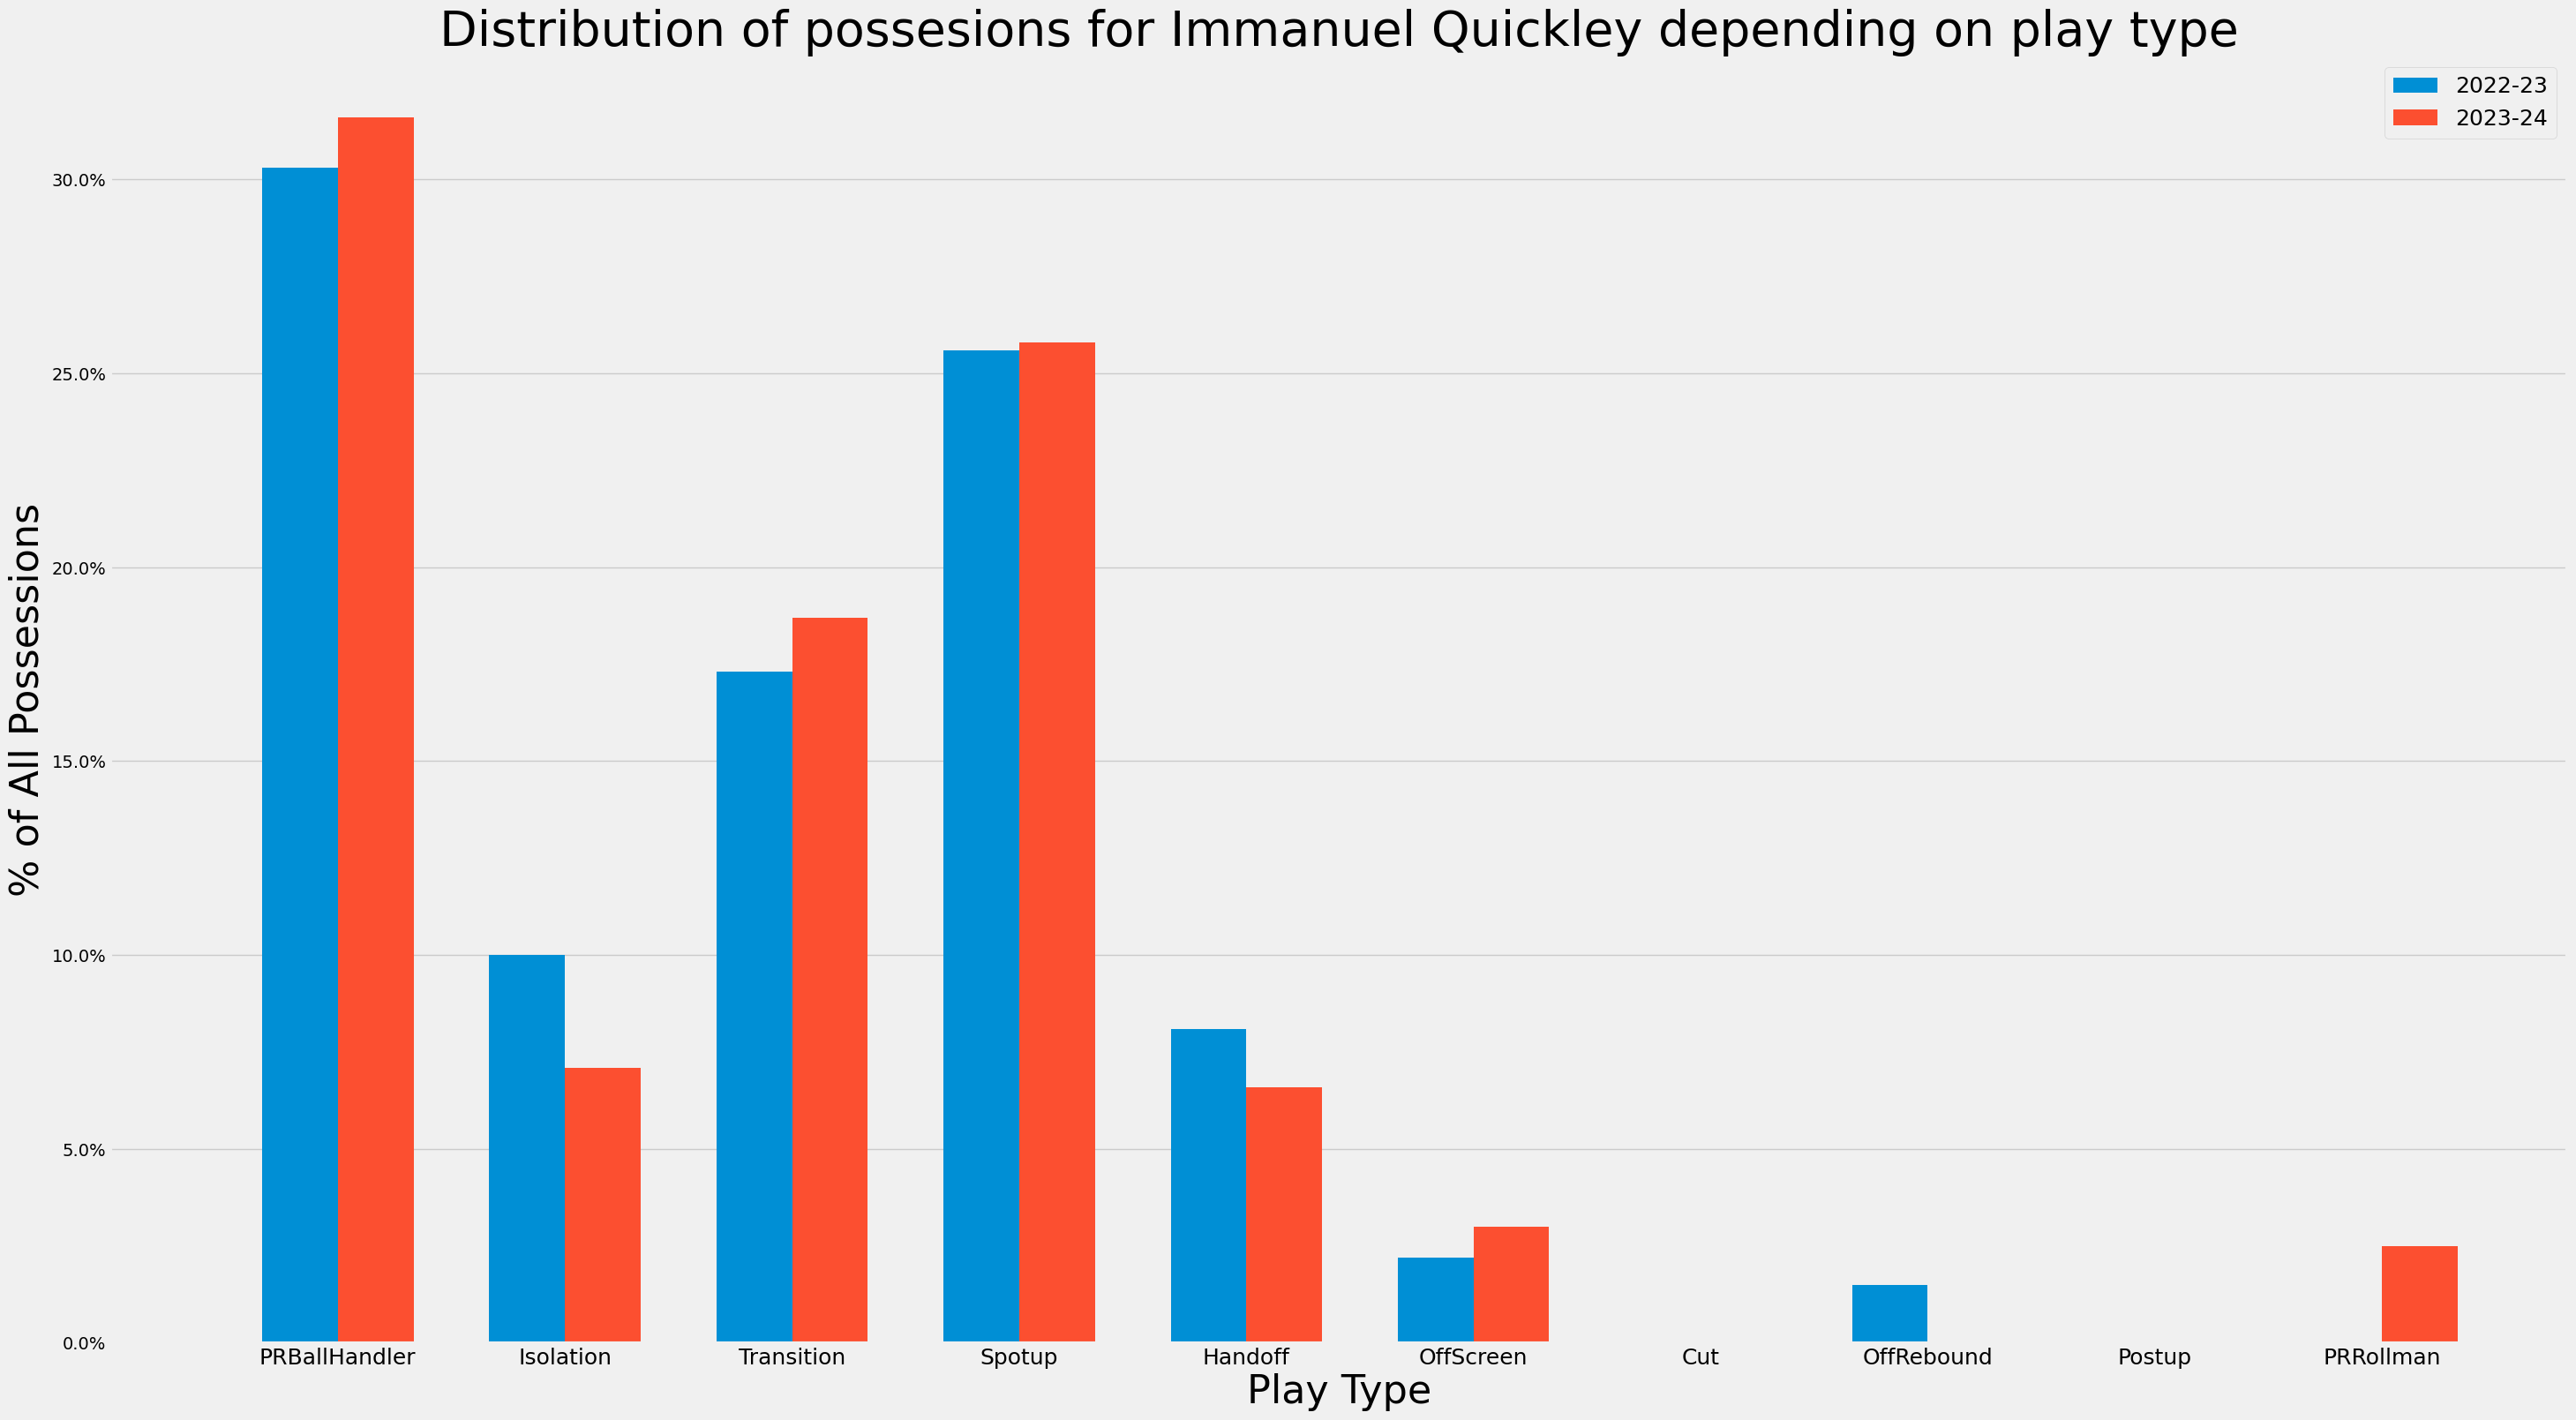

In [15]:
player_name = 'Immanuel Quickley'
play_type_seasons = get_data_for_player(player_name, seasons=['2022-23', '2023-24'])
plot_bar_chart_non_white(play_type_seasons, f"Distribution of possesions for {player_name} depending on play type")


## Cosine Similarity

In [108]:
cur_season = download_play_type_data('2023-24')

In [184]:
cur_poss = get_interesting_data(cur_season, target_column='POSS')

In [185]:
cur_poss.loc[:, 'POSS_TOTAL'] = cur_poss.loc[:, cur_poss.columns[1:]].sum(axis=1)

In [186]:
last_season = download_play_type_data('2022-23')

In [187]:
last_poss = get_interesting_data(last_season, target_column='POSS')

In [188]:
last_poss.loc[:, 'POSS_TOTAL'] = last_poss.loc[:, last_poss.columns[1:]].sum(axis=1)

In [189]:
merged_df = pd.merge(left=cur_poss, right=last_poss, on=('PLAYER_NAME'), suffixes=('_CUR', '_LAST'))

In [190]:
merged_df.loc[merged_df.PLAYER_NAME == 'Kevin Durant']

PLAYER_NAME  POSS_PRBallHandler_CUR  POSS_Isolation_CUR  \
96  Kevin Durant                     3.9                 5.6   

    POSS_Transition_CUR  POSS_Spotup_CUR  POSS_Handoff_CUR  \
96                  3.6              3.3               2.1   

    POSS_OffScreen_CUR  POSS_Cut_CUR  POSS_OffRebound_CUR  POSS_Postup_CUR  \
96                 2.3           1.4                  0.0              3.0   

    ...  POSS_Isolation_LAST  POSS_Transition_LAST  POSS_Spotup_LAST  \
96  ...             4.957447              3.480851          3.602128   

    POSS_Handoff_LAST  POSS_OffScreen_LAST  POSS_Cut_LAST  \
96                1.4             2.587234            1.0   

    POSS_OffRebound_LAST  POSS_Postup_LAST  POSS_PRRollman_LAST  \
96                   0.0          2.219149                  0.6   

    POSS_TOTAL_LAST  
96        23.342553  

[1 rows x 23 columns]

In [193]:
merged_df.sort_values(by='POSS_TOTAL_CUR', ascending=False)

PLAYER_NAME  POSS_PRBallHandler_CUR  POSS_Isolation_CUR  \
169            Joel Embiid                     0.0                 4.6   
112            Luka Doncic                    10.7                 6.7   
96            Kevin Durant                     3.9                 5.6   
60   Giannis Antetokounmpo                     3.8                 3.4   
156             Trae Young                    13.4                 3.1   
..                     ...                     ...                 ...   
300         DeAndre Jordan                     0.0                 0.0   
295           Mike Muscala                     0.0                 0.0   
275        Otto Porter Jr.                     0.0                 0.0   
272      Marcus Morris Sr.                     0.0                 0.0   
277            P.J. Tucker                     0.0                 0.0   

     POSS_Transition_CUR  POSS_Spotup_CUR  POSS_Handoff_CUR  \
169                  3.1              2.6               0.9   
112                  3.5              2.2               1.3   
96                   3.6              3.3               2.1   
60                   5.4              2.9               0.0   
156                  4.1              2.5               1.9   
..                   ...              ...               ...   
300                  0.0              0.0               0.0   
295                  0.0              0.0               0.0   
275                  0.0              1.4               0.0   
272                  0.0              1.3               0.0   
277                  0.0              1.0               0.0   

     POSS_OffScreen_CUR  POSS_Cut_CUR  POSS_OffRebound_CUR  POSS_Postup_CUR  \
169                 0.0           1.8                  2.9              6.1   
112                 0.0           0.0                  0.0              2.8   
96                  2.3           1.4                  0.0              3.0   
60                  0.0           2.1                  2.1              3.5   
156                 0.0           0.0                  0.0              0.0   
..                  ...           ...                  ...              ...   
300                 0.0           0.0                  0.0              0.0   
295                 0.0           1.6                  0.0              0.0   
275                 0.0           0.0                  0.0              0.0   
272                 0.0           0.0                  0.0              0.0   
277                 0.0           0.0                  0.0              0.0   

     ...  POSS_Isolation_LAST  POSS_Transition_LAST  POSS_Spotup_LAST  \
169  ...             6.600000              2.400000          3.200000   
112  ...             7.100000              3.000000          2.000000   
96   ...             4.957447              3.480851          3.602128   
60   ...             4.100000              8.000000          2.800000   
156  ...             3.500000              5.000000          2.400000   
..   ...                  ...                   ...               ...   
300  ...             0.000000              0.000000          0.000000   
295  ...             0.000000              0.800000          1.963492   
275  ...             0.000000              1.300000          0.000000   
272  ...             1.400000              1.300000          4.800000   
277  ...             0.000000              0.300000          1.700000   

     POSS_Handoff_LAST  POSS_OffScreen_LAST  POSS_Cut_LAST  \
169                0.0             0.000000            1.6   
112                1.3             0.700000            0.3   
96                 1.4             2.587234            1.0   
60                 0.5             0.300000            1.7   
156                0.8             0.500000            0.2   
..                 ...                  ...            ...   
300                0.0             0.000000            1.3   
295                0.0             0.000000    

In [192]:
subset = merged_df.loc[(merged_df.POSS_TOTAL_CUR > 17) | (merged_df.POSS_TOTAL_LAST > 17)]

In [195]:
filtered_subset = subset.loc[:, [
    'PLAYER_NAME', 'POSS_PRBallHandler_CUR', 'POSS_Isolation_CUR',
       'POSS_Transition_CUR', 'POSS_Spotup_CUR', 'POSS_Handoff_CUR',
       'POSS_OffScreen_CUR', 'POSS_Cut_CUR', 'POSS_OffRebound_CUR',
       'POSS_Postup_CUR', 'POSS_PRRollman_CUR', 
       'POSS_PRBallHandler_LAST', 'POSS_Isolation_LAST',
       'POSS_Transition_LAST', 'POSS_Spotup_LAST', 'POSS_Handoff_LAST',
       'POSS_OffScreen_LAST', 'POSS_Cut_LAST', 'POSS_OffRebound_LAST',
       'POSS_Postup_LAST', 'POSS_PRRollman_LAST'
]]

In [196]:
def tracking_shot_similarity(row):
    columns = [
        'POSS_PRBallHandler_LAST', 'POSS_Isolation_LAST',
       'POSS_Transition_LAST', 'POSS_Spotup_LAST', 'POSS_Handoff_LAST',
       'POSS_OffScreen_LAST', 'POSS_Cut_LAST', 'POSS_OffRebound_LAST',
       'POSS_Postup_LAST', 'POSS_PRRollman_LAST'
    ]
    first = row.loc[columns] / row.POSS_TOTAL_CUR
    
    second = row.loc[
        [
            'POSS_PRBallHandler_CUR', 'POSS_Isolation_CUR',
       'POSS_Transition_CUR', 'POSS_Spotup_CUR', 'POSS_Handoff_CUR',
       'POSS_OffScreen_CUR', 'POSS_Cut_CUR', 'POSS_OffRebound_CUR',
       'POSS_Postup_CUR', 'POSS_PRRollman_CUR',
        ]
    ] / row.POSS_TOTAL_LAST
    
    dot = np.dot(first, second)
    return dot / ((sum([item ** 2 for item in first]) ** 0.5) * (sum([item ** 2 for item in second]) ** 0.5))

In [197]:
cosines = []
for i in range(len(subset)):
    cosines.append(tracking_shot_similarity(subset.iloc[i]))

subset.loc[:, 'COSINE_SIM'] = cosines

C:\Users\danie\AppData\Local\Temp\ipykernel_11848\1235524960.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset.loc[:, 'COSINE_SIM'] = cosines


In [198]:
subset.sort_values(by='COSINE_SIM', ascending=True).iloc[:30]

PLAYER_NAME  POSS_PRBallHandler_CUR  POSS_Isolation_CUR  \
13            Bradley Beal                     6.0                 0.0   
67              Jaden Ivey                     1.8                 0.7   
94         Kelly Oubre Jr.                     1.4                 0.0   
143         Shaedon Sharpe                     6.4                 1.5   
89            Jrue Holiday                     3.2                 1.1   
132          Pascal Siakam                     2.4                 1.8   
166         Alperen Sengun                     0.0                 0.9   
167            Bam Adebayo                     0.0                 2.4   
73            James Harden                     5.4                 2.6   
47            Desmond Bane                     6.5                 1.3   
161           Tyrese Maxey                     8.8                 2.2   
226     Kristaps Porzingis                     0.0                 0.0   
140      Russell Westbrook                     1.9                 2.1   
123          Mikal Bridges                     5.9                 2.4   
17             CJ McCollum                     5.6                 1.3   
90           Julius Randle                     2.6                 2.6   
169            Joel Embiid                     0.0                 4.6   
136            Paul George                     4.4                 3.4   
142         Scottie Barnes                     2.8                 1.5   
77            Jerami Grant                     2.5                 3.1   
76            Jayson Tatum                     6.0                 5.2   
74       Jaren Jackson Jr.                     0.6                 2.1   
75            Jaylen Brown                     3.4                 2.5   
159            Tyler Herro                     9.1                 0.0   
39           DeMar DeRozan                     6.8                 2.5   
60   Giannis Antetokounmpo                     3.8                 3.4   
104             Kyle Kuzma                     4.5                 2.4   
91      Karl-Anthony Towns                     0.6                 2.3   
57            Franz Wagner                     4.4                 1.3   
92           Kawhi Leonard                     3.8                 3.2   

     POSS_Transition_CUR  POSS_Spotup_CUR  POSS_Handoff_CUR  \
13                   0.0              4.3               0.0   
67                   2.9              3.0               0.6   
94                   3.5              2.8               1.9   
143                  3.5              2.9               1.2   
89                   2.6              3.1               0.0   
132                  4.9              4.2               0.9   
166                  2.1              2.4               0.0   
167                  3.0              1.4               0.0   
73                   1.9              3.2               0.0   
47                   4.6              3.2               3.2   
161                  4.1              3.1               3.2   
226                  1.3              3.6               0.0   
140                  3.5              2.7               0.0   
123                  3.1              4.6               1.9   
17                   3.3              4.9               0.0   
90                   3.7              5.5               0.8   
169                  3.1              2.6               0.9   
136                  4.6              3.7               0.6   
142                  4.0              4.3               0.8   
77                   3.4              6.4               1.1   
76                   3.5              3.5               0.0   
74                   2.8              4.4               0.0   
75                   6.6              3.8               1.1   
159                  4.1              2.6               2.5   
39                   1.5              4.5               0.7   
60                   5.4              2.9               0.0   
104                

In [139]:
play_types_seasons['2023-24']['Postup'].iloc[3]

SEASON_ID                  22023
PLAYER_ID                1628389
PLAYER_NAME          Bam Adebayo
TEAM_ID               1610612748
TEAM_ABBREVIATION            MIA
TEAM_NAME             Miami Heat
PLAY_TYPE                 Postup
TYPE_GROUPING          Offensive
PERCENTILE                 0.451
GP                            16
POSS_PCT                   0.233
PPP                        0.925
FG_PCT                     0.452
FT_POSS_PCT                 0.15
TOV_POSS_PCT               0.088
SF_POSS_PCT                0.113
PLUSONE_POSS_PCT           0.013
SCORE_POSS_PCT             0.475
EFG_PCT                    0.452
POSS                         5.0
PTS                          4.6
FGM                          1.8
FGA                          3.9
FGMX                         2.1
TOTAL_POSS                  80.0
Name: 3, dtype: object